# <center> LEGO sets listing price prediction - regression model</center>

Machine Learning 1 Regression Project  
<b>Michał Thor, Bartłomiej Kowalczuk  </b>

In this project we wanted to created digit classifier that would be trained on data published on https://github.com/kensanata/numbers.  
Using that data we created a dataset that consits of 10.000 images (1000 images for each digit), all rescaled to 28x28 resolution, all in grayscale.

So basically, we transformed all the images into 1x784 vectors that has information about each pixel in the images. Then we used it as "one row" inputs into our models. 

We used Support Vector Machines algorithm, which after tuning, scored <b>92% accuracy</b> on the test set.  
Then we used Random Forest algorithm, which scored <b>91% accuracy</b> on the test set.  
Finally we used Convolutional Neural Network, which we tuned to gave us almost <b>97% accuracy</b>.

Firstly, we import all the necessary packages

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2_score

import keras
from keras import optimizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor



Nextly, we define some utillity functions that will help us in estimating/evaluating models.

We implement our own adjusted R-squared function, since sklearn package does not have one.

We also implement stepwise selection function for OLS model, which is based on the solution from:
https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447

In [3]:
def adj_r2(r_sqr, n, p):
    r_2 = 1-(1-r_sqr)*(n-1)/(n-p-1)
    return r_2


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# <center>1. Understanding the data</center>

### Loading the dataset

In [4]:
df = pd.read_csv('lego_Sets.csv')

### Brief preview of the dataset structure

In [5]:
display(df.head(5))

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
0,6-12,29.99,2.0,277.0,4.0,Catapult into action and take back the eggs fr...,75823.0,Use the staircase catapult to launch Red into ...,Average,Bird Island Egg Heist,4.5,Angry Birds™,4.0,US
1,6-12,19.99,2.0,168.0,4.0,Launch a flying attack and rescue the eggs fro...,75822.0,Pilot Pig has taken off from Bird Island with ...,Easy,Piggy Plane Attack,5.0,Angry Birds™,4.0,US
2,6-12,12.99,11.0,74.0,4.3,Chase the piggy with lightning-fast Chuck and ...,75821.0,Pitch speedy bird Chuck against the Piggy Car....,Easy,Piggy Car Escape,4.3,Angry Birds™,4.1,US
3,12+,99.99,23.0,1032.0,3.6,Explore the architecture of the United States ...,21030.0,Discover the architectural secrets of the icon...,Average,United States Capitol Building,4.6,Architecture,4.3,US
4,12+,79.99,14.0,744.0,3.2,Recreate the Solomon R. Guggenheim Museum® wit...,21035.0,Discover the architectural secrets of Frank Ll...,Challenging,Solomon R. Guggenheim Museum®,4.6,Architecture,4.1,US


Our goal is to predict value of the list_price variable - listing price of a certain toy in LEGO online store.

<b>country</b> variable is indicating which online store (from which country) is listing that item.

# <center>2. Preparing the dataset</center>

## 2.1 Removing useless data and fixing formats

Removing variables that would give no predictive power (information variables such as ID's or descriptions)

In [6]:
df = df.drop(['prod_desc', 
              'prod_id', 
              'prod_long_desc', 
              'set_name'],
             axis=1)

Changing categorical variables and list_price into right formats.

Also we are ordering review_difficulty since it is ordered scale of difficulty.

In [7]:
df.list_price = df.list_price.astype(float)
df['review_difficulty'] = df['review_difficulty'].astype("category")
df['review_difficulty'] = df['review_difficulty'].cat.reorder_categories(['Very Easy',
                                                               'Easy',
                                                               'Average',
                                                               'Challenging',
                                                               'Very Challenging'],
                                                                        ordered = True)
df['review_difficulty'] = df['review_difficulty'].cat.codes
df.theme_name = df.theme_name.astype(object)
df.ages = df.ages.astype(object)

## 2.2 Cleaning dataset from NA's

In [8]:
missing_data = pd.DataFrame({'Number of occurencies': df.isna().sum(),
                             'Percentage': 100*df.isna().sum()/len(df)
                            })
missing_data[missing_data['Number of occurencies'] > 0]

,Number of occurencies,Percentage
num_reviews,1620,13.212625
play_star_rating,1775,14.476796
star_rating,1620,13.212625
theme_name,3,0.024468
val_star_rating,1795,14.639915


Since the missings in star_rating (all 3 columns concerning them) are common for certain observations, maybe we can somehow reduce the number of them by filling missing values with computed value.

We mark the missings in review difficulty with a group code equal to -1.

We can see that star_rating has less NA's than play and val star_rating. We shall see if there is a correlation between those 3 variables. 

In [9]:
corr = df[['star_rating', 'play_star_rating', 'val_star_rating']].corr()
corr.style.background_gradient(cmap='coolwarm')

,star_rating,play_star_rating,val_star_rating
star_rating,1,0.608193,0.72789
play_star_rating,0.608193,1,0.480938
val_star_rating,0.72789,0.480938,1


Let us compute means of ratios between star_rating for the whole dataset and use that ratio to create values to impute instead of NA's.

Because of slightly high correlation we decide to omit star_rating and leave the two other ratings (and since they all have same number of NA's)

In [10]:
df['star/play'] = df['star_rating']/df['play_star_rating']
df['star/val'] = df['star_rating']/df['val_star_rating']

star_p_mean = df['star/play'].mean()
star_v_mean = df['star/val'].mean()

df.loc[(df['play_star_rating'].isnull()) & (df['star_rating'].notna()), "play_star_rating"] = df["star_rating"]*star_p_mean
df.loc[(df['val_star_rating'].isnull()) & (df['star_rating'].notna()), "val_star_rating"] = df["star_rating"]*star_v_mean

df.drop(['star/play', 'star/val', 'star_rating'], axis=1, inplace=True)

That way we manage to narrow our total rows with NA's to 1620. Unfortunately there is no way to safely replace values for these observations (which all have at least 3 NA's) so we will omit them in further analysis.

In [11]:
df.loc[df.isnull().sum(1)>=3].index

df = df.dropna()

## 2.3 Checking for correlations and encoding categorical variables - using One Hot Encoding

Creating correlation matrix:

In [12]:
corr = df.drop(['list_price'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,num_reviews,piece_count,play_star_rating,review_difficulty,val_star_rating
num_reviews,1,0.546616,-0.0451145,0.328073,0.0148351
piece_count,0.546616,1,0.0147979,0.509112,0.0636759
play_star_rating,-0.0451145,0.0147979,1,0.018671,0.499167
review_difficulty,0.328073,0.509112,0.018671,1,-0.00300082
val_star_rating,0.0148351,0.0636759,0.499167,-0.00300082,1


There are no visible very high correlations (some ~0.5, but we decide to leave them in further analysis, because these are not worrying values).

In [14]:
cat_vars = []
cont_vars = []
for variable in df.columns:
    if df[variable].dtype==object:
        cat_vars.append(variable)
    else:
        cont_vars.append(variable)
        
num_of_cats = {}
for category in cat_vars:
    num_of_cats[category] = len(list(df[category].unique()))
    
print(num_of_cats)

{'ages': 31, 'theme_name': 38, 'country': 21}


We can see that all the variables have a lot of levels, let's see how different are the numbers of observations within each level on barplots below.

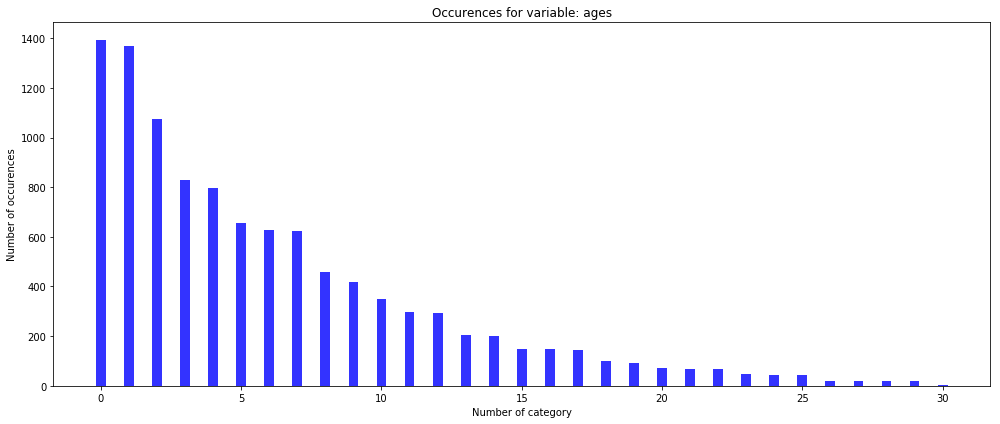

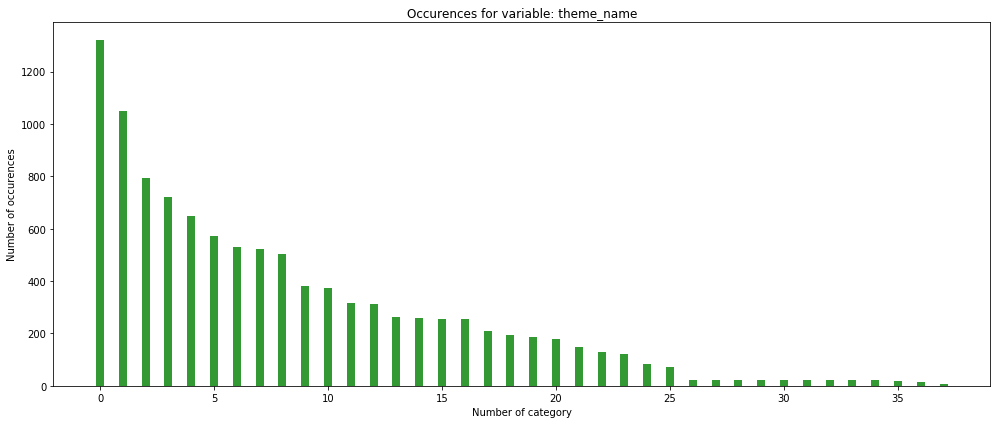

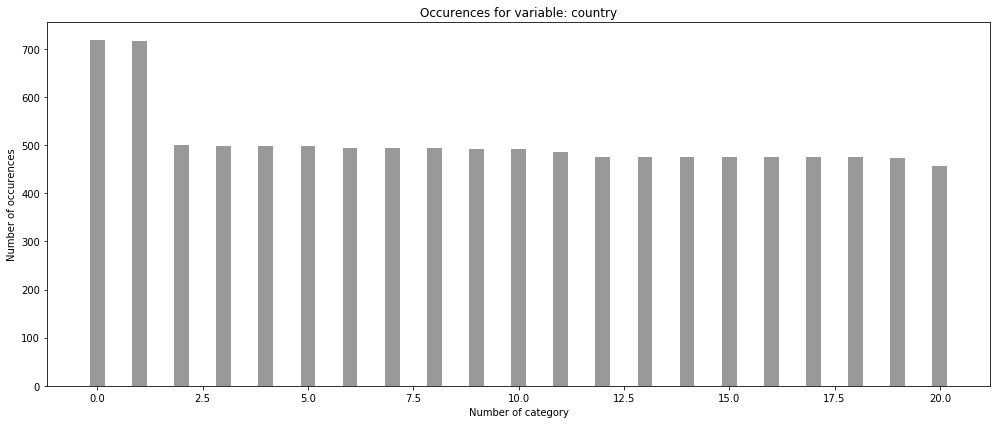

In [15]:
bar_width = 0.35
opacity = 0.8
colors = ["b","g","grey"]


for idx, var in enumerate(cat_vars):
    plt.figure(figsize=(14,6))
    boo = list(dict(df[var].value_counts()).values())
    leng = np.arange(len(list(dict(df[var].value_counts()).values())))
    rects = plt.bar(leng, boo, bar_width,
    alpha=opacity,
    color=colors[idx])
    plt.ylabel('Number of occurences')
    plt.xlabel('Number of category')
    plt.title('Occurences for variable: {}'.format(var))
    plt.tight_layout()
    plt.show()

Since there are no categories that would be very differently populated than the rest (they gradually descent) we decided to keep all the variables for one hot encoding.

Next we are creating dummy variables through one hot encoding for each category in categorical variables (omitting review_difficulty in which we introduced ordered categories).

In [16]:
df2 = pd.get_dummies(df, drop_first=True)

## 2.4 Splitting dataset into training and testing dataset

In [17]:
X, Y = df2.drop(['list_price'], axis=1), df2['list_price']

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, 
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=361)

In [18]:
df2.shape

(10638, 93)

We are left with 10638 observations and 92 variables which we have split into 70/30 train/test datasets. 

That way we are ready to begin estimating predictive models using 3 different methods.

# <center>3. Predicting data </center>

## 3.1 Linear Regression (OLS) model

Firstly, we are trying to estimate OLS linear regression model using all possible variables.

In [19]:
X_train_lin = sm.add_constant(X_train)
X_test_lin = sm.add_constant(X_test)
 
ols_model = sm.OLS(Y_train, X_train_lin).fit()
linear_pred = ols_model.predict(X_test_lin) 

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     533.6
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:57:30   Log-Likelihood:                -37322.
No. Observations:                7446   AIC:                         7.482e+04
Df Residuals:                    7357   BIC:                         7.544e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [20]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, linear_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, linear_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, linear_pred)))
print('Adjusted R-squared:', adj_r2(r2_score(Y_test, linear_pred), X_train.shape[0], X_train.shape[1]))

Mean Absolute Error: 16.757313097654322
Mean Squared Error: 1166.380221526104
Root Mean Squared Error: 34.15230916828471
Adjusted R-squared: 0.8653570978839871


We are using our own implementation of R-squared because we want to see value of the coefficient of determination on test data (by accessing <i>OLS.model.rsquared_adj</i> we get the value for training data). 

We can see promising values (although RMSE is quite high). Let us see how will the model with stepwise selected variables perform:

## 3.2 Linear Regression (OLS) model with stepwise selected features

We choose only variables with p-value of t-test < 0.05.

In [21]:
selected_vars = stepwise_selection(X_train, Y_train, verbose=False)

stepwise_X_train = X_train[selected_vars]
stepwise_X_test = X_test[selected_vars]

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


In [22]:
stepwise_X_train = sm.add_constant(stepwise_X_train)
stepwise_X_test = sm.add_constant(stepwise_X_test)
 
stepwise_model = sm.OLS(Y_train, stepwise_X_train).fit()
stepwise_pred = stepwise_model.predict(stepwise_X_test) 

print(stepwise_model.summary())

                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1284.
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:58:30   Log-Likelihood:                -37487.
No. Observations:                7446   AIC:                         7.505e+04
Df Residuals:                    7410   BIC:                         7.529e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [23]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, stepwise_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, stepwise_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, stepwise_pred)))
print('R-squared value:', adj_r2(r2_score(Y_test, stepwise_pred), stepwise_X_train.shape[0], stepwise_X_train.shape[1]))

Mean Absolute Error: 17.81808453192541
Mean Squared Error: 1245.1609961725383
Root Mean Squared Error: 35.28683885207824
R-squared value: 0.8573493362649673


We obtain worse results than with model build on the whole dataset. Let us try other method.

## 3.3 Elastic Net

Firstly, we are tuning the hyperparameters to find the best fit:

In [ ]:
eNet = ElasticNet(max_iter = 1000)

parametersGrid = {"alpha": [0.0001, 0.001, 0.005, 0.01, 0.1, 1.0],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1),
                 "tol": [ 0.00001, 0.0001, 0.01, 0.1],
                 "normalize": [True, False]}

grid = GridSearchCV(eNet, 
                    parametersGrid, 
                    scoring='r2', 
                    cv=5,
                    refit = 'r2')
grid.fit(X_train, Y_train)
grid_pred = grid.predict(X_test)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Now, we estimate data using best parameters for elastic net.

In [72]:
eNet = ElasticNet(max_iter = 1000,
                  alpha = 0.0001,
                  l1_ratio = 0.9,
                  tol = 0.00001)

eNet.fit(X_train, Y_train)
elastic_pred = eNet.predict(X_test)

c:\program files\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [73]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, elastic_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, elastic_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, elastic_pred)))
print('R-squared value:', adj_r2(r2_score(Y_test, elastic_pred), X_train.shape[0], X_train.shape[1]))

Mean Absolute Error: 16.740875751994192
Mean Squared Error: 1167.9068910568694
Root Mean Squared Error: 34.17465275693185
R-squared value: 0.8651808644290633


We can see that results are still not as good as when using simple Linear Regression. 

## 3.4 Neural Network

In [78]:
def create_model(momentum = 0.2,
                activation = 'softplus',
                learn_rate = 0.001,
                dropout_rate = 0.0,
                weight_constraint = 3,
                neurons = 100,
                init = 'lecun_uniform'
                optimizer = 'adagrad',
                normalize = True): 

    # create model
    NN_model = Sequential()
    NN_model.add(Dense(128, 
                   kernel_initializer=init,
                   input_dim = X_train.shape[1], 
                   activation=activation))

    # The Hidden Layers :
    NN_model.add(Dense(neurons, 
                       kernel_initializer=init,
                       activation=activation,
                      kernel_constraint=maxnorm(weight_constraint)))
    NN_model.add(Dense(neurons, 
                       kernel_initializer=init,
                       activation=activation,
                      kernel_constraint=maxnorm(weight_constraint)))
    NN_model.add(Dropout(dropout_rate)) 
    NN_model.add(Dense(neurons, 
                       kernel_initializer=init,
                       activation=activation,
                      kernel_constraint=maxnorm(weight_constraint)))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer=init,
                       activation='linear'))

    
    NN_model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_absolute_error',
                           'mean_squared_error'])
    
    NN_model.fit(X_train, Y_train,
          epochs=300,
          batch_size=64)
    
    return NN_model


model = KerasRegressor(build_fn=create_model, 
                        epochs = 300, 
                        batch_size = 64,
                        verbose = 1)

SyntaxError: invalid syntax (<ipython-input-78-f299decf73a6>, line 8)

In [ ]:
def grid_search(model = model):
# Use scikit-learn to grid search 
    activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
    learn_rate = [0.0001, 0.0005, 0.001, 0.025, 0.005, 0.075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2]
    dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    weight_constraint=[1, 2, 3, 4, 5]
    neurons = [30, 100, 128, 256]
    init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    optimizer = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']
    normalize = [True, False]
    ##############################################################
    # grid search epochs, batch size
    epochs = [50, 100] # add 50, 100, 150 etc
    batch_size = [10, 32, 64, 100] # add 5, 10, 20, 40, 60, 80, 100 etc
    param_grid = dict(# epochs=epochs,
#                      batch_size=batch_size,
#                      activation=activation,
#                      momentum=momentum,
#                      learn_rate=learn_rate,
#                      dropout_rate=dropout_rate,
#                      weight_constraint=weight_constraint,
#                      neurons=neurons,
                     init=init,
#                      optimizer=optimizer,
#                      normalize=normalize
                     )
    ##############################################################
    grid = GridSearchCV(estimator=model, 
                        param_grid=param_grid, 
                        scoring=['r2'],
                        refit = 'r2',
                        n_jobs=1,
                        cv = 5)
    grid_result = grid.fit(X_train, Y_train) 
    ##############################################################
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_r2']
    stds = grid_result.cv_results_['std_test_r2']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
grid_search(model)

Epoch 1/300
7446/7446 [==============================] - 1s 89us/step - loss: 4803.1360 - mean_absolute_error: 24.5207 - mean_squared_error: 4803.1360
Epoch 2/300
7446/7446 [==============================] - 0s 39us/step - loss: 2484.2677 - mean_absolute_error: 20.8516 - mean_squared_error: 2484.2677
Epoch 3/300
7446/7446 [==============================] - 0s 37us/step - loss: 2429.1905 - mean_absolute_error: 20.5044 - mean_squared_error: 2429.1905
Epoch 4/300
7446/7446 [==============================] - 0s 35us/step - loss: 2443.6631 - mean_absolute_error: 20.4465 - mean_squared_error: 2443.6631
Epoch 5/300
7446/7446 [==============================] - 0s 36us/step - loss: 2383.4635 - mean_absolute_error: 20.2562 - mean_squared_error: 2383.4635
Epoch 6/300
7446/7446 [==============================] - 0s 38us/step - loss: 2370.9157 - mean_absolute_error: 20.1983 - mean_squared_error: 2370.9157
Epoch 7/300
7446/7446 [==============================] - 0s 37us/step - loss: 2357.1166 - mean

7446/7446 [==============================] - 0s 38us/step - loss: 1555.8276 - mean_absolute_error: 14.7692 - mean_squared_error: 1555.8276
Epoch 55/300
7446/7446 [==============================] - 0s 34us/step - loss: 1543.6965 - mean_absolute_error: 14.6745 - mean_squared_error: 1543.6965
Epoch 56/300
7446/7446 [==============================] - 0s 35us/step - loss: 1557.3801 - mean_absolute_error: 14.8361 - mean_squared_error: 1557.3801
Epoch 57/300
7446/7446 [==============================] - 0s 34us/step - loss: 1549.8008 - mean_absolute_error: 14.6772 - mean_squared_error: 1549.8008
Epoch 58/300
7446/7446 [==============================] - 0s 35us/step - loss: 1528.9058 - mean_absolute_error: 14.7651 - mean_squared_error: 1528.9058
Epoch 59/300
7446/7446 [==============================] - 0s 34us/step - loss: 1455.0056 - mean_absolute_error: 14.4593 - mean_squared_error: 1455.0056
Epoch 60/300
7446/7446 [==============================] - 0s 34us/step - loss: 1411.6901 - mean_absol

7446/7446 [==============================] - 0s 41us/step - loss: 566.6296 - mean_absolute_error: 10.3493 - mean_squared_error: 566.6296
Epoch 109/300
7446/7446 [==============================] - 0s 35us/step - loss: 472.1147 - mean_absolute_error: 9.9664 - mean_squared_error: 472.1147
Epoch 110/300
7446/7446 [==============================] - 0s 37us/step - loss: 484.8995 - mean_absolute_error: 9.9918 - mean_squared_error: 484.8995
Epoch 111/300
7446/7446 [==============================] - 0s 38us/step - loss: 413.8251 - mean_absolute_error: 9.5839 - mean_squared_error: 413.8251 0s - loss: 420.2760 - mean_absolute_error: 9.6010 - mean_squared_error: 420.27
Epoch 112/300
7446/7446 [==============================] - 0s 38us/step - loss: 527.1537 - mean_absolute_error: 10.1426 - mean_squared_error: 527.1537
Epoch 113/300
7446/7446 [==============================] - 0s 37us/step - loss: 452.4482 - mean_absolute_error: 9.8267 - mean_squared_error: 452.4482
Epoch 114/300
7446/7446 [========

7446/7446 [==============================] - 0s 37us/step - loss: 267.2489 - mean_absolute_error: 8.3374 - mean_squared_error: 267.2489
Epoch 162/300
7446/7446 [==============================] - 0s 36us/step - loss: 269.0829 - mean_absolute_error: 8.3216 - mean_squared_error: 269.0829
Epoch 163/300
7446/7446 [==============================] - 0s 36us/step - loss: 269.5465 - mean_absolute_error: 8.3289 - mean_squared_error: 269.5465
Epoch 164/300
7446/7446 [==============================] - 0s 44us/step - loss: 252.3828 - mean_absolute_error: 8.3115 - mean_squared_error: 252.3828
Epoch 165/300
7446/7446 [==============================] - 0s 49us/step - loss: 257.1701 - mean_absolute_error: 8.2292 - mean_squared_error: 257.1701
Epoch 166/300
7446/7446 [==============================] - 0s 35us/step - loss: 340.1262 - mean_absolute_error: 8.5630 - mean_squared_error: 340.1262
Epoch 167/300
7446/7446 [==============================] - 0s 37us/step - loss: 285.3195 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 39us/step - loss: 249.2066 - mean_absolute_error: 7.8811 - mean_squared_error: 249.2066
Epoch 216/300
7446/7446 [==============================] - 0s 40us/step - loss: 236.5961 - mean_absolute_error: 7.7886 - mean_squared_error: 236.5961
Epoch 217/300
7446/7446 [==============================] - 0s 38us/step - loss: 231.8960 - mean_absolute_error: 7.7302 - mean_squared_error: 231.8960
Epoch 218/300
7446/7446 [==============================] - 0s 39us/step - loss: 250.6668 - mean_absolute_error: 7.8857 - mean_squared_error: 250.6668
Epoch 219/300
7446/7446 [==============================] - 0s 57us/step - loss: 244.7867 - mean_absolute_error: 7.8400 - mean_squared_error: 244.7867
Epoch 220/300
7446/7446 [==============================] - 0s 50us/step - loss: 228.4328 - mean_absolute_error: 7.7319 - mean_squared_error: 228.4328
Epoch 221/300
7446/7446 [==============================] - 0s 43us/step - loss: 223.8425 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 42us/step - loss: 201.1284 - mean_absolute_error: 7.2977 - mean_squared_error: 201.1284 0s - loss: 188.8050 - mean_absolute_error: 7.3369 - mean_squared_error: 
Epoch 270/300
7446/7446 [==============================] - 0s 35us/step - loss: 208.3071 - mean_absolute_error: 7.3999 - mean_squared_error: 208.3071
Epoch 271/300
7446/7446 [==============================] - 0s 41us/step - loss: 228.0937 - mean_absolute_error: 7.5439 - mean_squared_error: 228.0937
Epoch 272/300
7446/7446 [==============================] - 0s 39us/step - loss: 215.2816 - mean_absolute_error: 7.3315 - mean_squared_error: 215.2816
Epoch 273/300
7446/7446 [==============================] - 0s 36us/step - loss: 182.8290 - mean_absolute_error: 7.1897 - mean_squared_error: 182.8290
Epoch 274/300
7446/7446 [==============================] - 0s 35us/step - loss: 198.1537 - mean_absolute_error: 7.2125 - mean_squared_error: 198.1537
Epoch 275/300
7446/7446 [================

5956/5956 [==============================] - 0s 42us/step - loss: 176.2161 - mean_absolute_error: 6.9620 - mean_squared_error: 176.2161
Epoch 24/300
5956/5956 [==============================] - 0s 44us/step - loss: 165.7393 - mean_absolute_error: 6.9353 - mean_squared_error: 165.7393
Epoch 25/300
5956/5956 [==============================] - 0s 35us/step - loss: 185.2953 - mean_absolute_error: 7.1043 - mean_squared_error: 185.2953
Epoch 26/300
5956/5956 [==============================] - 0s 34us/step - loss: 164.7843 - mean_absolute_error: 6.9110 - mean_squared_error: 164.7843
Epoch 27/300
5956/5956 [==============================] - 0s 36us/step - loss: 659.1800 - mean_absolute_error: 9.4301 - mean_squared_error: 659.1800
Epoch 28/300
5956/5956 [==============================] - 0s 35us/step - loss: 199.6619 - mean_absolute_error: 7.1678 - mean_squared_error: 199.6619
Epoch 29/300
5956/5956 [==============================] - 0s 36us/step - loss: 217.9692 - mean_absolute_error: 7.2420 -

5956/5956 [==============================] - 0s 41us/step - loss: 172.2980 - mean_absolute_error: 6.8888 - mean_squared_error: 172.2980
Epoch 79/300
5956/5956 [==============================] - 0s 36us/step - loss: 170.0439 - mean_absolute_error: 6.7861 - mean_squared_error: 170.0439
Epoch 80/300
5956/5956 [==============================] - 0s 40us/step - loss: 166.9659 - mean_absolute_error: 6.8764 - mean_squared_error: 166.9659
Epoch 81/300
5956/5956 [==============================] - 0s 39us/step - loss: 163.7063 - mean_absolute_error: 6.7522 - mean_squared_error: 163.7063
Epoch 82/300
5956/5956 [==============================] - 0s 39us/step - loss: 182.9961 - mean_absolute_error: 6.8827 - mean_squared_error: 182.9961
Epoch 83/300
5956/5956 [==============================] - 0s 38us/step - loss: 173.5051 - mean_absolute_error: 6.8218 - mean_squared_error: 173.5051
Epoch 84/300
5956/5956 [==============================] - 0s 37us/step - loss: 163.5844 - mean_absolute_error: 6.7778 -

5956/5956 [==============================] - 0s 37us/step - loss: 162.0063 - mean_absolute_error: 6.7241 - mean_squared_error: 162.0063
Epoch 133/300
5956/5956 [==============================] - 0s 37us/step - loss: 158.5288 - mean_absolute_error: 6.6625 - mean_squared_error: 158.5288
Epoch 134/300
5956/5956 [==============================] - 0s 36us/step - loss: 170.0958 - mean_absolute_error: 6.8103 - mean_squared_error: 170.0958
Epoch 135/300
5956/5956 [==============================] - 0s 37us/step - loss: 162.6090 - mean_absolute_error: 6.6471 - mean_squared_error: 162.6090
Epoch 136/300
5956/5956 [==============================] - 0s 39us/step - loss: 204.1588 - mean_absolute_error: 6.8849 - mean_squared_error: 204.1588
Epoch 137/300
5956/5956 [==============================] - 0s 37us/step - loss: 185.3516 - mean_absolute_error: 6.8210 - mean_squared_error: 185.3516
Epoch 138/300
5956/5956 [==============================] - 0s 36us/step - loss: 157.1270 - mean_absolute_error: 6.

5956/5956 [==============================] - 0s 37us/step - loss: 159.5175 - mean_absolute_error: 6.5563 - mean_squared_error: 159.5175
Epoch 187/300
5956/5956 [==============================] - 0s 38us/step - loss: 150.8557 - mean_absolute_error: 6.5490 - mean_squared_error: 150.8557
Epoch 188/300
5956/5956 [==============================] - 0s 36us/step - loss: 153.8318 - mean_absolute_error: 6.5037 - mean_squared_error: 153.8318
Epoch 189/300
5956/5956 [==============================] - 0s 36us/step - loss: 149.4816 - mean_absolute_error: 6.4799 - mean_squared_error: 149.4816
Epoch 190/300
5956/5956 [==============================] - 0s 37us/step - loss: 146.8334 - mean_absolute_error: 6.4630 - mean_squared_error: 146.8334
Epoch 191/300
5956/5956 [==============================] - 0s 37us/step - loss: 151.9652 - mean_absolute_error: 6.4890 - mean_squared_error: 151.9652
Epoch 192/300
5956/5956 [==============================] - 0s 39us/step - loss: 155.7092 - mean_absolute_error: 6.

5956/5956 [==============================] - 0s 38us/step - loss: 138.1710 - mean_absolute_error: 6.3515 - mean_squared_error: 138.1710
Epoch 241/300
5956/5956 [==============================] - 0s 37us/step - loss: 136.1180 - mean_absolute_error: 6.2945 - mean_squared_error: 136.1180
Epoch 242/300
5956/5956 [==============================] - 0s 36us/step - loss: 137.1789 - mean_absolute_error: 6.3167 - mean_squared_error: 137.1789
Epoch 243/300
5956/5956 [==============================] - 0s 36us/step - loss: 144.0358 - mean_absolute_error: 6.3746 - mean_squared_error: 144.0358
Epoch 244/300
5956/5956 [==============================] - 0s 38us/step - loss: 154.6849 - mean_absolute_error: 6.4981 - mean_squared_error: 154.6849
Epoch 245/300
5956/5956 [==============================] - 0s 37us/step - loss: 145.6663 - mean_absolute_error: 6.3789 - mean_squared_error: 145.6663
Epoch 246/300
5956/5956 [==============================] - 0s 44us/step - loss: 159.5959 - mean_absolute_error: 6.

5956/5956 [==============================] - 0s 38us/step - loss: 171.2575 - mean_absolute_error: 6.4749 - mean_squared_error: 171.2575
Epoch 295/300
5956/5956 [==============================] - 0s 39us/step - loss: 132.7143 - mean_absolute_error: 6.2453 - mean_squared_error: 132.7143
Epoch 296/300
5956/5956 [==============================] - 0s 37us/step - loss: 141.6336 - mean_absolute_error: 6.3113 - mean_squared_error: 141.6336
Epoch 297/300
5956/5956 [==============================] - 0s 36us/step - loss: 157.5741 - mean_absolute_error: 6.3509 - mean_squared_error: 157.5741
Epoch 298/300
5956/5956 [==============================] - 0s 37us/step - loss: 162.3124 - mean_absolute_error: 6.3968 - mean_squared_error: 162.3124
Epoch 299/300
5956/5956 [==============================] - 0s 37us/step - loss: 135.8667 - mean_absolute_error: 6.2617 - mean_squared_error: 135.8667
Epoch 300/300
5956/5956 [==============================] - 0s 17us/step
Epoch 1/300
7446/7446 [===================

7446/7446 [==============================] - 0s 38us/step - loss: 1638.9342 - mean_absolute_error: 15.3516 - mean_squared_error: 1638.9342
Epoch 47/300
7446/7446 [==============================] - 0s 37us/step - loss: 1514.9757 - mean_absolute_error: 14.8771 - mean_squared_error: 1514.9757
Epoch 48/300
7446/7446 [==============================] - 0s 39us/step - loss: 1565.4245 - mean_absolute_error: 15.1149 - mean_squared_error: 1565.4245
Epoch 49/300
7446/7446 [==============================] - 0s 37us/step - loss: 1556.7920 - mean_absolute_error: 15.1906 - mean_squared_error: 1556.7920
Epoch 50/300
7446/7446 [==============================] - 0s 37us/step - loss: 1547.1851 - mean_absolute_error: 14.9499 - mean_squared_error: 1547.1851
Epoch 51/300
7446/7446 [==============================] - 0s 38us/step - loss: 1572.7117 - mean_absolute_error: 14.8563 - mean_squared_error: 1572.7117
Epoch 52/300
7446/7446 [==============================] - 0s 38us/step - loss: 1457.0664 - mean_absol

7446/7446 [==============================] - 0s 39us/step - loss: 469.3080 - mean_absolute_error: 9.7460 - mean_squared_error: 469.3080
Epoch 101/300
7446/7446 [==============================] - 0s 36us/step - loss: 394.2477 - mean_absolute_error: 9.4734 - mean_squared_error: 394.2477
Epoch 102/300
7446/7446 [==============================] - 0s 37us/step - loss: 410.8752 - mean_absolute_error: 9.5249 - mean_squared_error: 410.8752
Epoch 103/300
7446/7446 [==============================] - 0s 36us/step - loss: 371.2064 - mean_absolute_error: 9.3263 - mean_squared_error: 371.2064
Epoch 104/300
7446/7446 [==============================] - 0s 38us/step - loss: 355.5513 - mean_absolute_error: 9.1994 - mean_squared_error: 355.5513
Epoch 105/300
7446/7446 [==============================] - 0s 37us/step - loss: 372.5841 - mean_absolute_error: 9.3575 - mean_squared_error: 372.5841
Epoch 106/300
7446/7446 [==============================] - 0s 37us/step - loss: 438.4263 - mean_absolute_error: 9.

7446/7446 [==============================] - 0s 40us/step - loss: 325.9917 - mean_absolute_error: 8.3023 - mean_squared_error: 325.9917s - loss: 180.2797 - mean_absolute_error: 7.3994 - mean_squared_error: 
Epoch 154/300
7446/7446 [==============================] - 0s 37us/step - loss: 229.7016 - mean_absolute_error: 7.9178 - mean_squared_error: 229.7016
Epoch 155/300
7446/7446 [==============================] - 0s 37us/step - loss: 270.1195 - mean_absolute_error: 8.0425 - mean_squared_error: 270.1195
Epoch 156/300
7446/7446 [==============================] - 0s 38us/step - loss: 236.4551 - mean_absolute_error: 7.8748 - mean_squared_error: 236.4551
Epoch 157/300
7446/7446 [==============================] - 0s 37us/step - loss: 344.7758 - mean_absolute_error: 8.3336 - mean_squared_error: 344.7758
Epoch 158/300
7446/7446 [==============================] - 0s 37us/step - loss: 226.4992 - mean_absolute_error: 7.8510 - mean_squared_error: 226.4992
Epoch 159/300
7446/7446 [==================

7446/7446 [==============================] - 0s 38us/step - loss: 201.8590 - mean_absolute_error: 7.3478 - mean_squared_error: 201.8590
Epoch 207/300
7446/7446 [==============================] - 0s 36us/step - loss: 220.1087 - mean_absolute_error: 7.4044 - mean_squared_error: 220.1087
Epoch 208/300
7446/7446 [==============================] - 0s 37us/step - loss: 218.3281 - mean_absolute_error: 7.3389 - mean_squared_error: 218.3281
Epoch 209/300
7446/7446 [==============================] - 0s 38us/step - loss: 193.3127 - mean_absolute_error: 7.1820 - mean_squared_error: 193.3127
Epoch 210/300
7446/7446 [==============================] - 0s 37us/step - loss: 177.7486 - mean_absolute_error: 7.1648 - mean_squared_error: 177.7486
Epoch 211/300
7446/7446 [==============================] - 0s 37us/step - loss: 205.7780 - mean_absolute_error: 7.3347 - mean_squared_error: 205.7780
Epoch 212/300
7446/7446 [==============================] - 0s 37us/step - loss: 187.1539 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 38us/step - loss: 170.6073 - mean_absolute_error: 6.9291 - mean_squared_error: 170.6073
Epoch 261/300
7446/7446 [==============================] - 0s 38us/step - loss: 172.2663 - mean_absolute_error: 6.9126 - mean_squared_error: 172.2663
Epoch 262/300
7446/7446 [==============================] - 0s 37us/step - loss: 172.1608 - mean_absolute_error: 6.8052 - mean_squared_error: 172.1608
Epoch 263/300
7446/7446 [==============================] - 0s 37us/step - loss: 166.6483 - mean_absolute_error: 6.8660 - mean_squared_error: 166.6483
Epoch 264/300
7446/7446 [==============================] - 0s 37us/step - loss: 156.5915 - mean_absolute_error: 6.7884 - mean_squared_error: 156.5915
Epoch 265/300
7446/7446 [==============================] - 0s 39us/step - loss: 172.1449 - mean_absolute_error: 6.8777 - mean_squared_error: 172.1449
Epoch 266/300
7446/7446 [==============================] - 0s 37us/step - loss: 174.3212 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 40us/step - loss: 177.9905 - mean_absolute_error: 6.7951 - mean_squared_error: 177.9905
Epoch 15/300
5957/5957 [==============================] - 0s 37us/step - loss: 160.6040 - mean_absolute_error: 6.6440 - mean_squared_error: 160.6040
Epoch 16/300
5957/5957 [==============================] - 0s 37us/step - loss: 157.9634 - mean_absolute_error: 6.6939 - mean_squared_error: 157.9634
Epoch 17/300
5957/5957 [==============================] - 0s 39us/step - loss: 167.8302 - mean_absolute_error: 6.6881 - mean_squared_error: 167.8302
Epoch 18/300
5957/5957 [==============================] - 0s 38us/step - loss: 173.0483 - mean_absolute_error: 6.7135 - mean_squared_error: 173.0483
Epoch 19/300
5957/5957 [==============================] - 0s 37us/step - loss: 150.4601 - mean_absolute_error: 6.6445 - mean_squared_error: 150.4601
Epoch 20/300
5957/5957 [==============================] - 0s 37us/step - loss: 158.6158 - mean_absolute_error: 6.6468 -

5957/5957 [==============================] - 0s 38us/step - loss: 141.7916 - mean_absolute_error: 6.4152 - mean_squared_error: 141.7916
Epoch 70/300
5957/5957 [==============================] - 0s 37us/step - loss: 161.1071 - mean_absolute_error: 6.5842 - mean_squared_error: 161.1071
Epoch 71/300
5957/5957 [==============================] - 0s 37us/step - loss: 150.9261 - mean_absolute_error: 6.5159 - mean_squared_error: 150.9261
Epoch 72/300
5957/5957 [==============================] - 0s 37us/step - loss: 150.4167 - mean_absolute_error: 6.4987 - mean_squared_error: 150.4167
Epoch 73/300
5957/5957 [==============================] - 0s 39us/step - loss: 144.9180 - mean_absolute_error: 6.5126 - mean_squared_error: 144.9180
Epoch 74/300
5957/5957 [==============================] - 0s 47us/step - loss: 150.2461 - mean_absolute_error: 6.4635 - mean_squared_error: 150.2461
Epoch 75/300
5957/5957 [==============================] - 0s 39us/step - loss: 161.7868 - mean_absolute_error: 6.5779 -

5957/5957 [==============================] - 0s 41us/step - loss: 150.2178 - mean_absolute_error: 6.4254 - mean_squared_error: 150.2178
Epoch 124/300
5957/5957 [==============================] - 0s 36us/step - loss: 148.5919 - mean_absolute_error: 6.4018 - mean_squared_error: 148.5919
Epoch 125/300
5957/5957 [==============================] - 0s 43us/step - loss: 138.9824 - mean_absolute_error: 6.3260 - mean_squared_error: 138.9824
Epoch 126/300
5957/5957 [==============================] - 0s 40us/step - loss: 147.3808 - mean_absolute_error: 6.4220 - mean_squared_error: 147.3808
Epoch 127/300
5957/5957 [==============================] - 0s 40us/step - loss: 173.8881 - mean_absolute_error: 6.5213 - mean_squared_error: 173.8881
Epoch 128/300
5957/5957 [==============================] - 0s 38us/step - loss: 144.6032 - mean_absolute_error: 6.3656 - mean_squared_error: 144.6032
Epoch 129/300
5957/5957 [==============================] - 0s 38us/step - loss: 145.6966 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 40us/step - loss: 136.0468 - mean_absolute_error: 6.3162 - mean_squared_error: 136.0468
Epoch 178/300
5957/5957 [==============================] - 0s 37us/step - loss: 132.5790 - mean_absolute_error: 6.2384 - mean_squared_error: 132.5790
Epoch 179/300
5957/5957 [==============================] - 0s 36us/step - loss: 132.5191 - mean_absolute_error: 6.2103 - mean_squared_error: 132.5191
Epoch 180/300
5957/5957 [==============================] - 0s 37us/step - loss: 176.4520 - mean_absolute_error: 6.5363 - mean_squared_error: 176.4520
Epoch 181/300
5957/5957 [==============================] - 0s 37us/step - loss: 141.8493 - mean_absolute_error: 6.3300 - mean_squared_error: 141.8493
Epoch 182/300
5957/5957 [==============================] - 0s 40us/step - loss: 135.4624 - mean_absolute_error: 6.2784 - mean_squared_error: 135.4624
Epoch 183/300
5957/5957 [==============================] - 0s 37us/step - loss: 144.6184 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 39us/step - loss: 137.2703 - mean_absolute_error: 6.2041 - mean_squared_error: 137.2703
Epoch 231/300
5957/5957 [==============================] - 0s 37us/step - loss: 134.2571 - mean_absolute_error: 6.1263 - mean_squared_error: 134.2571
Epoch 232/300
5957/5957 [==============================] - 0s 39us/step - loss: 138.7742 - mean_absolute_error: 6.2664 - mean_squared_error: 138.7742
Epoch 233/300
5957/5957 [==============================] - 0s 37us/step - loss: 136.8803 - mean_absolute_error: 6.2936 - mean_squared_error: 136.8803
Epoch 234/300
5957/5957 [==============================] - 0s 36us/step - loss: 125.6246 - mean_absolute_error: 6.0913 - mean_squared_error: 125.6246
Epoch 235/300
5957/5957 [==============================] - 0s 37us/step - loss: 138.1733 - mean_absolute_error: 6.2270 - mean_squared_error: 138.1733
Epoch 236/300
5957/5957 [==============================] - 0s 38us/step - loss: 143.8956 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 37us/step - loss: 134.6868 - mean_absolute_error: 6.1982 - mean_squared_error: 134.6868
Epoch 285/300
5957/5957 [==============================] - 0s 37us/step - loss: 139.7844 - mean_absolute_error: 6.2124 - mean_squared_error: 139.7844
Epoch 286/300
5957/5957 [==============================] - 0s 37us/step - loss: 121.9913 - mean_absolute_error: 5.9925 - mean_squared_error: 121.9913
Epoch 287/300
5957/5957 [==============================] - 0s 37us/step - loss: 140.2480 - mean_absolute_error: 6.2120 - mean_squared_error: 140.2480
Epoch 288/300
5957/5957 [==============================] - 0s 39us/step - loss: 125.2626 - mean_absolute_error: 6.0198 - mean_squared_error: 125.2626
Epoch 289/300
5957/5957 [==============================] - 0s 37us/step - loss: 129.6508 - mean_absolute_error: 6.1022 - mean_squared_error: 129.6508
Epoch 290/300
5957/5957 [==============================] - 0s 37us/step - loss: 133.6156 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 38us/step - loss: 1701.7314 - mean_absolute_error: 15.4675 - mean_squared_error: 1701.7314
Epoch 38/300
7446/7446 [==============================] - 0s 39us/step - loss: 1739.1159 - mean_absolute_error: 15.5613 - mean_squared_error: 1739.1159
Epoch 39/300
7446/7446 [==============================] - 0s 37us/step - loss: 1706.9982 - mean_absolute_error: 15.3866 - mean_squared_error: 1706.9982
Epoch 40/300
7446/7446 [==============================] - 0s 37us/step - loss: 1634.7687 - mean_absolute_error: 14.9842 - mean_squared_error: 1634.7687
Epoch 41/300
7446/7446 [==============================] - 0s 49us/step - loss: 1592.7067 - mean_absolute_error: 14.9538 - mean_squared_error: 1592.7067
Epoch 42/300
7446/7446 [==============================] - 0s 44us/step - loss: 1545.8702 - mean_absolute_error: 14.9080 - mean_squared_error: 1545.8702
Epoch 43/300
7446/7446 [==============================] - 0s 37us/step - loss: 1589.7710 - mean_absol

7446/7446 [==============================] - 0s 38us/step - loss: 458.3585 - mean_absolute_error: 10.5020 - mean_squared_error: 458.3585
Epoch 91/300
7446/7446 [==============================] - 0s 37us/step - loss: 511.0501 - mean_absolute_error: 10.7639 - mean_squared_error: 511.0501
Epoch 92/300
7446/7446 [==============================] - 0s 37us/step - loss: 446.2013 - mean_absolute_error: 10.5043 - mean_squared_error: 446.2013
Epoch 93/300
7446/7446 [==============================] - 0s 39us/step - loss: 491.5646 - mean_absolute_error: 10.7431 - mean_squared_error: 491.5646
Epoch 94/300
7446/7446 [==============================] - 0s 37us/step - loss: 445.0848 - mean_absolute_error: 10.3271 - mean_squared_error: 445.0848
Epoch 95/300
7446/7446 [==============================] - 0s 37us/step - loss: 447.3350 - mean_absolute_error: 10.2295 - mean_squared_error: 447.3350
Epoch 96/300
7446/7446 [==============================] - 0s 37us/step - loss: 545.9855 - mean_absolute_error: 10

7446/7446 [==============================] - 0s 39us/step - loss: 270.9827 - mean_absolute_error: 8.8226 - mean_squared_error: 270.9827
Epoch 145/300
7446/7446 [==============================] - 0s 39us/step - loss: 291.9693 - mean_absolute_error: 8.8668 - mean_squared_error: 291.9693
Epoch 146/300
7446/7446 [==============================] - 0s 37us/step - loss: 270.3376 - mean_absolute_error: 8.7442 - mean_squared_error: 270.3376
Epoch 147/300
7446/7446 [==============================] - 0s 37us/step - loss: 275.0852 - mean_absolute_error: 8.6699 - mean_squared_error: 275.0852
Epoch 148/300
7446/7446 [==============================] - 0s 37us/step - loss: 275.3219 - mean_absolute_error: 8.8029 - mean_squared_error: 275.3219
Epoch 149/300
7446/7446 [==============================] - 0s 39us/step - loss: 272.9620 - mean_absolute_error: 8.7415 - mean_squared_error: 272.9620
Epoch 150/300
7446/7446 [==============================] - 0s 38us/step - loss: 276.3368 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 37us/step - loss: 275.1349 - mean_absolute_error: 8.1554 - mean_squared_error: 275.1349
Epoch 199/300
7446/7446 [==============================] - 0s 39us/step - loss: 214.5547 - mean_absolute_error: 7.9584 - mean_squared_error: 214.5547
Epoch 200/300
7446/7446 [==============================] - 0s 38us/step - loss: 213.6202 - mean_absolute_error: 7.9202 - mean_squared_error: 213.6202
Epoch 201/300
7446/7446 [==============================] - 0s 39us/step - loss: 217.6069 - mean_absolute_error: 7.9950 - mean_squared_error: 217.6069
Epoch 202/300
7446/7446 [==============================] - 0s 37us/step - loss: 195.6855 - mean_absolute_error: 7.7871 - mean_squared_error: 195.6855
Epoch 203/300
7446/7446 [==============================] - 0s 37us/step - loss: 199.4099 - mean_absolute_error: 7.9107 - mean_squared_error: 199.4099
Epoch 204/300
7446/7446 [==============================] - 0s 38us/step - loss: 205.2593 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 40us/step - loss: 168.8437 - mean_absolute_error: 7.2854 - mean_squared_error: 168.8437
Epoch 253/300
7446/7446 [==============================] - 0s 37us/step - loss: 170.4839 - mean_absolute_error: 7.3571 - mean_squared_error: 170.4839
Epoch 254/300
7446/7446 [==============================] - 0s 37us/step - loss: 193.1504 - mean_absolute_error: 7.4683 - mean_squared_error: 193.1504
Epoch 255/300
7446/7446 [==============================] - 0s 37us/step - loss: 170.2155 - mean_absolute_error: 7.2779 - mean_squared_error: 170.2155
Epoch 256/300
7446/7446 [==============================] - 0s 39us/step - loss: 199.6929 - mean_absolute_error: 7.5122 - mean_squared_error: 199.6929
Epoch 257/300
7446/7446 [==============================] - 0s 37us/step - loss: 178.8915 - mean_absolute_error: 7.3805 - mean_squared_error: 178.8915
Epoch 258/300
7446/7446 [==============================] - 0s 37us/step - loss: 174.9006 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 40us/step - loss: 156.4245 - mean_absolute_error: 6.9528 - mean_squared_error: 156.4245
Epoch 6/300
5957/5957 [==============================] - 0s 37us/step - loss: 161.5831 - mean_absolute_error: 6.9086 - mean_squared_error: 161.5831
Epoch 7/300
5957/5957 [==============================] - 0s 38us/step - loss: 164.0030 - mean_absolute_error: 6.9125 - mean_squared_error: 164.0030
Epoch 8/300
5957/5957 [==============================] - 0s 37us/step - loss: 146.6085 - mean_absolute_error: 6.8552 - mean_squared_error: 146.6085
Epoch 9/300
5957/5957 [==============================] - 0s 41us/step - loss: 146.4600 - mean_absolute_error: 6.8011 - mean_squared_error: 146.4600
Epoch 10/300
5957/5957 [==============================] - 0s 37us/step - loss: 145.3267 - mean_absolute_error: 6.7867 - mean_squared_error: 145.3267
Epoch 11/300
5957/5957 [==============================] - 0s 38us/step - loss: 148.7004 - mean_absolute_error: 6.8394 - mea

5957/5957 [==============================] - 0s 42us/step - loss: 218.2715 - mean_absolute_error: 7.2936 - mean_squared_error: 218.2715
Epoch 61/300
5957/5957 [==============================] - 0s 37us/step - loss: 144.6383 - mean_absolute_error: 6.6972 - mean_squared_error: 144.6383
Epoch 62/300
5957/5957 [==============================] - 0s 37us/step - loss: 151.1303 - mean_absolute_error: 6.6466 - mean_squared_error: 151.1303
Epoch 63/300
5957/5957 [==============================] - 0s 37us/step - loss: 136.6577 - mean_absolute_error: 6.6270 - mean_squared_error: 136.6577
Epoch 64/300
5957/5957 [==============================] - 0s 38us/step - loss: 144.4655 - mean_absolute_error: 6.6357 - mean_squared_error: 144.4655
Epoch 65/300
5957/5957 [==============================] - 0s 40us/step - loss: 144.8764 - mean_absolute_error: 6.6653 - mean_squared_error: 144.8764
Epoch 66/300
5957/5957 [==============================] - 0s 37us/step - loss: 138.3576 - mean_absolute_error: 6.6109 -

Epoch 115/300
5957/5957 [==============================] - 0s 39us/step - loss: 135.9586 - mean_absolute_error: 6.4951 - mean_squared_error: 135.9586
Epoch 116/300
5957/5957 [==============================] - 0s 37us/step - loss: 127.5355 - mean_absolute_error: 6.3978 - mean_squared_error: 127.5355
Epoch 117/300
5957/5957 [==============================] - 0s 38us/step - loss: 132.4421 - mean_absolute_error: 6.4599 - mean_squared_error: 132.4421
Epoch 118/300
5957/5957 [==============================] - 0s 38us/step - loss: 121.4741 - mean_absolute_error: 6.4058 - mean_squared_error: 121.4741
Epoch 119/300
5957/5957 [==============================] - 0s 38us/step - loss: 133.0514 - mean_absolute_error: 6.4480 - mean_squared_error: 133.0514
Epoch 120/300
5957/5957 [==============================] - 0s 40us/step - loss: 127.4862 - mean_absolute_error: 6.3950 - mean_squared_error: 127.4862
Epoch 121/300
5957/5957 [==============================] - 0s 38us/step - loss: 131.0110 - mean_abso

5957/5957 [==============================] - 0s 39us/step - loss: 122.0482 - mean_absolute_error: 6.2911 - mean_squared_error: 122.0482
Epoch 170/300
5957/5957 [==============================] - 0s 40us/step - loss: 131.4084 - mean_absolute_error: 6.3243 - mean_squared_error: 131.4084
Epoch 171/300
5957/5957 [==============================] - 0s 37us/step - loss: 137.8577 - mean_absolute_error: 6.5017 - mean_squared_error: 137.8577
Epoch 172/300
5957/5957 [==============================] - 0s 38us/step - loss: 134.0805 - mean_absolute_error: 6.3971 - mean_squared_error: 134.0805
Epoch 173/300
5957/5957 [==============================] - 0s 37us/step - loss: 131.8520 - mean_absolute_error: 6.3412 - mean_squared_error: 131.8520
Epoch 174/300
5957/5957 [==============================] - 0s 38us/step - loss: 128.2503 - mean_absolute_error: 6.3201 - mean_squared_error: 128.2503
Epoch 175/300
5957/5957 [==============================] - 0s 40us/step - loss: 118.0640 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 39us/step - loss: 119.0310 - mean_absolute_error: 6.2176 - mean_squared_error: 119.0310
Epoch 224/300
5957/5957 [==============================] - 0s 38us/step - loss: 123.9334 - mean_absolute_error: 6.2477 - mean_squared_error: 123.9334s - loss: 122.6925 - mean_absolute_error: 6.2034 - mean_squared_error: 
Epoch 225/300
5957/5957 [==============================] - 0s 39us/step - loss: 113.3625 - mean_absolute_error: 6.1404 - mean_squared_error: 113.3625
Epoch 226/300
5957/5957 [==============================] - 0s 40us/step - loss: 113.5071 - mean_absolute_error: 6.0997 - mean_squared_error: 113.5071 0s - loss: 105.7015 - mean_absolute_error: 6.1112 - mean_squared_error: 10
Epoch 227/300
5957/5957 [==============================] - 0s 38us/step - loss: 125.7862 - mean_absolute_error: 6.2544 - mean_squared_error: 125.7862
Epoch 228/300
5957/5957 [==============================] - 0s 38us/step - loss: 116.7448 - mean_absolute_error: 6.1867

5957/5957 [==============================] - 0s 40us/step - loss: 107.1812 - mean_absolute_error: 6.0559 - mean_squared_error: 107.1812
Epoch 277/300
5957/5957 [==============================] - 0s 38us/step - loss: 115.1422 - mean_absolute_error: 6.1814 - mean_squared_error: 115.1422
Epoch 278/300
5957/5957 [==============================] - 0s 37us/step - loss: 109.0118 - mean_absolute_error: 6.0448 - mean_squared_error: 109.0118
Epoch 279/300
5957/5957 [==============================] - 0s 38us/step - loss: 109.8509 - mean_absolute_error: 6.1107 - mean_squared_error: 109.8509
Epoch 280/300
5957/5957 [==============================] - 0s 38us/step - loss: 132.8655 - mean_absolute_error: 6.2757 - mean_squared_error: 132.8655
Epoch 281/300
5957/5957 [==============================] - 0s 39us/step - loss: 110.6950 - mean_absolute_error: 5.9920 - mean_squared_error: 110.6950
Epoch 282/300
5957/5957 [==============================] - 0s 38us/step - loss: 119.0381 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 39us/step - loss: 1941.7742 - mean_absolute_error: 16.7844 - mean_squared_error: 1941.7742
Epoch 30/300
7446/7446 [==============================] - 0s 38us/step - loss: 1881.9678 - mean_absolute_error: 16.7883 - mean_squared_error: 1881.9678
Epoch 31/300
7446/7446 [==============================] - 0s 38us/step - loss: 1805.2412 - mean_absolute_error: 16.2259 - mean_squared_error: 1805.2412
Epoch 32/300
7446/7446 [==============================] - 0s 39us/step - loss: 1877.3619 - mean_absolute_error: 16.5106 - mean_squared_error: 1877.3619
Epoch 33/300
7446/7446 [==============================] - 0s 38us/step - loss: 1834.0418 - mean_absolute_error: 16.3657 - mean_squared_error: 1834.0418
Epoch 34/300
7446/7446 [==============================] - 0s 38us/step - loss: 1814.7557 - mean_absolute_error: 16.5080 - mean_squared_error: 1814.7557
Epoch 35/300
7446/7446 [==============================] - 0s 39us/step - loss: 1767.2818 - mean_absol

7446/7446 [==============================] - 0s 41us/step - loss: 512.3941 - mean_absolute_error: 10.9082 - mean_squared_error: 512.3941
Epoch 83/300
7446/7446 [==============================] - 0s 39us/step - loss: 526.7876 - mean_absolute_error: 11.0200 - mean_squared_error: 526.7876
Epoch 84/300
7446/7446 [==============================] - 0s 38us/step - loss: 665.3077 - mean_absolute_error: 11.2307 - mean_squared_error: 665.3077
Epoch 85/300
7446/7446 [==============================] - 0s 39us/step - loss: 608.7694 - mean_absolute_error: 11.1250 - mean_squared_error: 608.7694
Epoch 86/300
7446/7446 [==============================] - 0s 40us/step - loss: 597.7862 - mean_absolute_error: 11.1333 - mean_squared_error: 597.7862
Epoch 87/300
7446/7446 [==============================] - 0s 47us/step - loss: 545.6968 - mean_absolute_error: 10.9575 - mean_squared_error: 545.6968
Epoch 88/300
7446/7446 [==============================] - 0s 41us/step - loss: 522.1378 - mean_absolute_error: 10

7446/7446 [==============================] - 0s 45us/step - loss: 316.6448 - mean_absolute_error: 9.0972 - mean_squared_error: 316.6448
Epoch 137/300
7446/7446 [==============================] - 0s 41us/step - loss: 437.3262 - mean_absolute_error: 9.4588 - mean_squared_error: 437.3262
Epoch 138/300
7446/7446 [==============================] - 0s 41us/step - loss: 281.3546 - mean_absolute_error: 8.9550 - mean_squared_error: 281.3546
Epoch 139/300
7446/7446 [==============================] - 0s 38us/step - loss: 289.5410 - mean_absolute_error: 8.9418 - mean_squared_error: 289.5410
Epoch 140/300
7446/7446 [==============================] - 0s 37us/step - loss: 283.1824 - mean_absolute_error: 8.9888 - mean_squared_error: 283.1824
Epoch 141/300
7446/7446 [==============================] - 0s 40us/step - loss: 277.6780 - mean_absolute_error: 8.8370 - mean_squared_error: 277.6780
Epoch 142/300
7446/7446 [==============================] - 0s 38us/step - loss: 259.7645 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 41us/step - loss: 220.6560 - mean_absolute_error: 8.0855 - mean_squared_error: 220.6560
Epoch 191/300
7446/7446 [==============================] - 0s 37us/step - loss: 228.2765 - mean_absolute_error: 8.0688 - mean_squared_error: 228.2765
Epoch 192/300
7446/7446 [==============================] - 0s 39us/step - loss: 215.3186 - mean_absolute_error: 8.0388 - mean_squared_error: 215.3186
Epoch 193/300
7446/7446 [==============================] - 0s 38us/step - loss: 198.9123 - mean_absolute_error: 7.8961 - mean_squared_error: 198.9123
Epoch 194/300
7446/7446 [==============================] - 0s 39us/step - loss: 218.1836 - mean_absolute_error: 8.0458 - mean_squared_error: 218.1836
Epoch 195/300
7446/7446 [==============================] - 0s 38us/step - loss: 208.5474 - mean_absolute_error: 7.9434 - mean_squared_error: 208.5474
Epoch 196/300
7446/7446 [==============================] - 0s 40us/step - loss: 261.0446 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 41us/step - loss: 178.0961 - mean_absolute_error: 7.4551 - mean_squared_error: 178.0961 0s - loss: 187.5555 - mean_absolute_error: 7.5617 - mean_squared_error: 187.55
Epoch 244/300
7446/7446 [==============================] - 0s 37us/step - loss: 208.7375 - mean_absolute_error: 7.6317 - mean_squared_error: 208.7375
Epoch 245/300
7446/7446 [==============================] - 0s 38us/step - loss: 186.6727 - mean_absolute_error: 7.4603 - mean_squared_error: 186.6727
Epoch 246/300
7446/7446 [==============================] - 0s 38us/step - loss: 186.0411 - mean_absolute_error: 7.5753 - mean_squared_error: 186.0411
Epoch 247/300
7446/7446 [==============================] - 0s 40us/step - loss: 178.9279 - mean_absolute_error: 7.4885 - mean_squared_error: 178.9279
Epoch 248/300
7446/7446 [==============================] - 0s 38us/step - loss: 194.5533 - mean_absolute_error: 7.4523 - mean_squared_error: 194.5533
Epoch 249/300
7446/7446 [==========

7446/7446 [==============================] - 0s 39us/step - loss: 179.3066 - mean_absolute_error: 7.2844 - mean_squared_error: 179.3066
Epoch 298/300
7446/7446 [==============================] - 0s 39us/step - loss: 182.5941 - mean_absolute_error: 7.3631 - mean_squared_error: 182.5941
Epoch 299/300
7446/7446 [==============================] - 0s 38us/step - loss: 171.1563 - mean_absolute_error: 7.2495 - mean_squared_error: 171.1563
Epoch 300/300
7446/7446 [==============================] - 0s 38us/step - loss: 193.9514 - mean_absolute_error: 7.3195 - mean_squared_error: 193.9514
Epoch 1/300
5957/5957 [==============================] - 0s 39us/step - loss: 162.6595 - mean_absolute_error: 7.1624 - mean_squared_error: 162.6595
Epoch 2/300
5957/5957 [==============================] - 0s 40us/step - loss: 186.0235 - mean_absolute_error: 7.2817 - mean_squared_error: 186.0235
Epoch 3/300
5957/5957 [==============================] - 0s 38us/step - loss: 156.1635 - mean_absolute_error: 7.0644 -

5957/5957 [==============================] - 0s 41us/step - loss: 154.4901 - mean_absolute_error: 6.9306 - mean_squared_error: 154.4901
Epoch 53/300
5957/5957 [==============================] - 0s 37us/step - loss: 146.3758 - mean_absolute_error: 6.8893 - mean_squared_error: 146.3758
Epoch 54/300
5957/5957 [==============================] - 0s 38us/step - loss: 150.8381 - mean_absolute_error: 6.8924 - mean_squared_error: 150.8381
Epoch 55/300
5957/5957 [==============================] - ETA: 0s - loss: 147.1990 - mean_absolute_error: 6.8415 - mean_squared_error: 147.19 - 0s 38us/step - loss: 148.4750 - mean_absolute_error: 6.8707 - mean_squared_error: 148.4750
Epoch 56/300
5957/5957 [==============================] - 0s 41us/step - loss: 146.3092 - mean_absolute_error: 6.8616 - mean_squared_error: 146.3092
Epoch 57/300
5957/5957 [==============================] - 0s 39us/step - loss: 141.1054 - mean_absolute_error: 6.7758 - mean_squared_error: 141.1054
Epoch 58/300
5957/5957 [=========

5957/5957 [==============================] - 0s 39us/step - loss: 144.9813 - mean_absolute_error: 6.7768 - mean_squared_error: 144.9813
Epoch 106/300
5957/5957 [==============================] - 0s 40us/step - loss: 147.5231 - mean_absolute_error: 6.8508 - mean_squared_error: 147.5231
Epoch 107/300
5957/5957 [==============================] - 0s 38us/step - loss: 134.3058 - mean_absolute_error: 6.6799 - mean_squared_error: 134.3058
Epoch 108/300
5957/5957 [==============================] - 0s 38us/step - loss: 144.0954 - mean_absolute_error: 6.7227 - mean_squared_error: 144.0954
Epoch 109/300
5957/5957 [==============================] - 0s 38us/step - loss: 139.5744 - mean_absolute_error: 6.7845 - mean_squared_error: 139.5744
Epoch 110/300
5957/5957 [==============================] - 0s 41us/step - loss: 143.5995 - mean_absolute_error: 6.7077 - mean_squared_error: 143.5995
Epoch 111/300
5957/5957 [==============================] - 0s 39us/step - loss: 141.1452 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 38us/step - loss: 146.4159 - mean_absolute_error: 6.6753 - mean_squared_error: 146.4159
Epoch 160/300
5957/5957 [==============================] - 0s 40us/step - loss: 140.5973 - mean_absolute_error: 6.6733 - mean_squared_error: 140.5973
Epoch 161/300
5957/5957 [==============================] - 0s 38us/step - loss: 126.3246 - mean_absolute_error: 6.5689 - mean_squared_error: 126.3246
Epoch 162/300
5957/5957 [==============================] - 0s 38us/step - loss: 133.5584 - mean_absolute_error: 6.5370 - mean_squared_error: 133.5584
Epoch 163/300
5957/5957 [==============================] - 0s 38us/step - loss: 126.7079 - mean_absolute_error: 6.5528 - mean_squared_error: 126.7079
Epoch 164/300
5957/5957 [==============================] - 0s 38us/step - loss: 129.7162 - mean_absolute_error: 6.5553 - mean_squared_error: 129.7162
Epoch 165/300
5957/5957 [==============================] - 0s 41us/step - loss: 133.8351 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 39us/step - loss: 127.0651 - mean_absolute_error: 6.4791 - mean_squared_error: 127.0651
Epoch 214/300
5957/5957 [==============================] - 0s 40us/step - loss: 138.4000 - mean_absolute_error: 6.5596 - mean_squared_error: 138.4000
Epoch 215/300
5957/5957 [==============================] - 0s 38us/step - loss: 131.3280 - mean_absolute_error: 6.4849 - mean_squared_error: 131.3280
Epoch 216/300
5957/5957 [==============================] - 0s 38us/step - loss: 122.2000 - mean_absolute_error: 6.3800 - mean_squared_error: 122.2000
Epoch 217/300
5957/5957 [==============================] - 0s 38us/step - loss: 127.9203 - mean_absolute_error: 6.5174 - mean_squared_error: 127.9203
Epoch 218/300
5957/5957 [==============================] - 0s 39us/step - loss: 130.4776 - mean_absolute_error: 6.5201 - mean_squared_error: 130.4776
Epoch 219/300
5957/5957 [==============================] - 0s 40us/step - loss: 121.0312 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 39us/step - loss: 120.5268 - mean_absolute_error: 6.3566 - mean_squared_error: 120.5268
Epoch 268/300
5957/5957 [==============================] - 0s 38us/step - loss: 131.1602 - mean_absolute_error: 6.4912 - mean_squared_error: 131.1602
Epoch 269/300
5957/5957 [==============================] - 0s 39us/step - loss: 115.9739 - mean_absolute_error: 6.3167 - mean_squared_error: 115.9739
Epoch 270/300
5957/5957 [==============================] - 0s 38us/step - loss: 128.5522 - mean_absolute_error: 6.4027 - mean_squared_error: 128.5522
Epoch 271/300
5957/5957 [==============================] - 0s 38us/step - loss: 117.2255 - mean_absolute_error: 6.3505 - mean_squared_error: 117.2255
Epoch 272/300
5957/5957 [==============================] - 0s 39us/step - loss: 122.7288 - mean_absolute_error: 6.4296 - mean_squared_error: 122.7288
Epoch 273/300
5957/5957 [==============================] - 0s 41us/step - loss: 117.9025 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 39us/step - loss: 2236.7083 - mean_absolute_error: 19.0456 - mean_squared_error: 2236.7083
Epoch 21/300
7446/7446 [==============================] - 0s 38us/step - loss: 2189.3961 - mean_absolute_error: 18.7514 - mean_squared_error: 2189.3961
Epoch 22/300
7446/7446 [==============================] - 0s 39us/step - loss: 2207.7790 - mean_absolute_error: 18.7264 - mean_squared_error: 2207.7790
Epoch 23/300
7446/7446 [==============================] - 0s 39us/step - loss: 2216.5380 - mean_absolute_error: 18.6739 - mean_squared_error: 2216.5380
Epoch 24/300
7446/7446 [==============================] - 0s 39us/step - loss: 2181.3993 - mean_absolute_error: 18.4377 - mean_squared_error: 2181.3993
Epoch 25/300
7446/7446 [==============================] - 0s 40us/step - loss: 2170.8285 - mean_absolute_error: 19.0130 - mean_squared_error: 2170.8285
Epoch 26/300
7446/7446 [==============================] - 0s 38us/step - loss: 2116.9876 - mean_absol

7446/7446 [==============================] - 0s 40us/step - loss: 1196.0443 - mean_absolute_error: 14.0980 - mean_squared_error: 1196.0443
Epoch 74/300
7446/7446 [==============================] - 0s 38us/step - loss: 1378.5794 - mean_absolute_error: 14.7686 - mean_squared_error: 1378.5794
Epoch 75/300
7446/7446 [==============================] - 0s 39us/step - loss: 1174.3527 - mean_absolute_error: 14.1962 - mean_squared_error: 1174.3527
Epoch 76/300
7446/7446 [==============================] - 0s 38us/step - loss: 1202.4117 - mean_absolute_error: 14.1443 - mean_squared_error: 1202.4117
Epoch 77/300
7446/7446 [==============================] - 0s 38us/step - loss: 1211.6754 - mean_absolute_error: 14.1393 - mean_squared_error: 1211.6754
Epoch 78/300
7446/7446 [==============================] - 0s 39us/step - loss: 1085.8548 - mean_absolute_error: 14.0282 - mean_squared_error: 1085.8548
Epoch 79/300
7446/7446 [==============================] - 0s 40us/step - loss: 1194.3134 - mean_absol

7446/7446 [==============================] - 0s 39us/step - loss: 548.3376 - mean_absolute_error: 10.6718 - mean_squared_error: 548.3376
Epoch 128/300
7446/7446 [==============================] - 0s 38us/step - loss: 519.4843 - mean_absolute_error: 10.4591 - mean_squared_error: 519.4843
Epoch 129/300
7446/7446 [==============================] - 0s 38us/step - loss: 498.3972 - mean_absolute_error: 10.3518 - mean_squared_error: 498.3972
Epoch 130/300
7446/7446 [==============================] - 0s 40us/step - loss: 550.1131 - mean_absolute_error: 10.5958 - mean_squared_error: 550.1131
Epoch 131/300
7446/7446 [==============================] - 0s 38us/step - loss: 528.4488 - mean_absolute_error: 10.5173 - mean_squared_error: 528.4488
Epoch 132/300
7446/7446 [==============================] - 0s 39us/step - loss: 495.9643 - mean_absolute_error: 10.1853 - mean_squared_error: 495.9643
Epoch 133/300
7446/7446 [==============================] - 0s 40us/step - loss: 641.1937 - mean_absolute_err

7446/7446 [==============================] - 0s 39us/step - loss: 313.1054 - mean_absolute_error: 8.6221 - mean_squared_error: 313.1054
Epoch 182/300
7446/7446 [==============================] - 0s 38us/step - loss: 332.9681 - mean_absolute_error: 8.7998 - mean_squared_error: 332.9681
Epoch 183/300
7446/7446 [==============================] - 0s 38us/step - loss: 353.2671 - mean_absolute_error: 8.8404 - mean_squared_error: 353.2671
Epoch 184/300
7446/7446 [==============================] - 0s 42us/step - loss: 363.4184 - mean_absolute_error: 9.0241 - mean_squared_error: 363.4184
Epoch 185/300
7446/7446 [==============================] - 0s 38us/step - loss: 322.6444 - mean_absolute_error: 8.6758 - mean_squared_error: 322.6444
Epoch 186/300
7446/7446 [==============================] - 0s 38us/step - loss: 344.6771 - mean_absolute_error: 8.8792 - mean_squared_error: 344.6771
Epoch 187/300
7446/7446 [==============================] - 0s 39us/step - loss: 333.8366 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 40us/step - loss: 255.7871 - mean_absolute_error: 8.0113 - mean_squared_error: 255.7871
Epoch 236/300
7446/7446 [==============================] - 0s 38us/step - loss: 248.3811 - mean_absolute_error: 7.9381 - mean_squared_error: 248.3811
Epoch 237/300
7446/7446 [==============================] - 0s 38us/step - loss: 264.0274 - mean_absolute_error: 8.0753 - mean_squared_error: 264.0274
Epoch 238/300
7446/7446 [==============================] - 0s 40us/step - loss: 248.9239 - mean_absolute_error: 8.0305 - mean_squared_error: 248.9239
Epoch 239/300
7446/7446 [==============================] - 0s 38us/step - loss: 244.5854 - mean_absolute_error: 7.8956 - mean_squared_error: 244.5854
Epoch 240/300
7446/7446 [==============================] - 0s 39us/step - loss: 236.3597 - mean_absolute_error: 7.7974 - mean_squared_error: 236.3597
Epoch 241/300
7446/7446 [==============================] - 0s 41us/step - loss: 265.8577 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 40us/step - loss: 188.5019 - mean_absolute_error: 7.2416 - mean_squared_error: 188.5019
Epoch 290/300
7446/7446 [==============================] - 0s 38us/step - loss: 211.4531 - mean_absolute_error: 7.4419 - mean_squared_error: 211.4531
Epoch 291/300
7446/7446 [==============================] - 0s 38us/step - loss: 197.6881 - mean_absolute_error: 7.2850 - mean_squared_error: 197.6881
Epoch 292/300
7446/7446 [==============================] - 0s 38us/step - loss: 203.8804 - mean_absolute_error: 7.4085 - mean_squared_error: 203.8804
Epoch 293/300
7446/7446 [==============================] - 0s 40us/step - loss: 179.1575 - mean_absolute_error: 7.1632 - mean_squared_error: 179.1575
Epoch 294/300
7446/7446 [==============================] - 0s 38us/step - loss: 198.3170 - mean_absolute_error: 7.3103 - mean_squared_error: 198.3170
Epoch 295/300
7446/7446 [==============================] - 0s 38us/step - loss: 195.1936 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 39us/step - loss: 183.7135 - mean_absolute_error: 7.1985 - mean_squared_error: 183.7135
Epoch 44/300
5957/5957 [==============================] - 0s 42us/step - loss: 172.5328 - mean_absolute_error: 7.0167 - mean_squared_error: 172.5328
Epoch 45/300
5957/5957 [==============================] - 0s 38us/step - loss: 182.3599 - mean_absolute_error: 7.1032 - mean_squared_error: 182.3599
Epoch 46/300
5957/5957 [==============================] - 0s 39us/step - loss: 169.3974 - mean_absolute_error: 6.9942 - mean_squared_error: 169.3974
Epoch 47/300
5957/5957 [==============================] - 0s 39us/step - loss: 173.1222 - mean_absolute_error: 6.9731 - mean_squared_error: 173.1222
Epoch 48/300
5957/5957 [==============================] - 0s 39us/step - loss: 175.1568 - mean_absolute_error: 7.0694 - mean_squared_error: 175.1568
Epoch 49/300
5957/5957 [==============================] - 0s 41us/step - loss: 179.4342 - mean_absolute_error: 7.0279 -

5957/5957 [==============================] - 0s 40us/step - loss: 153.0913 - mean_absolute_error: 6.6300 - mean_squared_error: 153.0913
Epoch 99/300
5957/5957 [==============================] - 0s 38us/step - loss: 160.9443 - mean_absolute_error: 6.7909 - mean_squared_error: 160.9443
Epoch 100/300
5957/5957 [==============================] - 0s 38us/step - loss: 155.5950 - mean_absolute_error: 6.6483 - mean_squared_error: 155.5950
Epoch 101/300
5957/5957 [==============================] - 0s 38us/step - loss: 151.1372 - mean_absolute_error: 6.6673 - mean_squared_error: 151.1372
Epoch 102/300
5957/5957 [==============================] - 0s 54us/step - loss: 146.6217 - mean_absolute_error: 6.5962 - mean_squared_error: 146.6217
Epoch 103/300
5957/5957 [==============================] - 0s 50us/step - loss: 318.9734 - mean_absolute_error: 8.1784 - mean_squared_error: 318.9734
Epoch 104/300
5957/5957 [==============================] - 0s 39us/step - loss: 162.2964 - mean_absolute_error: 6.7

5957/5957 [==============================] - 0s 39us/step - loss: 143.0494 - mean_absolute_error: 6.4919 - mean_squared_error: 143.0494
Epoch 153/300
5957/5957 [==============================] - 0s 38us/step - loss: 141.5098 - mean_absolute_error: 6.4847 - mean_squared_error: 141.5098
Epoch 154/300
5957/5957 [==============================] - 0s 38us/step - loss: 139.6893 - mean_absolute_error: 6.3782 - mean_squared_error: 139.6893
Epoch 155/300
5957/5957 [==============================] - 0s 41us/step - loss: 574.7301 - mean_absolute_error: 9.2946 - mean_squared_error: 574.7301
Epoch 156/300
5957/5957 [==============================] - 0s 38us/step - loss: 152.7571 - mean_absolute_error: 6.6175 - mean_squared_error: 152.7571
Epoch 157/300
5957/5957 [==============================] - 0s 39us/step - loss: 154.7718 - mean_absolute_error: 6.5631 - mean_squared_error: 154.7718
Epoch 158/300
5957/5957 [==============================] - 0s 39us/step - loss: 159.0125 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 40us/step - loss: 145.0503 - mean_absolute_error: 6.4771 - mean_squared_error: 145.0503
Epoch 207/300
5957/5957 [==============================] - 0s 40us/step - loss: 133.8673 - mean_absolute_error: 6.2736 - mean_squared_error: 133.8673
Epoch 208/300
5957/5957 [==============================] - 0s 58us/step - loss: 135.6194 - mean_absolute_error: 6.3625 - mean_squared_error: 135.6194s - loss: 122.6049 - mean_absolute_error: 6.3586 - mean_squared_error
Epoch 209/300
5957/5957 [==============================] - 0s 41us/step - loss: 140.8340 - mean_absolute_error: 6.3652 - mean_squared_error: 140.8340
Epoch 210/300
5957/5957 [==============================] - 0s 40us/step - loss: 139.2061 - mean_absolute_error: 6.4711 - mean_squared_error: 139.2061
Epoch 211/300
5957/5957 [==============================] - 0s 39us/step - loss: 145.5407 - mean_absolute_error: 6.4414 - mean_squared_error: 145.5407
Epoch 212/300
5957/5957 [====================

5957/5957 [==============================] - 0s 40us/step - loss: 135.9914 - mean_absolute_error: 6.2701 - mean_squared_error: 135.9914
Epoch 261/300
5957/5957 [==============================] - 0s 40us/step - loss: 122.7514 - mean_absolute_error: 6.2106 - mean_squared_error: 122.7514
Epoch 262/300
5957/5957 [==============================] - 0s 38us/step - loss: 131.2636 - mean_absolute_error: 6.2902 - mean_squared_error: 131.2636
Epoch 263/300
5957/5957 [==============================] - 0s 38us/step - loss: 128.7255 - mean_absolute_error: 6.2149 - mean_squared_error: 128.7255
Epoch 264/300
5957/5957 [==============================] - 0s 40us/step - loss: 137.2574 - mean_absolute_error: 6.3264 - mean_squared_error: 137.2574
Epoch 265/300
5957/5957 [==============================] - 0s 38us/step - loss: 128.2724 - mean_absolute_error: 6.2030 - mean_squared_error: 128.2724
Epoch 266/300
5957/5957 [==============================] - 0s 40us/step - loss: 126.2518 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 38us/step - loss: 2278.1268 - mean_absolute_error: 18.2810 - mean_squared_error: 2278.1268
Epoch 14/300
7446/7446 [==============================] - 0s 38us/step - loss: 2280.3371 - mean_absolute_error: 18.2187 - mean_squared_error: 2280.3371
Epoch 15/300
7446/7446 [==============================] - 0s 40us/step - loss: 2278.5009 - mean_absolute_error: 18.5907 - mean_squared_error: 2278.5009
Epoch 16/300
7446/7446 [==============================] - 0s 38us/step - loss: 2226.6996 - mean_absolute_error: 17.7723 - mean_squared_error: 2226.6996
Epoch 17/300
7446/7446 [==============================] - 0s 40us/step - loss: 2269.8501 - mean_absolute_error: 18.1312 - mean_squared_error: 2269.8501
Epoch 18/300
7446/7446 [==============================] - 0s 38us/step - loss: 2195.9059 - mean_absolute_error: 17.5976 - mean_squared_error: 2195.9059
Epoch 19/300
7446/7446 [==============================] - 0s 40us/step - loss: 2178.3280 - mean_absol

Epoch 67/300
7446/7446 [==============================] - 0s 38us/step - loss: 1476.7661 - mean_absolute_error: 14.3367 - mean_squared_error: 1476.7661
Epoch 68/300
7446/7446 [==============================] - 0s 39us/step - loss: 1532.4267 - mean_absolute_error: 14.0659 - mean_squared_error: 1532.4267
Epoch 69/300
7446/7446 [==============================] - 0s 40us/step - loss: 1568.9149 - mean_absolute_error: 14.7713 - mean_squared_error: 1568.9149
Epoch 70/300
7446/7446 [==============================] - 0s 40us/step - loss: 1583.5292 - mean_absolute_error: 14.7774 - mean_squared_error: 1583.5292
Epoch 71/300
7446/7446 [==============================] - 0s 38us/step - loss: 1508.7361 - mean_absolute_error: 14.2466 - mean_squared_error: 1508.7361
Epoch 72/300
7446/7446 [==============================] - 0s 39us/step - loss: 1661.1792 - mean_absolute_error: 15.1976 - mean_squared_error: 1661.1792
Epoch 73/300
7446/7446 [==============================] - 0s 40us/step - loss: 1573.5724

7446/7446 [==============================] - 0s 41us/step - loss: 755.2421 - mean_absolute_error: 11.0704 - mean_squared_error: 755.2421
Epoch 121/300
7446/7446 [==============================] - 0s 38us/step - loss: 652.4159 - mean_absolute_error: 10.7417 - mean_squared_error: 652.4159
Epoch 122/300
7446/7446 [==============================] - 0s 39us/step - loss: 666.7139 - mean_absolute_error: 10.8280 - mean_squared_error: 666.7139
Epoch 123/300
7446/7446 [==============================] - 0s 40us/step - loss: 648.2410 - mean_absolute_error: 10.7856 - mean_squared_error: 648.2410
Epoch 124/300
7446/7446 [==============================] - 0s 38us/step - loss: 516.7611 - mean_absolute_error: 10.0902 - mean_squared_error: 516.7611
Epoch 125/300
7446/7446 [==============================] - 0s 38us/step - loss: 678.3278 - mean_absolute_error: 11.0560 - mean_squared_error: 678.3278
Epoch 126/300
7446/7446 [==============================] - 0s 39us/step - loss: 617.5389 - mean_absolute_err

7446/7446 [==============================] - 0s 40us/step - loss: 316.7133 - mean_absolute_error: 8.5796 - mean_squared_error: 316.7133
Epoch 175/300
7446/7446 [==============================] - 0s 39us/step - loss: 278.2026 - mean_absolute_error: 8.4036 - mean_squared_error: 278.2026
Epoch 176/300
7446/7446 [==============================] - 0s 39us/step - loss: 280.2560 - mean_absolute_error: 8.3832 - mean_squared_error: 280.2560
Epoch 177/300
7446/7446 [==============================] - 0s 41us/step - loss: 342.3721 - mean_absolute_error: 8.7347 - mean_squared_error: 342.3721
Epoch 178/300
7446/7446 [==============================] - 0s 39us/step - loss: 315.0496 - mean_absolute_error: 8.6109 - mean_squared_error: 315.0496
Epoch 179/300
7446/7446 [==============================] - 0s 39us/step - loss: 594.1896 - mean_absolute_error: 9.7706 - mean_squared_error: 594.1896
Epoch 180/300
7446/7446 [==============================] - 0s 41us/step - loss: 311.2951 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 39us/step - loss: 225.2181 - mean_absolute_error: 7.7787 - mean_squared_error: 225.2181
Epoch 229/300
7446/7446 [==============================] - 0s 38us/step - loss: 236.2039 - mean_absolute_error: 7.7723 - mean_squared_error: 236.2039
Epoch 230/300
7446/7446 [==============================] - 0s 38us/step - loss: 238.1324 - mean_absolute_error: 7.8612 - mean_squared_error: 238.1324
Epoch 231/300
7446/7446 [==============================] - 0s 40us/step - loss: 224.8227 - mean_absolute_error: 7.7938 - mean_squared_error: 224.8227
Epoch 232/300
7446/7446 [==============================] - 0s 37us/step - loss: 223.2005 - mean_absolute_error: 7.7279 - mean_squared_error: 223.2005
Epoch 233/300
7446/7446 [==============================] - 0s 39us/step - loss: 214.8735 - mean_absolute_error: 7.6494 - mean_squared_error: 214.8735
Epoch 234/300
7446/7446 [==============================] - 0s 41us/step - loss: 214.6618 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 38us/step - loss: 191.9244 - mean_absolute_error: 7.2468 - mean_squared_error: 191.9244
Epoch 283/300
7446/7446 [==============================] - 0s 38us/step - loss: 192.6723 - mean_absolute_error: 7.2768 - mean_squared_error: 192.6723
Epoch 284/300
7446/7446 [==============================] - 0s 39us/step - loss: 194.7111 - mean_absolute_error: 7.2777 - mean_squared_error: 194.7111
Epoch 285/300
7446/7446 [==============================] - 0s 40us/step - loss: 191.5137 - mean_absolute_error: 7.2172 - mean_squared_error: 191.5137
Epoch 286/300
7446/7446 [==============================] - 0s 38us/step - loss: 194.8048 - mean_absolute_error: 7.2932 - mean_squared_error: 194.8048
Epoch 287/300
7446/7446 [==============================] - 0s 38us/step - loss: 198.4964 - mean_absolute_error: 7.2511 - mean_squared_error: 198.4964
Epoch 288/300
7446/7446 [==============================] - 0s 38us/step - loss: 192.5752 - mean_absolute_error: 7.

5956/5956 [==============================] - 0s 41us/step - loss: 195.9456 - mean_absolute_error: 7.1822 - mean_squared_error: 195.9456
Epoch 37/300
5956/5956 [==============================] - 0s 39us/step - loss: 187.3484 - mean_absolute_error: 7.1524 - mean_squared_error: 187.3484
Epoch 38/300
5956/5956 [==============================] - 0s 39us/step - loss: 182.7529 - mean_absolute_error: 7.1351 - mean_squared_error: 182.7529
Epoch 39/300
5956/5956 [==============================] - 0s 38us/step - loss: 180.5380 - mean_absolute_error: 7.0406 - mean_squared_error: 180.5380
Epoch 40/300
5956/5956 [==============================] - 0s 41us/step - loss: 193.7370 - mean_absolute_error: 7.0887 - mean_squared_error: 193.7370
Epoch 41/300
5956/5956 [==============================] - 0s 39us/step - loss: 174.3032 - mean_absolute_error: 6.9859 - mean_squared_error: 174.3032
Epoch 42/300
5956/5956 [==============================] - 0s 39us/step - loss: 181.3168 - mean_absolute_error: 7.0049 -

5956/5956 [==============================] - 0s 40us/step - loss: 182.0362 - mean_absolute_error: 7.0630 - mean_squared_error: 182.0362
Epoch 91/300
5956/5956 [==============================] - 0s 39us/step - loss: 192.1736 - mean_absolute_error: 7.0082 - mean_squared_error: 192.1736
Epoch 92/300
5956/5956 [==============================] - 0s 41us/step - loss: 172.2773 - mean_absolute_error: 6.8872 - mean_squared_error: 172.2773
Epoch 93/300
5956/5956 [==============================] - 0s 40us/step - loss: 159.7960 - mean_absolute_error: 6.7649 - mean_squared_error: 159.7960
Epoch 94/300
5956/5956 [==============================] - 0s 40us/step - loss: 168.4280 - mean_absolute_error: 6.8451 - mean_squared_error: 168.4280
Epoch 95/300
5956/5956 [==============================] - 0s 39us/step - loss: 158.8120 - mean_absolute_error: 6.7669 - mean_squared_error: 158.8120
Epoch 96/300
5956/5956 [==============================] - 0s 39us/step - loss: 162.9466 - mean_absolute_error: 6.8207 -

5956/5956 [==============================] - 0s 39us/step - loss: 176.1656 - mean_absolute_error: 6.8288 - mean_squared_error: 176.1656
Epoch 144/300
5956/5956 [==============================] - 0s 39us/step - loss: 183.6775 - mean_absolute_error: 6.8477 - mean_squared_error: 183.6775
Epoch 145/300
5956/5956 [==============================] - 0s 40us/step - loss: 151.3818 - mean_absolute_error: 6.6472 - mean_squared_error: 151.3818
Epoch 146/300
5956/5956 [==============================] - 0s 47us/step - loss: 158.3023 - mean_absolute_error: 6.7221 - mean_squared_error: 158.3023
Epoch 147/300
5956/5956 [==============================] - 0s 39us/step - loss: 172.7438 - mean_absolute_error: 6.8578 - mean_squared_error: 172.7438
Epoch 148/300
5956/5956 [==============================] - 0s 40us/step - loss: 162.1479 - mean_absolute_error: 6.7580 - mean_squared_error: 162.1479
Epoch 149/300
5956/5956 [==============================] - 0s 39us/step - loss: 162.0112 - mean_absolute_error: 6.

5956/5956 [==============================] - 0s 40us/step - loss: 155.9118 - mean_absolute_error: 6.6272 - mean_squared_error: 155.9118
Epoch 198/300
5956/5956 [==============================] - 0s 39us/step - loss: 157.9542 - mean_absolute_error: 6.6296 - mean_squared_error: 157.9542
Epoch 199/300
5956/5956 [==============================] - 0s 43us/step - loss: 165.6426 - mean_absolute_error: 6.7094 - mean_squared_error: 165.6426
Epoch 200/300
5956/5956 [==============================] - 0s 43us/step - loss: 164.0964 - mean_absolute_error: 6.6584 - mean_squared_error: 164.0964
Epoch 201/300
5956/5956 [==============================] - 0s 40us/step - loss: 166.5090 - mean_absolute_error: 6.6428 - mean_squared_error: 166.5090
Epoch 202/300
5956/5956 [==============================] - 0s 39us/step - loss: 156.3298 - mean_absolute_error: 6.6554 - mean_squared_error: 156.3298
Epoch 203/300
5956/5956 [==============================] - 0s 39us/step - loss: 186.1808 - mean_absolute_error: 6.

5956/5956 [==============================] - 0s 40us/step - loss: 155.5534 - mean_absolute_error: 6.5394 - mean_squared_error: 155.5534
Epoch 252/300
5956/5956 [==============================] - 0s 38us/step - loss: 158.2831 - mean_absolute_error: 6.5530 - mean_squared_error: 158.2831
Epoch 253/300
5956/5956 [==============================] - 0s 40us/step - loss: 155.5965 - mean_absolute_error: 6.5275 - mean_squared_error: 155.5965
Epoch 254/300
5956/5956 [==============================] - 0s 38us/step - loss: 155.8515 - mean_absolute_error: 6.5117 - mean_squared_error: 155.8515
Epoch 255/300
5956/5956 [==============================] - 0s 38us/step - loss: 153.0708 - mean_absolute_error: 6.5043 - mean_squared_error: 153.0708
Epoch 256/300
5956/5956 [==============================] - 0s 38us/step - loss: 149.1290 - mean_absolute_error: 6.5428 - mean_squared_error: 149.1290
Epoch 257/300
5956/5956 [==============================] - 0s 41us/step - loss: 154.5404 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 38us/step - loss: 2461.9985 - mean_absolute_error: 20.6535 - mean_squared_error: 2461.9985
Epoch 4/300
7446/7446 [==============================] - 0s 38us/step - loss: 2472.5695 - mean_absolute_error: 20.5659 - mean_squared_error: 2472.5695
Epoch 5/300
7446/7446 [==============================] - 0s 40us/step - loss: 2443.8396 - mean_absolute_error: 20.4194 - mean_squared_error: 2443.8396
Epoch 6/300
7446/7446 [==============================] - 0s 39us/step - loss: 2395.4151 - mean_absolute_error: 20.0483 - mean_squared_error: 2395.4151
Epoch 7/300
7446/7446 [==============================] - 0s 39us/step - loss: 2426.0354 - mean_absolute_error: 20.1195 - mean_squared_error: 2426.0354
Epoch 8/300
7446/7446 [==============================] - 0s 43us/step - loss: 2387.3824 - mean_absolute_error: 19.7853 - mean_squared_error: 2387.3824
Epoch 9/300
7446/7446 [==============================] - 0s 41us/step - loss: 2370.1586 - mean_absolute_er

7446/7446 [==============================] - 0s 42us/step - loss: 1602.7755 - mean_absolute_error: 14.4684 - mean_squared_error: 1602.7755
Epoch 58/300
7446/7446 [==============================] - 0s 38us/step - loss: 1577.9756 - mean_absolute_error: 14.2789 - mean_squared_error: 1577.9756
Epoch 59/300
7446/7446 [==============================] - 0s 38us/step - loss: 1372.4410 - mean_absolute_error: 13.6904 - mean_squared_error: 1372.4410
Epoch 60/300
7446/7446 [==============================] - 0s 40us/step - loss: 1432.6538 - mean_absolute_error: 14.2708 - mean_squared_error: 1432.6538
Epoch 61/300
7446/7446 [==============================] - 0s 40us/step - loss: 1429.4425 - mean_absolute_error: 13.6112 - mean_squared_error: 1429.4425
Epoch 62/300
7446/7446 [==============================] - 0s 39us/step - loss: 1401.4688 - mean_absolute_error: 13.7765 - mean_squared_error: 1401.4688
Epoch 63/300
7446/7446 [==============================] - 0s 39us/step - loss: 1455.9374 - mean_absol

7446/7446 [==============================] - 0s 39us/step - loss: 672.7058 - mean_absolute_error: 10.3939 - mean_squared_error: 672.7058
Epoch 112/300
7446/7446 [==============================] - 0s 39us/step - loss: 968.9044 - mean_absolute_error: 11.4754 - mean_squared_error: 968.9044
Epoch 113/300
7446/7446 [==============================] - 0s 39us/step - loss: 673.0616 - mean_absolute_error: 10.3992 - mean_squared_error: 673.0616
Epoch 114/300
7446/7446 [==============================] - 0s 40us/step - loss: 563.8440 - mean_absolute_error: 10.0570 - mean_squared_error: 563.8440
Epoch 115/300
7446/7446 [==============================] - 0s 39us/step - loss: 557.8620 - mean_absolute_error: 10.1164 - mean_squared_error: 557.8620
Epoch 116/300
7446/7446 [==============================] - 0s 39us/step - loss: 568.1738 - mean_absolute_error: 10.0979 - mean_squared_error: 568.1738
Epoch 117/300
7446/7446 [==============================] - 0s 40us/step - loss: 481.4044 - mean_absolute_err

7446/7446 [==============================] - 0s 39us/step - loss: 281.1238 - mean_absolute_error: 8.2129 - mean_squared_error: 281.1238
Epoch 166/300
7446/7446 [==============================] - 0s 44us/step - loss: 419.3114 - mean_absolute_error: 9.1623 - mean_squared_error: 419.3114
Epoch 167/300
7446/7446 [==============================] - 0s 56us/step - loss: 263.8607 - mean_absolute_error: 8.1449 - mean_squared_error: 263.8607
Epoch 168/300
7446/7446 [==============================] - 0s 43us/step - loss: 285.1331 - mean_absolute_error: 8.2775 - mean_squared_error: 285.1331
Epoch 169/300
7446/7446 [==============================] - 0s 41us/step - loss: 283.8090 - mean_absolute_error: 8.3376 - mean_squared_error: 283.8090
Epoch 170/300
7446/7446 [==============================] - 0s 41us/step - loss: 280.8992 - mean_absolute_error: 8.2268 - mean_squared_error: 280.8992
Epoch 171/300
7446/7446 [==============================] - 0s 39us/step - loss: 378.1729 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 39us/step - loss: 206.4751 - mean_absolute_error: 7.5045 - mean_squared_error: 206.4751
Epoch 220/300
7446/7446 [==============================] - 0s 41us/step - loss: 214.1986 - mean_absolute_error: 7.5707 - mean_squared_error: 214.1986
Epoch 221/300
7446/7446 [==============================] - 0s 38us/step - loss: 235.7185 - mean_absolute_error: 7.7176 - mean_squared_error: 235.7185
Epoch 222/300
7446/7446 [==============================] - 0s 38us/step - loss: 237.9252 - mean_absolute_error: 7.7392 - mean_squared_error: 237.9252
Epoch 223/300
7446/7446 [==============================] - 0s 40us/step - loss: 193.1322 - mean_absolute_error: 7.3853 - mean_squared_error: 193.1322
Epoch 224/300
7446/7446 [==============================] - 0s 39us/step - loss: 225.0302 - mean_absolute_error: 7.6325 - mean_squared_error: 225.0302
Epoch 225/300
7446/7446 [==============================] - 0s 39us/step - loss: 197.2212 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 42us/step - loss: 173.8194 - mean_absolute_error: 7.0984 - mean_squared_error: 173.8194
Epoch 274/300
7446/7446 [==============================] - 0s 39us/step - loss: 171.5236 - mean_absolute_error: 7.0026 - mean_squared_error: 171.5236
Epoch 275/300
7446/7446 [==============================] - 0s 39us/step - loss: 193.3457 - mean_absolute_error: 7.2084 - mean_squared_error: 193.3457
Epoch 276/300
7446/7446 [==============================] - 0s 39us/step - loss: 177.3032 - mean_absolute_error: 7.1029 - mean_squared_error: 177.3032
Epoch 277/300
7446/7446 [==============================] - 0s 40us/step - loss: 172.9439 - mean_absolute_error: 7.0256 - mean_squared_error: 172.9439
Epoch 278/300
7446/7446 [==============================] - 0s 38us/step - loss: 215.5162 - mean_absolute_error: 7.1509 - mean_squared_error: 215.5162
Epoch 279/300
7446/7446 [==============================] - 0s 39us/step - loss: 178.0265 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 40us/step - loss: 196.4586 - mean_absolute_error: 7.0066 - mean_squared_error: 196.4586
Epoch 28/300
5957/5957 [==============================] - 0s 40us/step - loss: 166.7633 - mean_absolute_error: 6.8477 - mean_squared_error: 166.7633
Epoch 29/300
5957/5957 [==============================] - 0s 41us/step - loss: 195.7751 - mean_absolute_error: 6.8929 - mean_squared_error: 195.7751
Epoch 30/300
5957/5957 [==============================] - 0s 39us/step - loss: 166.0343 - mean_absolute_error: 6.8477 - mean_squared_error: 166.0343
Epoch 31/300
5957/5957 [==============================] - 0s 39us/step - loss: 240.7838 - mean_absolute_error: 7.1495 - mean_squared_error: 240.7838
Epoch 32/300
5957/5957 [==============================] - 0s 40us/step - loss: 178.3609 - mean_absolute_error: 7.0454 - mean_squared_error: 178.3609
Epoch 33/300
5957/5957 [==============================] - 0s 39us/step - loss: 187.9127 - mean_absolute_error: 6.9265 -

5957/5957 [==============================] - 0s 42us/step - loss: 142.6937 - mean_absolute_error: 6.5629 - mean_squared_error: 142.6937
Epoch 83/300
5957/5957 [==============================] - 0s 38us/step - loss: 165.5678 - mean_absolute_error: 6.6927 - mean_squared_error: 165.5678
Epoch 84/300
5957/5957 [==============================] - 0s 39us/step - loss: 185.9001 - mean_absolute_error: 6.8116 - mean_squared_error: 185.9001
Epoch 85/300
5957/5957 [==============================] - 0s 39us/step - loss: 143.9466 - mean_absolute_error: 6.5668 - mean_squared_error: 143.9466
Epoch 86/300
5957/5957 [==============================] - 0s 39us/step - loss: 170.8221 - mean_absolute_error: 6.6868 - mean_squared_error: 170.8221 0s - loss: 160.0959 - mean_absolute_error: 6.6224 - mean_squared_error: 160.
Epoch 87/300
5957/5957 [==============================] - 0s 41us/step - loss: 153.6564 - mean_absolute_error: 6.5824 - mean_squared_error: 153.6564
Epoch 88/300
5957/5957 [==================

5957/5957 [==============================] - 0s 42us/step - loss: 140.7405 - mean_absolute_error: 6.4560 - mean_squared_error: 140.7405
Epoch 136/300
5957/5957 [==============================] - 0s 38us/step - loss: 134.4996 - mean_absolute_error: 6.3972 - mean_squared_error: 134.4996
Epoch 137/300
5957/5957 [==============================] - 0s 39us/step - loss: 146.3100 - mean_absolute_error: 6.4649 - mean_squared_error: 146.3100
Epoch 138/300
5957/5957 [==============================] - 0s 39us/step - loss: 137.5168 - mean_absolute_error: 6.3770 - mean_squared_error: 137.5168
Epoch 139/300
5957/5957 [==============================] - 0s 39us/step - loss: 150.6549 - mean_absolute_error: 6.5410 - mean_squared_error: 150.6549
Epoch 140/300
5957/5957 [==============================] - 0s 41us/step - loss: 143.0004 - mean_absolute_error: 6.5310 - mean_squared_error: 143.0004
Epoch 141/300
5957/5957 [==============================] - 0s 39us/step - loss: 140.5829 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 40us/step - loss: 146.3176 - mean_absolute_error: 6.3781 - mean_squared_error: 146.3176
Epoch 190/300
5957/5957 [==============================] - 0s 39us/step - loss: 135.5921 - mean_absolute_error: 6.3295 - mean_squared_error: 135.5921
Epoch 191/300
5957/5957 [==============================] - 0s 38us/step - loss: 138.2791 - mean_absolute_error: 6.3596 - mean_squared_error: 138.2791
Epoch 192/300
5957/5957 [==============================] - 0s 39us/step - loss: 147.1633 - mean_absolute_error: 6.4142 - mean_squared_error: 147.1633
Epoch 193/300
5957/5957 [==============================] - 0s 41us/step - loss: 133.9992 - mean_absolute_error: 6.3658 - mean_squared_error: 133.9992
Epoch 194/300
5957/5957 [==============================] - 0s 39us/step - loss: 143.7386 - mean_absolute_error: 6.4231 - mean_squared_error: 143.7386
Epoch 195/300
5957/5957 [==============================] - 0s 39us/step - loss: 144.1835 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 41us/step - loss: 125.7228 - mean_absolute_error: 6.2203 - mean_squared_error: 125.7228
Epoch 244/300
5957/5957 [==============================] - 0s 39us/step - loss: 129.6396 - mean_absolute_error: 6.1912 - mean_squared_error: 129.6396
Epoch 245/300
5957/5957 [==============================] - 0s 39us/step - loss: 167.9571 - mean_absolute_error: 6.5854 - mean_squared_error: 167.9571
Epoch 246/300
5957/5957 [==============================] - 0s 41us/step - loss: 145.4547 - mean_absolute_error: 6.3991 - mean_squared_error: 145.4547
Epoch 247/300
5957/5957 [==============================] - 0s 39us/step - loss: 136.8936 - mean_absolute_error: 6.1977 - mean_squared_error: 136.8936
Epoch 248/300
5957/5957 [==============================] - 0s 39us/step - loss: 151.1588 - mean_absolute_error: 6.3468 - mean_squared_error: 151.1588
Epoch 249/300
5957/5957 [==============================] - 0s 39us/step - loss: 139.3489 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 40us/step - loss: 119.2046 - mean_absolute_error: 6.0731 - mean_squared_error: 119.2046
Epoch 298/300
5957/5957 [==============================] - 0s 41us/step - loss: 129.6948 - mean_absolute_error: 6.0935 - mean_squared_error: 129.6948
Epoch 299/300
5957/5957 [==============================] - 0s 39us/step - loss: 133.3328 - mean_absolute_error: 6.1599 - mean_squared_error: 133.3328
Epoch 300/300
5957/5957 [==============================] - 0s 18us/step
Epoch 1/300
7446/7446 [==============================] - 1s 127us/step - loss: 3195.4387 - mean_absolute_error: 24.1010 - mean_squared_error: 3195.4387
Epoch 2/300
7446/7446 [==============================] - 0s 39us/step - loss: 2525.4905 - mean_absolute_error: 21.0817 - mean_squared_error: 2525.4905
Epoch 3/300
7446/7446 [==============================] - 0s 40us/step - loss: 2507.1551 - mean_absolute_error: 20.6995 - mean_squared_error: 2507.1551
Epoch 4/300
7446/7446 [===============

7446/7446 [==============================] - 0s 48us/step - loss: 1677.6927 - mean_absolute_error: 14.5984 - mean_squared_error: 1677.6927
Epoch 50/300
7446/7446 [==============================] - 0s 41us/step - loss: 1579.4137 - mean_absolute_error: 14.7421 - mean_squared_error: 1579.4137
Epoch 51/300
7446/7446 [==============================] - 0s 41us/step - loss: 1638.5181 - mean_absolute_error: 14.7547 - mean_squared_error: 1638.5181
Epoch 52/300
7446/7446 [==============================] - 0s 40us/step - loss: 1576.4835 - mean_absolute_error: 14.4914 - mean_squared_error: 1576.4835
Epoch 53/300
7446/7446 [==============================] - ETA: 0s - loss: 1476.4616 - mean_absolute_error: 14.1734 - mean_squared_error: 1476.461 - 0s 39us/step - loss: 1523.5362 - mean_absolute_error: 14.1701 - mean_squared_error: 1523.5362
Epoch 54/300
7446/7446 [==============================] - 0s 39us/step - loss: 1530.0092 - mean_absolute_error: 14.3403 - mean_squared_error: 1530.0092
Epoch 55/30

7446/7446 [==============================] - 0s 42us/step - loss: 613.6371 - mean_absolute_error: 10.7359 - mean_squared_error: 613.6371
Epoch 103/300
7446/7446 [==============================] - 0s 39us/step - loss: 605.1872 - mean_absolute_error: 10.6572 - mean_squared_error: 605.1872
Epoch 104/300
7446/7446 [==============================] - 0s 39us/step - loss: 706.8050 - mean_absolute_error: 11.0491 - mean_squared_error: 706.8050
Epoch 105/300
7446/7446 [==============================] - 0s 39us/step - loss: 549.1069 - mean_absolute_error: 10.4414 - mean_squared_error: 549.1069
Epoch 106/300
7446/7446 [==============================] - 0s 48us/step - loss: 506.2713 - mean_absolute_error: 10.3039 - mean_squared_error: 506.2713
Epoch 107/300
7446/7446 [==============================] - 0s 41us/step - loss: 633.2310 - mean_absolute_error: 10.5519 - mean_squared_error: 633.2310
Epoch 108/300
7446/7446 [==============================] - 0s 39us/step - loss: 552.5615 - mean_absolute_err

7446/7446 [==============================] - 0s 42us/step - loss: 277.6820 - mean_absolute_error: 8.4830 - mean_squared_error: 277.6820
Epoch 157/300
7446/7446 [==============================] - 0s 41us/step - loss: 308.3306 - mean_absolute_error: 8.6361 - mean_squared_error: 308.3306
Epoch 158/300
7446/7446 [==============================] - 0s 40us/step - loss: 307.3066 - mean_absolute_error: 8.6159 - mean_squared_error: 307.3066
Epoch 159/300
7446/7446 [==============================] - 0s 46us/step - loss: 287.2088 - mean_absolute_error: 8.6042 - mean_squared_error: 287.2088
Epoch 160/300
7446/7446 [==============================] - 0s 45us/step - loss: 319.6157 - mean_absolute_error: 8.6620 - mean_squared_error: 319.6157
Epoch 161/300
7446/7446 [==============================] - 0s 40us/step - loss: 284.5353 - mean_absolute_error: 8.5819 - mean_squared_error: 284.5353
Epoch 162/300
7446/7446 [==============================] - 0s 43us/step - loss: 303.0089 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 41us/step - loss: 219.7617 - mean_absolute_error: 7.8238 - mean_squared_error: 219.7617
Epoch 211/300
7446/7446 [==============================] - 0s 39us/step - loss: 233.2587 - mean_absolute_error: 7.8153 - mean_squared_error: 233.2587
Epoch 212/300
7446/7446 [==============================] - 0s 41us/step - loss: 230.5994 - mean_absolute_error: 7.8413 - mean_squared_error: 230.5994
Epoch 213/300
7446/7446 [==============================] - 0s 40us/step - loss: 252.1074 - mean_absolute_error: 8.0053 - mean_squared_error: 252.1074
Epoch 214/300
7446/7446 [==============================] - 0s 40us/step - loss: 228.8850 - mean_absolute_error: 7.8190 - mean_squared_error: 228.8850
Epoch 215/300
7446/7446 [==============================] - 0s 40us/step - loss: 215.7839 - mean_absolute_error: 7.6916 - mean_squared_error: 215.7839
Epoch 216/300
7446/7446 [==============================] - 0s 41us/step - loss: 202.7302 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 40us/step - loss: 193.4904 - mean_absolute_error: 7.3621 - mean_squared_error: 193.4904
Epoch 265/300
7446/7446 [==============================] - 0s 41us/step - loss: 224.6035 - mean_absolute_error: 7.5497 - mean_squared_error: 224.6035
Epoch 266/300
7446/7446 [==============================] - 0s 39us/step - loss: 201.8142 - mean_absolute_error: 7.4463 - mean_squared_error: 201.8142
Epoch 267/300
7446/7446 [==============================] - 0s 42us/step - loss: 204.6086 - mean_absolute_error: 7.4082 - mean_squared_error: 204.6086
Epoch 268/300
7446/7446 [==============================] - 0s 41us/step - loss: 227.5926 - mean_absolute_error: 7.5179 - mean_squared_error: 227.5926
Epoch 269/300
7446/7446 [==============================] - 0s 40us/step - loss: 215.6885 - mean_absolute_error: 7.4583 - mean_squared_error: 215.6885
Epoch 270/300
7446/7446 [==============================] - 0s 40us/step - loss: 213.6160 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 42us/step - loss: 1423.3443 - mean_absolute_error: 13.8162 - mean_squared_error: 1423.3443
Epoch 18/300
5957/5957 [==============================] - 0s 39us/step - loss: 1342.4214 - mean_absolute_error: 13.3048 - mean_squared_error: 1342.4214
Epoch 19/300
5957/5957 [==============================] - 0s 42us/step - loss: 1294.4959 - mean_absolute_error: 13.1211 - mean_squared_error: 1294.4959
Epoch 20/300
5957/5957 [==============================] - 0s 43us/step - loss: 1247.1189 - mean_absolute_error: 13.0565 - mean_squared_error: 1247.1189
Epoch 21/300
5957/5957 [==============================] - 0s 39us/step - loss: 1182.0879 - mean_absolute_error: 12.8085 - mean_squared_error: 1182.0879
Epoch 22/300
5957/5957 [==============================] - 0s 40us/step - loss: 1198.5282 - mean_absolute_error: 12.9401 - mean_squared_error: 1198.5282
Epoch 23/300
5957/5957 [==============================] - 0s 41us/step - loss: 1135.0583 - mean_absol

5957/5957 [==============================] - 0s 41us/step - loss: 450.8532 - mean_absolute_error: 10.0073 - mean_squared_error: 450.8532
Epoch 72/300
5957/5957 [==============================] - 0s 43us/step - loss: 446.2679 - mean_absolute_error: 9.7299 - mean_squared_error: 446.2679
Epoch 73/300
5957/5957 [==============================] - 0s 40us/step - loss: 437.2272 - mean_absolute_error: 9.9190 - mean_squared_error: 437.2272
Epoch 74/300
5957/5957 [==============================] - 0s 40us/step - loss: 419.4549 - mean_absolute_error: 9.8102 - mean_squared_error: 419.4549
Epoch 75/300
5957/5957 [==============================] - 0s 40us/step - loss: 440.8366 - mean_absolute_error: 9.8676 - mean_squared_error: 440.8366
Epoch 76/300
5957/5957 [==============================] - 0s 42us/step - loss: 476.4686 - mean_absolute_error: 10.0732 - mean_squared_error: 476.4686
Epoch 77/300
5957/5957 [==============================] - 0s 40us/step - loss: 398.9193 - mean_absolute_error: 9.6101

5957/5957 [==============================] - 0s 41us/step - loss: 251.1405 - mean_absolute_error: 7.9971 - mean_squared_error: 251.1405
Epoch 126/300
5957/5957 [==============================] - 0s 39us/step - loss: 240.9311 - mean_absolute_error: 8.0366 - mean_squared_error: 240.9311
Epoch 127/300
5957/5957 [==============================] - 0s 44us/step - loss: 228.4638 - mean_absolute_error: 7.9170 - mean_squared_error: 228.4638
Epoch 128/300
5957/5957 [==============================] - 0s 55us/step - loss: 277.3013 - mean_absolute_error: 8.2353 - mean_squared_error: 277.3013
Epoch 129/300
5957/5957 [==============================] - 0s 51us/step - loss: 252.8776 - mean_absolute_error: 8.1572 - mean_squared_error: 252.8776
Epoch 130/300
5957/5957 [==============================] - 0s 45us/step - loss: 250.9720 - mean_absolute_error: 8.0253 - mean_squared_error: 250.9720
Epoch 131/300
5957/5957 [==============================] - 0s 43us/step - loss: 228.5391 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 43us/step - loss: 199.3887 - mean_absolute_error: 7.4404 - mean_squared_error: 199.3887
Epoch 180/300
5957/5957 [==============================] - 0s 39us/step - loss: 188.6318 - mean_absolute_error: 7.3731 - mean_squared_error: 188.6318
Epoch 181/300
5957/5957 [==============================] - 0s 41us/step - loss: 194.6722 - mean_absolute_error: 7.4021 - mean_squared_error: 194.6722
Epoch 182/300
5957/5957 [==============================] - 0s 39us/step - loss: 190.7944 - mean_absolute_error: 7.2983 - mean_squared_error: 190.7944
Epoch 183/300
5957/5957 [==============================] - 0s 42us/step - loss: 176.6620 - mean_absolute_error: 7.2120 - mean_squared_error: 176.6620
Epoch 184/300
5957/5957 [==============================] - 0s 40us/step - loss: 205.7094 - mean_absolute_error: 7.3996 - mean_squared_error: 205.7094
Epoch 185/300
5957/5957 [==============================] - 0s 40us/step - loss: 204.5172 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 41us/step - loss: 167.1602 - mean_absolute_error: 6.9717 - mean_squared_error: 167.1602
Epoch 234/300
5957/5957 [==============================] - 0s 39us/step - loss: 155.1181 - mean_absolute_error: 6.8702 - mean_squared_error: 155.1181
Epoch 235/300
5957/5957 [==============================] - 0s 42us/step - loss: 160.3551 - mean_absolute_error: 6.9328 - mean_squared_error: 160.3551
Epoch 236/300
5957/5957 [==============================] - 0s 40us/step - loss: 174.9413 - mean_absolute_error: 7.0946 - mean_squared_error: 174.9413
Epoch 237/300
5957/5957 [==============================] - 0s 40us/step - loss: 157.1127 - mean_absolute_error: 6.8599 - mean_squared_error: 157.1127
Epoch 238/300
5957/5957 [==============================] - 0s 40us/step - loss: 187.4534 - mean_absolute_error: 7.0333 - mean_squared_error: 187.4534
Epoch 239/300
5957/5957 [==============================] - 0s 43us/step - loss: 202.4023 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 41us/step - loss: 148.6927 - mean_absolute_error: 6.6269 - mean_squared_error: 148.6927
Epoch 287/300
5957/5957 [==============================] - 0s 42us/step - loss: 150.1288 - mean_absolute_error: 6.6948 - mean_squared_error: 150.1288
Epoch 288/300
5957/5957 [==============================] - 0s 40us/step - loss: 149.4001 - mean_absolute_error: 6.6819 - mean_squared_error: 149.4001
Epoch 289/300
5957/5957 [==============================] - 0s 40us/step - loss: 160.1532 - mean_absolute_error: 6.8356 - mean_squared_error: 160.1532
Epoch 290/300
5957/5957 [==============================] - 0s 40us/step - loss: 188.4698 - mean_absolute_error: 6.8480 - mean_squared_error: 188.4698
Epoch 291/300
5957/5957 [==============================] - 0s 43us/step - loss: 155.2332 - mean_absolute_error: 6.6427 - mean_squared_error: 155.2332
Epoch 292/300
5957/5957 [==============================] - 0s 40us/step - loss: 169.7933 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 40us/step - loss: 1720.5408 - mean_absolute_error: 15.0961 - mean_squared_error: 1720.5408
Epoch 39/300
7446/7446 [==============================] - 0s 41us/step - loss: 1739.5670 - mean_absolute_error: 14.7474 - mean_squared_error: 1739.5670
Epoch 40/300
7446/7446 [==============================] - 0s 40us/step - loss: 1629.6769 - mean_absolute_error: 14.6664 - mean_squared_error: 1629.6769
Epoch 41/300
7446/7446 [==============================] - 0s 40us/step - loss: 1967.6075 - mean_absolute_error: 16.5913 - mean_squared_error: 1967.6075
Epoch 42/300
7446/7446 [==============================] - 0s 40us/step - loss: 1755.5584 - mean_absolute_error: 15.2495 - mean_squared_error: 1755.5584
Epoch 43/300
7446/7446 [==============================] - 0s 42us/step - loss: 1637.3098 - mean_absolute_error: 14.5177 - mean_squared_error: 1637.3098
Epoch 44/300
7446/7446 [==============================] - 0s 41us/step - loss: 1605.6502 - mean_absol

7446/7446 [==============================] - 0s 41us/step - loss: 671.1989 - mean_absolute_error: 10.6207 - mean_squared_error: 671.1989
Epoch 93/300
7446/7446 [==============================] - 0s 40us/step - loss: 800.1835 - mean_absolute_error: 11.1728 - mean_squared_error: 800.1835
Epoch 94/300
7446/7446 [==============================] - 0s 42us/step - loss: 718.5490 - mean_absolute_error: 10.6090 - mean_squared_error: 718.5490
Epoch 95/300
7446/7446 [==============================] - 0s 41us/step - loss: 826.9747 - mean_absolute_error: 11.0223 - mean_squared_error: 826.9747
Epoch 96/300
7446/7446 [==============================] - 0s 41us/step - loss: 824.4093 - mean_absolute_error: 11.0665 - mean_squared_error: 824.4093
Epoch 97/300
7446/7446 [==============================] - 0s 41us/step - loss: 818.9689 - mean_absolute_error: 10.9233 - mean_squared_error: 818.9689
Epoch 98/300
7446/7446 [==============================] - 0s 42us/step - loss: 728.2045 - mean_absolute_error: 10

7446/7446 [==============================] - 0s 43us/step - loss: 308.6484 - mean_absolute_error: 8.5473 - mean_squared_error: 308.6484
Epoch 147/300
7446/7446 [==============================] - 0s 40us/step - loss: 366.7802 - mean_absolute_error: 8.8612 - mean_squared_error: 366.7802
Epoch 148/300
7446/7446 [==============================] - 0s 41us/step - loss: 363.6665 - mean_absolute_error: 8.8963 - mean_squared_error: 363.6665
Epoch 149/300
7446/7446 [==============================] - 0s 42us/step - loss: 286.6177 - mean_absolute_error: 8.3637 - mean_squared_error: 286.6177
Epoch 150/300
7446/7446 [==============================] - 0s 40us/step - loss: 356.6883 - mean_absolute_error: 8.8036 - mean_squared_error: 356.6883
Epoch 151/300
7446/7446 [==============================] - 0s 40us/step - loss: 289.9243 - mean_absolute_error: 8.4726 - mean_squared_error: 289.9243
Epoch 152/300
7446/7446 [==============================] - 0s 40us/step - loss: 346.0432 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 41us/step - loss: 247.0410 - mean_absolute_error: 7.7495 - mean_squared_error: 247.0410
Epoch 201/300
7446/7446 [==============================] - 0s 42us/step - loss: 231.4171 - mean_absolute_error: 7.6553 - mean_squared_error: 231.4171
Epoch 202/300
7446/7446 [==============================] - 0s 41us/step - loss: 223.5147 - mean_absolute_error: 7.6279 - mean_squared_error: 223.5147
Epoch 203/300
7446/7446 [==============================] - 0s 41us/step - loss: 225.4173 - mean_absolute_error: 7.6752 - mean_squared_error: 225.4173
Epoch 204/300
7446/7446 [==============================] - 0s 42us/step - loss: 240.5945 - mean_absolute_error: 7.7704 - mean_squared_error: 240.5945
Epoch 205/300
7446/7446 [==============================] - 0s 41us/step - loss: 238.9055 - mean_absolute_error: 7.7338 - mean_squared_error: 238.9055
Epoch 206/300
7446/7446 [==============================] - 0s 41us/step - loss: 238.5665 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 41us/step - loss: 196.6084 - mean_absolute_error: 7.2615 - mean_squared_error: 196.6084
Epoch 255/300
7446/7446 [==============================] - 0s 42us/step - loss: 193.7540 - mean_absolute_error: 7.2408 - mean_squared_error: 193.7540
Epoch 256/300
7446/7446 [==============================] - 0s 40us/step - loss: 196.9807 - mean_absolute_error: 7.2578 - mean_squared_error: 196.9807
Epoch 257/300
7446/7446 [==============================] - 0s 41us/step - loss: 206.5133 - mean_absolute_error: 7.3492 - mean_squared_error: 206.5133
Epoch 258/300
7446/7446 [==============================] - 0s 40us/step - loss: 192.5785 - mean_absolute_error: 7.2980 - mean_squared_error: 192.5785
Epoch 259/300
7446/7446 [==============================] - 0s 43us/step - loss: 248.8469 - mean_absolute_error: 7.5528 - mean_squared_error: 248.8469
Epoch 260/300
7446/7446 [==============================] - 0s 40us/step - loss: 190.7200 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 43us/step - loss: 169.0411 - mean_absolute_error: 6.9058 - mean_squared_error: 169.0411
Epoch 9/300
5957/5957 [==============================] - 0s 40us/step - loss: 168.7727 - mean_absolute_error: 6.9058 - mean_squared_error: 168.7727
Epoch 10/300
5957/5957 [==============================] - 0s 41us/step - loss: 157.4761 - mean_absolute_error: 6.8543 - mean_squared_error: 157.4761
Epoch 11/300
5957/5957 [==============================] - 0s 40us/step - loss: 179.3307 - mean_absolute_error: 6.9835 - mean_squared_error: 179.3307
Epoch 12/300
5957/5957 [==============================] - 0s 42us/step - loss: 174.1196 - mean_absolute_error: 7.0210 - mean_squared_error: 174.1196
Epoch 13/300
5957/5957 [==============================] - 0s 43us/step - loss: 165.5151 - mean_absolute_error: 6.8539 - mean_squared_error: 165.5151
Epoch 14/300
5957/5957 [==============================] - 0s 40us/step - loss: 174.6455 - mean_absolute_error: 6.9694 - 

5957/5957 [==============================] - 0s 42us/step - loss: 144.9879 - mean_absolute_error: 6.5982 - mean_squared_error: 144.9879
Epoch 64/300
5957/5957 [==============================] - 0s 41us/step - loss: 156.8198 - mean_absolute_error: 6.6624 - mean_squared_error: 156.8198
Epoch 65/300
5957/5957 [==============================] - 0s 41us/step - loss: 148.4456 - mean_absolute_error: 6.6330 - mean_squared_error: 148.4456
Epoch 66/300
5957/5957 [==============================] - 0s 40us/step - loss: 159.8344 - mean_absolute_error: 6.7061 - mean_squared_error: 159.8344
Epoch 67/300
5957/5957 [==============================] - 0s 41us/step - loss: 153.1769 - mean_absolute_error: 6.6040 - mean_squared_error: 153.1769
Epoch 68/300
5957/5957 [==============================] - 0s 42us/step - loss: 149.9037 - mean_absolute_error: 6.6019 - mean_squared_error: 149.9037
Epoch 69/300
5957/5957 [==============================] - 0s 41us/step - loss: 154.2069 - mean_absolute_error: 6.6730 -

5957/5957 [==============================] - 0s 42us/step - loss: 142.0833 - mean_absolute_error: 6.4147 - mean_squared_error: 142.0833
Epoch 118/300
5957/5957 [==============================] - 0s 40us/step - loss: 134.9113 - mean_absolute_error: 6.4041 - mean_squared_error: 134.9113
Epoch 119/300
5957/5957 [==============================] - 0s 43us/step - loss: 158.7691 - mean_absolute_error: 6.5472 - mean_squared_error: 158.7691
Epoch 120/300
5957/5957 [==============================] - 0s 40us/step - loss: 140.7303 - mean_absolute_error: 6.4591 - mean_squared_error: 140.7303
Epoch 121/300
5957/5957 [==============================] - 0s 41us/step - loss: 147.1580 - mean_absolute_error: 6.4614 - mean_squared_error: 147.1580
Epoch 122/300
5957/5957 [==============================] - 0s 41us/step - loss: 135.4615 - mean_absolute_error: 6.3896 - mean_squared_error: 135.4615
Epoch 123/300
5957/5957 [==============================] - 0s 43us/step - loss: 134.2528 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 43us/step - loss: 134.4416 - mean_absolute_error: 6.2726 - mean_squared_error: 134.4416
Epoch 171/300
5957/5957 [==============================] - 0s 40us/step - loss: 142.9138 - mean_absolute_error: 6.3674 - mean_squared_error: 142.9138
Epoch 172/300
5957/5957 [==============================] - 0s 40us/step - loss: 135.7269 - mean_absolute_error: 6.2612 - mean_squared_error: 135.7269
Epoch 173/300
5957/5957 [==============================] - 0s 41us/step - loss: 140.4745 - mean_absolute_error: 6.3369 - mean_squared_error: 140.4745
Epoch 174/300
5957/5957 [==============================] - 0s 42us/step - loss: 130.7702 - mean_absolute_error: 6.2813 - mean_squared_error: 130.7702
Epoch 175/300
5957/5957 [==============================] - 0s 42us/step - loss: 134.0827 - mean_absolute_error: 6.2378 - mean_squared_error: 134.0827
Epoch 176/300
5957/5957 [==============================] - 0s 40us/step - loss: 151.4187 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 42us/step - loss: 122.5740 - mean_absolute_error: 6.1339 - mean_squared_error: 122.5740
Epoch 225/300
5957/5957 [==============================] - 0s 41us/step - loss: 129.9911 - mean_absolute_error: 6.2220 - mean_squared_error: 129.9911
Epoch 226/300
5957/5957 [==============================] - 0s 41us/step - loss: 128.9308 - mean_absolute_error: 6.1652 - mean_squared_error: 128.9308
Epoch 227/300
5957/5957 [==============================] - 0s 40us/step - loss: 128.3634 - mean_absolute_error: 6.1553 - mean_squared_error: 128.3634
Epoch 228/300
5957/5957 [==============================] - 0s 41us/step - loss: 126.2395 - mean_absolute_error: 6.1504 - mean_squared_error: 126.2395
Epoch 229/300
5957/5957 [==============================] - 0s 43us/step - loss: 128.9878 - mean_absolute_error: 6.1847 - mean_squared_error: 128.9878
Epoch 230/300
5957/5957 [==============================] - 0s 40us/step - loss: 131.8706 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 41us/step - loss: 143.0684 - mean_absolute_error: 6.1647 - mean_squared_error: 143.0684
Epoch 279/300
5957/5957 [==============================] - 0s 40us/step - loss: 114.3710 - mean_absolute_error: 5.9567 - mean_squared_error: 114.3710
Epoch 280/300
5957/5957 [==============================] - 0s 42us/step - loss: 109.4415 - mean_absolute_error: 5.9311 - mean_squared_error: 109.4415
Epoch 281/300
5957/5957 [==============================] - 0s 40us/step - loss: 110.9540 - mean_absolute_error: 5.9035 - mean_squared_error: 110.9540
Epoch 282/300
5957/5957 [==============================] - 0s 40us/step - loss: 121.3273 - mean_absolute_error: 6.0277 - mean_squared_error: 121.3273
Epoch 283/300
5957/5957 [==============================] - 0s 40us/step - loss: 113.1382 - mean_absolute_error: 5.9118 - mean_squared_error: 113.1382
Epoch 284/300
5957/5957 [==============================] - 0s 43us/step - loss: 132.7316 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 42us/step - loss: 1943.2508 - mean_absolute_error: 15.8414 - mean_squared_error: 1943.2508
Epoch 32/300
7446/7446 [==============================] - 0s 40us/step - loss: 1882.4186 - mean_absolute_error: 15.9433 - mean_squared_error: 1882.4186
Epoch 33/300
7446/7446 [==============================] - 0s 42us/step - loss: 1933.3914 - mean_absolute_error: 16.2971 - mean_squared_error: 1933.3914
Epoch 34/300
7446/7446 [==============================] - 0s 41us/step - loss: 1929.7798 - mean_absolute_error: 16.1345 - mean_squared_error: 1929.7798
Epoch 35/300
7446/7446 [==============================] - 0s 41us/step - loss: 1938.6544 - mean_absolute_error: 15.6753 - mean_squared_error: 1938.6544
Epoch 36/300
7446/7446 [==============================] - 0s 40us/step - loss: 1884.7336 - mean_absolute_error: 15.6974 - mean_squared_error: 1884.7336
Epoch 37/300
7446/7446 [==============================] - 0s 42us/step - loss: 1847.4835 - mean_absol

Epoch 85/300
7446/7446 [==============================] - 0s 41us/step - loss: 1130.4405 - mean_absolute_error: 12.5369 - mean_squared_error: 1130.4405
Epoch 86/300
7446/7446 [==============================] - 0s 40us/step - loss: 1066.8734 - mean_absolute_error: 12.3569 - mean_squared_error: 1066.8734
Epoch 87/300
7446/7446 [==============================] - 0s 44us/step - loss: 1046.2345 - mean_absolute_error: 12.2650 - mean_squared_error: 1046.2345
Epoch 88/300
7446/7446 [==============================] - 0s 41us/step - loss: 1316.9710 - mean_absolute_error: 13.1190 - mean_squared_error: 1316.9710
Epoch 89/300
7446/7446 [==============================] - 0s 40us/step - loss: 1078.2170 - mean_absolute_error: 12.4801 - mean_squared_error: 1078.2170
Epoch 90/300
7446/7446 [==============================] - 0s 42us/step - loss: 1086.6316 - mean_absolute_error: 12.0156 - mean_squared_error: 1086.6316
Epoch 91/300
7446/7446 [==============================] - 0s 42us/step - loss: 940.4130 

7446/7446 [==============================] - 0s 41us/step - loss: 386.6756 - mean_absolute_error: 9.0086 - mean_squared_error: 386.6756
Epoch 140/300
7446/7446 [==============================] - 0s 45us/step - loss: 351.0397 - mean_absolute_error: 8.9421 - mean_squared_error: 351.0397
Epoch 141/300
7446/7446 [==============================] - 0s 40us/step - loss: 555.0170 - mean_absolute_error: 9.5628 - mean_squared_error: 555.0170
Epoch 142/300
7446/7446 [==============================] - 0s 41us/step - loss: 322.0934 - mean_absolute_error: 8.6551 - mean_squared_error: 322.0934
Epoch 143/300
7446/7446 [==============================] - 0s 43us/step - loss: 315.4732 - mean_absolute_error: 8.5901 - mean_squared_error: 315.4732
Epoch 144/300
7446/7446 [==============================] - 0s 41us/step - loss: 355.3572 - mean_absolute_error: 8.6889 - mean_squared_error: 355.3572
Epoch 145/300
7446/7446 [==============================] - 0s 41us/step - loss: 285.7910 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 40us/step - loss: 252.1827 - mean_absolute_error: 7.9097 - mean_squared_error: 252.1827
Epoch 194/300
7446/7446 [==============================] - 0s 41us/step - loss: 250.8412 - mean_absolute_error: 7.8484 - mean_squared_error: 250.8412
Epoch 195/300
7446/7446 [==============================] - 0s 40us/step - loss: 244.2570 - mean_absolute_error: 7.8499 - mean_squared_error: 244.2570
Epoch 196/300
7446/7446 [==============================] - 0s 40us/step - loss: 238.5593 - mean_absolute_error: 7.7606 - mean_squared_error: 238.5593
Epoch 197/300
7446/7446 [==============================] - 0s 41us/step - loss: 246.4350 - mean_absolute_error: 7.7904 - mean_squared_error: 246.4350
Epoch 198/300
7446/7446 [==============================] - 0s 44us/step - loss: 227.6799 - mean_absolute_error: 7.7140 - mean_squared_error: 227.6799
Epoch 199/300
7446/7446 [==============================] - 0s 61us/step - loss: 258.4185 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 42us/step - loss: 201.1674 - mean_absolute_error: 7.3398 - mean_squared_error: 201.1674
Epoch 248/300
7446/7446 [==============================] - 0s 40us/step - loss: 190.1154 - mean_absolute_error: 7.2680 - mean_squared_error: 190.1154
Epoch 249/300
7446/7446 [==============================] - 0s 42us/step - loss: 207.5890 - mean_absolute_error: 7.3017 - mean_squared_error: 207.5890
Epoch 250/300
7446/7446 [==============================] - 0s 40us/step - loss: 208.5493 - mean_absolute_error: 7.3055 - mean_squared_error: 208.5493
Epoch 251/300
7446/7446 [==============================] - 0s 40us/step - loss: 198.8916 - mean_absolute_error: 7.2693 - mean_squared_error: 198.8916
Epoch 252/300
7446/7446 [==============================] - 0s 41us/step - loss: 239.5341 - mean_absolute_error: 7.5154 - mean_squared_error: 239.5341
Epoch 253/300
7446/7446 [==============================] - 0s 40us/step - loss: 194.2149 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 41us/step - loss: 171.5508 - mean_absolute_error: 7.0001 - mean_squared_error: 171.5508
Epoch 2/300
5957/5957 [==============================] - 0s 40us/step - loss: 173.1857 - mean_absolute_error: 6.9073 - mean_squared_error: 173.1857
Epoch 3/300
5957/5957 [==============================] - 0s 40us/step - loss: 210.7164 - mean_absolute_error: 7.2150 - mean_squared_error: 210.7164
Epoch 4/300
5957/5957 [==============================] - 0s 40us/step - loss: 174.1222 - mean_absolute_error: 6.9566 - mean_squared_error: 174.1222
Epoch 5/300
5957/5957 [==============================] - 0s 43us/step - loss: 179.1604 - mean_absolute_error: 7.0071 - mean_squared_error: 179.1604
Epoch 6/300
5957/5957 [==============================] - 0s 40us/step - loss: 178.7505 - mean_absolute_error: 6.9440 - mean_squared_error: 178.7505
Epoch 7/300
5957/5957 [==============================] - 0s 41us/step - loss: 168.7395 - mean_absolute_error: 6.8746 - mean_

5957/5957 [==============================] - 0s 44us/step - loss: 145.6268 - mean_absolute_error: 6.5680 - mean_squared_error: 145.6268
Epoch 57/300
5957/5957 [==============================] - 0s 40us/step - loss: 158.0813 - mean_absolute_error: 6.6755 - mean_squared_error: 158.0813
Epoch 58/300
5957/5957 [==============================] - 0s 41us/step - loss: 152.7959 - mean_absolute_error: 6.6626 - mean_squared_error: 152.7959
Epoch 59/300
5957/5957 [==============================] - 0s 41us/step - loss: 164.6791 - mean_absolute_error: 6.8092 - mean_squared_error: 164.6791
Epoch 60/300
5957/5957 [==============================] - 0s 42us/step - loss: 143.0071 - mean_absolute_error: 6.5963 - mean_squared_error: 143.0071
Epoch 61/300
5957/5957 [==============================] - 0s 40us/step - loss: 167.9767 - mean_absolute_error: 6.7288 - mean_squared_error: 167.9767
Epoch 62/300
5957/5957 [==============================] - 0s 41us/step - loss: 152.9361 - mean_absolute_error: 6.6073 -

5957/5957 [==============================] - 0s 42us/step - loss: 156.3001 - mean_absolute_error: 6.5832 - mean_squared_error: 156.3001 0s - loss: 127.8748 - mean_absolute_error: 6.2697 - mean_squared_error: 127.
Epoch 111/300
5957/5957 [==============================] - 0s 42us/step - loss: 149.4847 - mean_absolute_error: 6.5481 - mean_squared_error: 149.4847
Epoch 112/300
5957/5957 [==============================] - 0s 40us/step - loss: 147.7468 - mean_absolute_error: 6.5255 - mean_squared_error: 147.7468
Epoch 113/300
5957/5957 [==============================] - 0s 40us/step - loss: 144.2610 - mean_absolute_error: 6.4489 - mean_squared_error: 144.2610
Epoch 114/300
5957/5957 [==============================] - 0s 41us/step - loss: 137.9273 - mean_absolute_error: 6.4428 - mean_squared_error: 137.9273
Epoch 115/300
5957/5957 [==============================] - 0s 41us/step - loss: 142.0468 - mean_absolute_error: 6.4572 - mean_squared_error: 142.0468
Epoch 116/300
5957/5957 [============

5957/5957 [==============================] - 0s 42us/step - loss: 140.2293 - mean_absolute_error: 6.3404 - mean_squared_error: 140.2293
Epoch 165/300
5957/5957 [==============================] - 0s 41us/step - loss: 148.8409 - mean_absolute_error: 6.4524 - mean_squared_error: 148.8409
Epoch 166/300
5957/5957 [==============================] - 0s 41us/step - loss: 149.2433 - mean_absolute_error: 6.3993 - mean_squared_error: 149.2433
Epoch 167/300
5957/5957 [==============================] - 0s 42us/step - loss: 131.1403 - mean_absolute_error: 6.3084 - mean_squared_error: 131.1403
Epoch 168/300
5957/5957 [==============================] - 0s 40us/step - loss: 141.8473 - mean_absolute_error: 6.3640 - mean_squared_error: 141.8473
Epoch 169/300
5957/5957 [==============================] - 0s 41us/step - loss: 145.1897 - mean_absolute_error: 6.3830 - mean_squared_error: 145.1897
Epoch 170/300
5957/5957 [==============================] - 0s 40us/step - loss: 152.9990 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 46us/step - loss: 139.5713 - mean_absolute_error: 6.3182 - mean_squared_error: 139.5713
Epoch 219/300
5957/5957 [==============================] - 0s 41us/step - loss: 133.5541 - mean_absolute_error: 6.2548 - mean_squared_error: 133.5541
Epoch 220/300
5957/5957 [==============================] - 0s 41us/step - loss: 135.7861 - mean_absolute_error: 6.1940 - mean_squared_error: 135.7861
Epoch 221/300
5957/5957 [==============================] - 0s 42us/step - loss: 354.2417 - mean_absolute_error: 7.4143 - mean_squared_error: 354.2417
Epoch 222/300
5957/5957 [==============================] - 0s 42us/step - loss: 129.2647 - mean_absolute_error: 6.2350 - mean_squared_error: 129.2647
Epoch 223/300
5957/5957 [==============================] - 0s 41us/step - loss: 166.3784 - mean_absolute_error: 6.4604 - mean_squared_error: 166.3784
Epoch 224/300
5957/5957 [==============================] - 0s 43us/step - loss: 126.2326 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 47us/step - loss: 133.0711 - mean_absolute_error: 6.1607 - mean_squared_error: 133.0711
Epoch 273/300
5957/5957 [==============================] - 0s 41us/step - loss: 129.2522 - mean_absolute_error: 6.1089 - mean_squared_error: 129.2522
Epoch 274/300
5957/5957 [==============================] - 0s 41us/step - loss: 130.0974 - mean_absolute_error: 6.0987 - mean_squared_error: 130.0974
Epoch 275/300
5957/5957 [==============================] - 0s 43us/step - loss: 136.3071 - mean_absolute_error: 6.2084 - mean_squared_error: 136.3071
Epoch 276/300
5957/5957 [==============================] - 0s 42us/step - loss: 131.7071 - mean_absolute_error: 6.1748 - mean_squared_error: 131.7071
Epoch 277/300
5957/5957 [==============================] - 0s 41us/step - loss: 128.5839 - mean_absolute_error: 6.1401 - mean_squared_error: 128.5839
Epoch 278/300
5957/5957 [==============================] - 0s 42us/step - loss: 126.0860 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 43us/step - loss: 2072.6391 - mean_absolute_error: 17.0230 - mean_squared_error: 2072.6391
Epoch 25/300
7446/7446 [==============================] - 0s 43us/step - loss: 2009.9571 - mean_absolute_error: 16.9347 - mean_squared_error: 2009.9571
Epoch 26/300
7446/7446 [==============================] - 0s 41us/step - loss: 2035.3268 - mean_absolute_error: 17.0764 - mean_squared_error: 2035.3268
Epoch 27/300
7446/7446 [==============================] - 0s 40us/step - loss: 2052.4884 - mean_absolute_error: 16.6917 - mean_squared_error: 2052.4884
Epoch 28/300
7446/7446 [==============================] - 0s 43us/step - loss: 1984.9191 - mean_absolute_error: 16.3580 - mean_squared_error: 1984.9191
Epoch 29/300
7446/7446 [==============================] - 0s 41us/step - loss: 1981.0572 - mean_absolute_error: 16.2678 - mean_squared_error: 1981.0572
Epoch 30/300
7446/7446 [==============================] - 0s 41us/step - loss: 1947.9413 - mean_absol

7446/7446 [==============================] - 0s 41us/step - loss: 667.4740 - mean_absolute_error: 11.1464 - mean_squared_error: 667.4740
Epoch 79/300
7446/7446 [==============================] - 0s 42us/step - loss: 833.1809 - mean_absolute_error: 11.7440 - mean_squared_error: 833.1809
Epoch 80/300
7446/7446 [==============================] - 0s 41us/step - loss: 694.0314 - mean_absolute_error: 11.4012 - mean_squared_error: 694.0314
Epoch 81/300
7446/7446 [==============================] - 0s 40us/step - loss: 714.3213 - mean_absolute_error: 11.2525 - mean_squared_error: 714.3213
Epoch 82/300
7446/7446 [==============================] - 0s 42us/step - loss: 639.3712 - mean_absolute_error: 11.2009 - mean_squared_error: 639.3712
Epoch 83/300
7446/7446 [==============================] - 0s 41us/step - loss: 711.5456 - mean_absolute_error: 11.3176 - mean_squared_error: 711.5456
Epoch 84/300
7446/7446 [==============================] - 0s 41us/step - loss: 923.8849 - mean_absolute_error: 12

7446/7446 [==============================] - 0s 41us/step - loss: 350.9277 - mean_absolute_error: 9.0683 - mean_squared_error: 350.9277
Epoch 133/300
7446/7446 [==============================] - 0s 43us/step - loss: 313.1729 - mean_absolute_error: 8.8485 - mean_squared_error: 313.1729
Epoch 134/300
7446/7446 [==============================] - 0s 41us/step - loss: 351.4139 - mean_absolute_error: 8.9853 - mean_squared_error: 351.4139
Epoch 135/300
7446/7446 [==============================] - 0s 40us/step - loss: 326.3689 - mean_absolute_error: 8.9096 - mean_squared_error: 326.3689
Epoch 136/300
7446/7446 [==============================] - 0s 40us/step - loss: 336.3747 - mean_absolute_error: 8.9254 - mean_squared_error: 336.3747
Epoch 137/300
7446/7446 [==============================] - 0s 42us/step - loss: 321.0958 - mean_absolute_error: 8.8867 - mean_squared_error: 321.0958
Epoch 138/300
7446/7446 [==============================] - 0s 41us/step - loss: 320.1469 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 41us/step - loss: 233.8334 - mean_absolute_error: 7.9590 - mean_squared_error: 233.8334
Epoch 187/300
7446/7446 [==============================] - 0s 42us/step - loss: 245.5932 - mean_absolute_error: 8.0230 - mean_squared_error: 245.5932
Epoch 188/300
7446/7446 [==============================] - 0s 41us/step - loss: 240.2403 - mean_absolute_error: 7.8378 - mean_squared_error: 240.2403
Epoch 189/300
7446/7446 [==============================] - 0s 40us/step - loss: 248.1979 - mean_absolute_error: 8.0089 - mean_squared_error: 248.1979
Epoch 190/300
7446/7446 [==============================] - 0s 40us/step - loss: 207.2861 - mean_absolute_error: 7.7095 - mean_squared_error: 207.2861
Epoch 191/300
7446/7446 [==============================] - 0s 43us/step - loss: 229.7954 - mean_absolute_error: 7.8255 - mean_squared_error: 229.7954
Epoch 192/300
7446/7446 [==============================] - 0s 42us/step - loss: 230.0349 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 42us/step - loss: 215.1529 - mean_absolute_error: 7.5142 - mean_squared_error: 215.1529
Epoch 241/300
7446/7446 [==============================] - 0s 40us/step - loss: 188.5254 - mean_absolute_error: 7.3380 - mean_squared_error: 188.5254
Epoch 242/300
7446/7446 [==============================] - 0s 42us/step - loss: 216.6198 - mean_absolute_error: 7.4860 - mean_squared_error: 216.6198
Epoch 243/300
7446/7446 [==============================] - 0s 40us/step - loss: 188.6655 - mean_absolute_error: 7.3415 - mean_squared_error: 188.6655
Epoch 244/300
7446/7446 [==============================] - 0s 40us/step - loss: 192.9827 - mean_absolute_error: 7.3363 - mean_squared_error: 192.9827
Epoch 245/300
7446/7446 [==============================] - 0s 43us/step - loss: 269.4760 - mean_absolute_error: 7.8394 - mean_squared_error: 269.4760
Epoch 246/300
7446/7446 [==============================] - 0s 41us/step - loss: 190.3149 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 42us/step - loss: 167.5860 - mean_absolute_error: 7.0161 - mean_squared_error: 167.5860
Epoch 295/300
7446/7446 [==============================] - 0s 43us/step - loss: 173.8693 - mean_absolute_error: 6.9664 - mean_squared_error: 173.8693
Epoch 296/300
7446/7446 [==============================] - 0s 41us/step - loss: 177.0121 - mean_absolute_error: 7.0538 - mean_squared_error: 177.0121
Epoch 297/300
7446/7446 [==============================] - 0s 40us/step - loss: 181.2330 - mean_absolute_error: 7.0376 - mean_squared_error: 181.2330
Epoch 298/300
7446/7446 [==============================] - 0s 47us/step - loss: 171.7673 - mean_absolute_error: 7.0150 - mean_squared_error: 171.7673
Epoch 299/300
7446/7446 [==============================] - 0s 43us/step - loss: 171.2948 - mean_absolute_error: 6.9559 - mean_squared_error: 171.2948
Epoch 300/300
7446/7446 [==============================] - 0s 42us/step - loss: 172.1505 - mean_absolute_error: 7.

5956/5956 [==============================] - 0s 42us/step - loss: 155.8188 - mean_absolute_error: 6.8465 - mean_squared_error: 155.8188
Epoch 49/300
5956/5956 [==============================] - 0s 41us/step - loss: 173.0791 - mean_absolute_error: 6.8579 - mean_squared_error: 173.0791
Epoch 50/300
5956/5956 [==============================] - 0s 41us/step - loss: 168.9551 - mean_absolute_error: 6.9377 - mean_squared_error: 168.9551
Epoch 51/300
5956/5956 [==============================] - 0s 44us/step - loss: 158.4471 - mean_absolute_error: 6.7943 - mean_squared_error: 158.4471
Epoch 52/300
5956/5956 [==============================] - 0s 41us/step - loss: 183.3426 - mean_absolute_error: 7.0293 - mean_squared_error: 183.3426
Epoch 53/300
5956/5956 [==============================] - 0s 41us/step - loss: 160.7343 - mean_absolute_error: 6.7489 - mean_squared_error: 160.7343
Epoch 54/300
5956/5956 [==============================] - 0s 42us/step - loss: 160.4553 - mean_absolute_error: 6.8292 -

5956/5956 [==============================] - 0s 42us/step - loss: 143.1142 - mean_absolute_error: 6.5910 - mean_squared_error: 143.1142
Epoch 104/300
5956/5956 [==============================] - 0s 41us/step - loss: 148.3054 - mean_absolute_error: 6.7031 - mean_squared_error: 148.3054
Epoch 105/300
5956/5956 [==============================] - 0s 44us/step - loss: 151.5174 - mean_absolute_error: 6.6413 - mean_squared_error: 151.5174
Epoch 106/300
5956/5956 [==============================] - 0s 41us/step - loss: 144.0197 - mean_absolute_error: 6.5685 - mean_squared_error: 144.0197
Epoch 107/300
5956/5956 [==============================] - 0s 43us/step - loss: 139.5546 - mean_absolute_error: 6.5654 - mean_squared_error: 139.5546
Epoch 108/300
5956/5956 [==============================] - 0s 41us/step - loss: 144.4397 - mean_absolute_error: 6.5640 - mean_squared_error: 144.4397
Epoch 109/300
5956/5956 [==============================] - 0s 43us/step - loss: 177.3794 - mean_absolute_error: 6.

5956/5956 [==============================] - 0s 42us/step - loss: 147.5301 - mean_absolute_error: 6.5631 - mean_squared_error: 147.5301
Epoch 158/300
5956/5956 [==============================] - 0s 41us/step - loss: 149.9379 - mean_absolute_error: 6.5178 - mean_squared_error: 149.9379
Epoch 159/300
5956/5956 [==============================] - 0s 41us/step - loss: 158.6842 - mean_absolute_error: 6.5962 - mean_squared_error: 158.6842
Epoch 160/300
5956/5956 [==============================] - 0s 43us/step - loss: 142.3346 - mean_absolute_error: 6.5643 - mean_squared_error: 142.3346
Epoch 161/300
5956/5956 [==============================] - 0s 43us/step - loss: 152.1476 - mean_absolute_error: 6.5739 - mean_squared_error: 152.1476
Epoch 162/300
5956/5956 [==============================] - 0s 43us/step - loss: 141.3926 - mean_absolute_error: 6.4726 - mean_squared_error: 141.3926
Epoch 163/300
5956/5956 [==============================] - 0s 41us/step - loss: 144.3196 - mean_absolute_error: 6.

5956/5956 [==============================] - 0s 45us/step - loss: 144.0152 - mean_absolute_error: 6.3963 - mean_squared_error: 144.0152
Epoch 212/300
5956/5956 [==============================] - 0s 41us/step - loss: 142.2406 - mean_absolute_error: 6.3767 - mean_squared_error: 142.2406
Epoch 213/300
5956/5956 [==============================] - 0s 42us/step - loss: 147.0053 - mean_absolute_error: 6.3952 - mean_squared_error: 147.0053
Epoch 214/300
5956/5956 [==============================] - 0s 47us/step - loss: 137.0272 - mean_absolute_error: 6.4014 - mean_squared_error: 137.0272
Epoch 215/300
5956/5956 [==============================] - 0s 50us/step - loss: 139.6763 - mean_absolute_error: 6.3921 - mean_squared_error: 139.6763
Epoch 216/300
5956/5956 [==============================] - 0s 46us/step - loss: 151.3019 - mean_absolute_error: 6.5331 - mean_squared_error: 151.3019
Epoch 217/300
5956/5956 [==============================] - 0s 42us/step - loss: 134.0266 - mean_absolute_error: 6.

5956/5956 [==============================] - 0s 49us/step - loss: 139.7758 - mean_absolute_error: 6.2868 - mean_squared_error: 139.7758
Epoch 266/300
5956/5956 [==============================] - 0s 50us/step - loss: 133.6286 - mean_absolute_error: 6.2829 - mean_squared_error: 133.6286
Epoch 267/300
5956/5956 [==============================] - 0s 48us/step - loss: 137.0217 - mean_absolute_error: 6.3118 - mean_squared_error: 137.0217
Epoch 268/300
5956/5956 [==============================] - 0s 48us/step - loss: 130.6649 - mean_absolute_error: 6.2386 - mean_squared_error: 130.6649
Epoch 269/300
5956/5956 [==============================] - 0s 42us/step - loss: 138.8014 - mean_absolute_error: 6.4193 - mean_squared_error: 138.8014
Epoch 270/300
5956/5956 [==============================] - 0s 42us/step - loss: 135.4985 - mean_absolute_error: 6.3056 - mean_squared_error: 135.4985
Epoch 271/300
5956/5956 [==============================] - 0s 43us/step - loss: 128.5869 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 46us/step - loss: 2277.4528 - mean_absolute_error: 18.6733 - mean_squared_error: 2277.4528
Epoch 19/300
7446/7446 [==============================] - 0s 51us/step - loss: 2270.5044 - mean_absolute_error: 18.5350 - mean_squared_error: 2270.5044
Epoch 20/300
7446/7446 [==============================] - 0s 46us/step - loss: 2237.8473 - mean_absolute_error: 18.1633 - mean_squared_error: 2237.8473
Epoch 21/300
7446/7446 [==============================] - 0s 50us/step - loss: 2119.1322 - mean_absolute_error: 17.5690 - mean_squared_error: 2119.1322: 0s - loss: 1890.5526 - mean_absolute_error: 17.9111 - mean_squared_error: 18
Epoch 22/300
7446/7446 [==============================] - 0s 41us/step - loss: 2153.4021 - mean_absolute_error: 17.4440 - mean_squared_error: 2153.4021
Epoch 23/300
7446/7446 [==============================] - 0s 41us/step - loss: 2155.4822 - mean_absolute_error: 17.7870 - mean_squared_error: 2155.4822
Epoch 24/300
7446/7446 

7446/7446 [==============================] - 0s 51us/step - loss: 928.6664 - mean_absolute_error: 12.7565 - mean_squared_error: 928.6664
Epoch 71/300
7446/7446 [==============================] - 0s 41us/step - loss: 950.2060 - mean_absolute_error: 12.8396 - mean_squared_error: 950.2060
Epoch 72/300
7446/7446 [==============================] - 0s 41us/step - loss: 845.9283 - mean_absolute_error: 12.3308 - mean_squared_error: 845.9283
Epoch 73/300
7446/7446 [==============================] - 0s 43us/step - loss: 965.3477 - mean_absolute_error: 12.5436 - mean_squared_error: 965.3477
Epoch 74/300
7446/7446 [==============================] - 0s 41us/step - loss: 1059.9838 - mean_absolute_error: 13.0555 - mean_squared_error: 1059.9838
Epoch 75/300
7446/7446 [==============================] - 0s 41us/step - loss: 874.6553 - mean_absolute_error: 11.9886 - mean_squared_error: 874.6553
Epoch 76/300
7446/7446 [==============================] - 0s 42us/step - loss: 865.8554 - mean_absolute_error: 

7446/7446 [==============================] - 0s 44us/step - loss: 347.9905 - mean_absolute_error: 9.1098 - mean_squared_error: 347.9905
Epoch 125/300
7446/7446 [==============================] - 0s 43us/step - loss: 312.3316 - mean_absolute_error: 8.8879 - mean_squared_error: 312.3316
Epoch 126/300
7446/7446 [==============================] - 0s 41us/step - loss: 336.7971 - mean_absolute_error: 8.8790 - mean_squared_error: 336.7971
Epoch 127/300
7446/7446 [==============================] - 0s 42us/step - loss: 346.3768 - mean_absolute_error: 9.0495 - mean_squared_error: 346.3768
Epoch 128/300
7446/7446 [==============================] - 0s 44us/step - loss: 283.6904 - mean_absolute_error: 8.7362 - mean_squared_error: 283.6904
Epoch 129/300
7446/7446 [==============================] - 0s 42us/step - loss: 341.2790 - mean_absolute_error: 9.0750 - mean_squared_error: 341.2790
Epoch 130/300
7446/7446 [==============================] - 0s 42us/step - loss: 279.7566 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 43us/step - loss: 238.1514 - mean_absolute_error: 8.0492 - mean_squared_error: 238.1514
Epoch 179/300
7446/7446 [==============================] - 0s 41us/step - loss: 303.2352 - mean_absolute_error: 8.3830 - mean_squared_error: 303.2352
Epoch 180/300
7446/7446 [==============================] - 0s 41us/step - loss: 229.4892 - mean_absolute_error: 8.0021 - mean_squared_error: 229.4892
Epoch 181/300
7446/7446 [==============================] - 0s 43us/step - loss: 220.6006 - mean_absolute_error: 7.9145 - mean_squared_error: 220.6006
Epoch 182/300
7446/7446 [==============================] - 0s 42us/step - loss: 253.0290 - mean_absolute_error: 8.0309 - mean_squared_error: 253.0290
Epoch 183/300
7446/7446 [==============================] - 0s 41us/step - loss: 233.5739 - mean_absolute_error: 7.9751 - mean_squared_error: 233.5739
Epoch 184/300
7446/7446 [==============================] - 0s 43us/step - loss: 235.5578 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 42us/step - loss: 196.6073 - mean_absolute_error: 7.5041 - mean_squared_error: 196.6073
Epoch 233/300
7446/7446 [==============================] - 0s 43us/step - loss: 205.3676 - mean_absolute_error: 7.5297 - mean_squared_error: 205.3676
Epoch 234/300
7446/7446 [==============================] - 0s 40us/step - loss: 208.1603 - mean_absolute_error: 7.5147 - mean_squared_error: 208.1603
Epoch 235/300
7446/7446 [==============================] - 0s 41us/step - loss: 199.6639 - mean_absolute_error: 7.4497 - mean_squared_error: 199.6639
Epoch 236/300
7446/7446 [==============================] - 0s 41us/step - loss: 183.5240 - mean_absolute_error: 7.3247 - mean_squared_error: 183.5240
Epoch 237/300
7446/7446 [==============================] - 0s 42us/step - loss: 232.5855 - mean_absolute_error: 7.6541 - mean_squared_error: 232.5855
Epoch 238/300
7446/7446 [==============================] - 0s 42us/step - loss: 201.4425 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 44us/step - loss: 190.2549 - mean_absolute_error: 7.1754 - mean_squared_error: 190.2549
Epoch 287/300
7446/7446 [==============================] - 0s 41us/step - loss: 189.0691 - mean_absolute_error: 7.1601 - mean_squared_error: 189.0691
Epoch 288/300
7446/7446 [==============================] - 0s 41us/step - loss: 167.9625 - mean_absolute_error: 7.0707 - mean_squared_error: 167.9625
Epoch 289/300
7446/7446 [==============================] - 0s 41us/step - loss: 172.4657 - mean_absolute_error: 7.1044 - mean_squared_error: 172.4657
Epoch 290/300
7446/7446 [==============================] - 0s 44us/step - loss: 180.1690 - mean_absolute_error: 7.0497 - mean_squared_error: 180.1690
Epoch 291/300
7446/7446 [==============================] - 0s 42us/step - loss: 185.2794 - mean_absolute_error: 7.1238 - mean_squared_error: 185.2794
Epoch 292/300
7446/7446 [==============================] - 0s 41us/step - loss: 175.8110 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 45us/step - loss: 194.6877 - mean_absolute_error: 7.0650 - mean_squared_error: 194.6877
Epoch 42/300
5957/5957 [==============================] - 0s 41us/step - loss: 173.2134 - mean_absolute_error: 7.0109 - mean_squared_error: 173.2134
Epoch 43/300
5957/5957 [==============================] - 0s 41us/step - loss: 153.0405 - mean_absolute_error: 6.7747 - mean_squared_error: 153.0405
Epoch 44/300
5957/5957 [==============================] - 0s 42us/step - loss: 281.8623 - mean_absolute_error: 7.3177 - mean_squared_error: 281.8623
Epoch 45/300
5957/5957 [==============================] - 0s 44us/step - loss: 374.8110 - mean_absolute_error: 7.9464 - mean_squared_error: 374.8110
Epoch 46/300
5957/5957 [==============================] - 0s 41us/step - loss: 161.3725 - mean_absolute_error: 6.8164 - mean_squared_error: 161.3725
Epoch 47/300
5957/5957 [==============================] - 0s 42us/step - loss: 166.4997 - mean_absolute_error: 6.9176 -

5957/5957 [==============================] - 0s 42us/step - loss: 142.0010 - mean_absolute_error: 6.5938 - mean_squared_error: 142.0010
Epoch 97/300
5957/5957 [==============================] - 0s 41us/step - loss: 164.2441 - mean_absolute_error: 6.7645 - mean_squared_error: 164.2441
Epoch 98/300
5957/5957 [==============================] - 0s 42us/step - loss: 151.4361 - mean_absolute_error: 6.6300 - mean_squared_error: 151.4361
Epoch 99/300
5957/5957 [==============================] - 0s 43us/step - loss: 162.4290 - mean_absolute_error: 6.7632 - mean_squared_error: 162.4290
Epoch 100/300
5957/5957 [==============================] - 0s 41us/step - loss: 156.0568 - mean_absolute_error: 6.6725 - mean_squared_error: 156.0568
Epoch 101/300
5957/5957 [==============================] - 0s 41us/step - loss: 178.1275 - mean_absolute_error: 6.8066 - mean_squared_error: 178.1275
Epoch 102/300
5957/5957 [==============================] - 0s 41us/step - loss: 161.7108 - mean_absolute_error: 6.709

5957/5957 [==============================] - 0s 43us/step - loss: 434.0680 - mean_absolute_error: 8.3731 - mean_squared_error: 434.0680
Epoch 151/300
5957/5957 [==============================] - 0s 41us/step - loss: 162.2364 - mean_absolute_error: 6.6431 - mean_squared_error: 162.2364
Epoch 152/300
5957/5957 [==============================] - 0s 43us/step - loss: 146.0067 - mean_absolute_error: 6.5393 - mean_squared_error: 146.0067
Epoch 153/300
5957/5957 [==============================] - 0s 42us/step - loss: 150.2713 - mean_absolute_error: 6.6075 - mean_squared_error: 150.2713
Epoch 154/300
5957/5957 [==============================] - 0s 42us/step - loss: 148.1940 - mean_absolute_error: 6.5594 - mean_squared_error: 148.1940
Epoch 155/300
5957/5957 [==============================] - 0s 41us/step - loss: 145.6244 - mean_absolute_error: 6.4884 - mean_squared_error: 145.6244
Epoch 156/300
5957/5957 [==============================] - 0s 45us/step - loss: 142.1600 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 43us/step - loss: 146.2147 - mean_absolute_error: 6.5002 - mean_squared_error: 146.2147
Epoch 205/300
5957/5957 [==============================] - 0s 43us/step - loss: 131.2900 - mean_absolute_error: 6.3188 - mean_squared_error: 131.2900
Epoch 206/300
5957/5957 [==============================] - 0s 42us/step - loss: 139.3928 - mean_absolute_error: 6.3891 - mean_squared_error: 139.3928
Epoch 207/300
5957/5957 [==============================] - 0s 45us/step - loss: 156.2308 - mean_absolute_error: 6.4886 - mean_squared_error: 156.2308
Epoch 208/300
5957/5957 [==============================] - 0s 43us/step - loss: 146.6510 - mean_absolute_error: 6.4785 - mean_squared_error: 146.6510
Epoch 209/300
5957/5957 [==============================] - 0s 43us/step - loss: 136.8272 - mean_absolute_error: 6.3687 - mean_squared_error: 136.8272
Epoch 210/300
5957/5957 [==============================] - 0s 43us/step - loss: 143.5233 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 42us/step - loss: 153.7969 - mean_absolute_error: 6.5290 - mean_squared_error: 153.7969
Epoch 259/300
5957/5957 [==============================] - 0s 40us/step - loss: 134.6897 - mean_absolute_error: 6.2970 - mean_squared_error: 134.6897
Epoch 260/300
5957/5957 [==============================] - 0s 40us/step - loss: 139.6250 - mean_absolute_error: 6.3550 - mean_squared_error: 139.6250
Epoch 261/300
5957/5957 [==============================] - 0s 42us/step - loss: 134.9321 - mean_absolute_error: 6.3356 - mean_squared_error: 134.9321
Epoch 262/300
5957/5957 [==============================] - 0s 39us/step - loss: 139.8321 - mean_absolute_error: 6.3606 - mean_squared_error: 139.8321
Epoch 263/300
5957/5957 [==============================] - 0s 40us/step - loss: 138.6570 - mean_absolute_error: 6.2861 - mean_squared_error: 138.6570
Epoch 264/300
5957/5957 [==============================] - 0s 40us/step - loss: 139.6305 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 42us/step - loss: 2354.0345 - mean_absolute_error: 19.8920 - mean_squared_error: 2354.0345
Epoch 12/300
7446/7446 [==============================] - 0s 39us/step - loss: 2346.0658 - mean_absolute_error: 19.8928 - mean_squared_error: 2346.0658
Epoch 13/300
7446/7446 [==============================] - 0s 39us/step - loss: 2344.6617 - mean_absolute_error: 19.6398 - mean_squared_error: 2344.6617
Epoch 14/300
7446/7446 [==============================] - 0s 40us/step - loss: 2287.9743 - mean_absolute_error: 19.7703 - mean_squared_error: 2287.9743
Epoch 15/300
7446/7446 [==============================] - 0s 41us/step - loss: 2316.2322 - mean_absolute_error: 19.6486 - mean_squared_error: 2316.2322
Epoch 16/300
7446/7446 [==============================] - 0s 40us/step - loss: 2335.6722 - mean_absolute_error: 19.5406 - mean_squared_error: 2335.6722
Epoch 17/300
7446/7446 [==============================] - 0s 40us/step - loss: 2269.5562 - mean_absol

Epoch 65/300
7446/7446 [==============================] - 0s 41us/step - loss: 1171.3168 - mean_absolute_error: 13.8157 - mean_squared_error: 1171.3168
Epoch 66/300
7446/7446 [==============================] - 0s 41us/step - loss: 1272.8669 - mean_absolute_error: 14.0438 - mean_squared_error: 1272.8669
Epoch 67/300
7446/7446 [==============================] - 0s 40us/step - loss: 1213.2982 - mean_absolute_error: 13.8776 - mean_squared_error: 1213.2982
Epoch 68/300
7446/7446 [==============================] - 0s 40us/step - loss: 1153.0382 - mean_absolute_error: 13.6688 - mean_squared_error: 1153.0382
Epoch 69/300
7446/7446 [==============================] - 0s 41us/step - loss: 1283.3617 - mean_absolute_error: 13.8443 - mean_squared_error: 1283.3617
Epoch 70/300
7446/7446 [==============================] - 0s 41us/step - loss: 1076.8252 - mean_absolute_error: 13.3865 - mean_squared_error: 1076.8252
Epoch 71/300
7446/7446 [==============================] - 0s 41us/step - loss: 1156.0633

7446/7446 [==============================] - 0s 41us/step - loss: 376.8351 - mean_absolute_error: 9.5111 - mean_squared_error: 376.8351
Epoch 119/300
7446/7446 [==============================] - 0s 39us/step - loss: 498.4893 - mean_absolute_error: 9.7408 - mean_squared_error: 498.4893
Epoch 120/300
7446/7446 [==============================] - 0s 40us/step - loss: 445.6998 - mean_absolute_error: 9.5520 - mean_squared_error: 445.6998
Epoch 121/300
7446/7446 [==============================] - 0s 41us/step - loss: 437.5384 - mean_absolute_error: 9.7276 - mean_squared_error: 437.5384
Epoch 122/300
7446/7446 [==============================] - 0s 40us/step - loss: 389.0016 - mean_absolute_error: 9.3708 - mean_squared_error: 389.0016
Epoch 123/300
7446/7446 [==============================] - 0s 39us/step - loss: 324.5800 - mean_absolute_error: 9.1994 - mean_squared_error: 324.5800
Epoch 124/300
7446/7446 [==============================] - 0s 41us/step - loss: 448.2238 - mean_absolute_error: 9.

7446/7446 [==============================] - 0s 42us/step - loss: 268.0798 - mean_absolute_error: 8.1873 - mean_squared_error: 268.0798
Epoch 173/300
7446/7446 [==============================] - 0s 39us/step - loss: 245.3293 - mean_absolute_error: 7.9716 - mean_squared_error: 245.3293
Epoch 174/300
7446/7446 [==============================] - 0s 41us/step - loss: 264.5415 - mean_absolute_error: 8.2557 - mean_squared_error: 264.5415
Epoch 175/300
7446/7446 [==============================] - 0s 45us/step - loss: 250.3098 - mean_absolute_error: 8.0973 - mean_squared_error: 250.3098
Epoch 176/300
7446/7446 [==============================] - 0s 43us/step - loss: 263.7046 - mean_absolute_error: 8.2528 - mean_squared_error: 263.7046
Epoch 177/300
7446/7446 [==============================] - 0s 48us/step - loss: 281.5711 - mean_absolute_error: 8.3084 - mean_squared_error: 281.5711
Epoch 178/300
7446/7446 [==============================] - 0s 44us/step - loss: 252.7104 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 43us/step - loss: 229.6782 - mean_absolute_error: 7.6944 - mean_squared_error: 229.6782
Epoch 227/300
7446/7446 [==============================] - 0s 40us/step - loss: 191.7884 - mean_absolute_error: 7.3954 - mean_squared_error: 191.7884
Epoch 228/300
7446/7446 [==============================] - 0s 39us/step - loss: 218.5237 - mean_absolute_error: 7.6680 - mean_squared_error: 218.5237
Epoch 229/300
7446/7446 [==============================] - 0s 39us/step - loss: 210.2384 - mean_absolute_error: 7.5254 - mean_squared_error: 210.2384
Epoch 230/300
7446/7446 [==============================] - 0s 41us/step - loss: 217.5519 - mean_absolute_error: 7.5854 - mean_squared_error: 217.5519
Epoch 231/300
7446/7446 [==============================] - 0s 40us/step - loss: 206.0601 - mean_absolute_error: 7.6454 - mean_squared_error: 206.0601
Epoch 232/300
7446/7446 [==============================] - 0s 40us/step - loss: 196.9288 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 40us/step - loss: 180.8267 - mean_absolute_error: 7.1238 - mean_squared_error: 180.8267
Epoch 281/300
7446/7446 [==============================] - 0s 39us/step - loss: 187.4907 - mean_absolute_error: 7.2281 - mean_squared_error: 187.4907
Epoch 282/300
7446/7446 [==============================] - 0s 41us/step - loss: 182.7796 - mean_absolute_error: 7.1429 - mean_squared_error: 182.7796
Epoch 283/300
7446/7446 [==============================] - 0s 39us/step - loss: 178.4441 - mean_absolute_error: 7.1256 - mean_squared_error: 178.4441
Epoch 284/300
7446/7446 [==============================] - 0s 39us/step - loss: 170.8208 - mean_absolute_error: 7.0352 - mean_squared_error: 170.8208
Epoch 285/300
7446/7446 [==============================] - 0s 44us/step - loss: 202.5313 - mean_absolute_error: 7.3174 - mean_squared_error: 202.5313
Epoch 286/300
7446/7446 [==============================] - 0s 40us/step - loss: 179.4933 - mean_absolute_error: 7.

5957/5957 [==============================] - 0s 46us/step - loss: 157.2013 - mean_absolute_error: 6.8192 - mean_squared_error: 157.2013
Epoch 35/300
5957/5957 [==============================] - 0s 52us/step - loss: 152.1914 - mean_absolute_error: 6.7532 - mean_squared_error: 152.1914
Epoch 36/300
5957/5957 [==============================] - 0s 40us/step - loss: 167.4520 - mean_absolute_error: 6.9552 - mean_squared_error: 167.4520
Epoch 37/300
5957/5957 [==============================] - 0s 37us/step - loss: 158.3544 - mean_absolute_error: 6.8038 - mean_squared_error: 158.3544
Epoch 38/300
5957/5957 [==============================] - 0s 39us/step - loss: 167.6723 - mean_absolute_error: 6.8759 - mean_squared_error: 167.6723
Epoch 39/300
5957/5957 [==============================] - 0s 37us/step - loss: 158.1701 - mean_absolute_error: 6.7368 - mean_squared_error: 158.1701
Epoch 40/300
5957/5957 [==============================] - 0s 40us/step - loss: 162.2879 - mean_absolute_error: 6.7952 -

5957/5957 [==============================] - 0s 43us/step - loss: 153.6678 - mean_absolute_error: 6.6538 - mean_squared_error: 153.6678
Epoch 90/300
5957/5957 [==============================] - 0s 41us/step - loss: 263.1927 - mean_absolute_error: 7.2998 - mean_squared_error: 263.1927
Epoch 91/300
5957/5957 [==============================] - 0s 41us/step - loss: 154.0378 - mean_absolute_error: 6.6579 - mean_squared_error: 154.0378
Epoch 92/300
5957/5957 [==============================] - 0s 41us/step - loss: 162.2991 - mean_absolute_error: 6.7203 - mean_squared_error: 162.2991
Epoch 93/300
5957/5957 [==============================] - 0s 43us/step - loss: 149.2812 - mean_absolute_error: 6.5961 - mean_squared_error: 149.2812
Epoch 94/300
5957/5957 [==============================] - 0s 40us/step - loss: 140.8150 - mean_absolute_error: 6.5729 - mean_squared_error: 140.8150
Epoch 95/300
5957/5957 [==============================] - 0s 40us/step - loss: 159.8751 - mean_absolute_error: 6.7277 -

5957/5957 [==============================] - 0s 43us/step - loss: 143.7219 - mean_absolute_error: 6.5026 - mean_squared_error: 143.7219
Epoch 144/300
5957/5957 [==============================] - 0s 40us/step - loss: 138.1043 - mean_absolute_error: 6.4300 - mean_squared_error: 138.1043
Epoch 145/300
5957/5957 [==============================] - 0s 40us/step - loss: 136.4347 - mean_absolute_error: 6.4548 - mean_squared_error: 136.4347
Epoch 146/300
5957/5957 [==============================] - 0s 41us/step - loss: 138.4285 - mean_absolute_error: 6.4101 - mean_squared_error: 138.4285
Epoch 147/300
5957/5957 [==============================] - 0s 43us/step - loss: 139.0659 - mean_absolute_error: 6.4034 - mean_squared_error: 139.0659
Epoch 148/300
5957/5957 [==============================] - 0s 41us/step - loss: 153.4103 - mean_absolute_error: 6.5241 - mean_squared_error: 153.4103
Epoch 149/300
5957/5957 [==============================] - 0s 40us/step - loss: 136.8403 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 42us/step - loss: 139.2663 - mean_absolute_error: 6.3744 - mean_squared_error: 139.2663
Epoch 198/300
5957/5957 [==============================] - 0s 42us/step - loss: 141.3287 - mean_absolute_error: 6.4598 - mean_squared_error: 141.3287
Epoch 199/300
5957/5957 [==============================] - 0s 41us/step - loss: 132.8044 - mean_absolute_error: 6.3708 - mean_squared_error: 132.8044
Epoch 200/300
5957/5957 [==============================] - 0s 40us/step - loss: 133.8886 - mean_absolute_error: 6.3314 - mean_squared_error: 133.8886
Epoch 201/300
5957/5957 [==============================] - 0s 41us/step - loss: 131.4056 - mean_absolute_error: 6.2724 - mean_squared_error: 131.4056
Epoch 202/300
5957/5957 [==============================] - 0s 42us/step - loss: 143.8051 - mean_absolute_error: 6.4473 - mean_squared_error: 143.8051
Epoch 203/300
5957/5957 [==============================] - 0s 40us/step - loss: 129.7062 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 41us/step - loss: 134.4380 - mean_absolute_error: 6.3007 - mean_squared_error: 134.4380
Epoch 252/300
5957/5957 [==============================] - 0s 42us/step - loss: 140.9354 - mean_absolute_error: 6.2786 - mean_squared_error: 140.9354
Epoch 253/300
5957/5957 [==============================] - 0s 40us/step - loss: 122.8891 - mean_absolute_error: 6.2032 - mean_squared_error: 122.8891
Epoch 254/300
5957/5957 [==============================] - 0s 40us/step - loss: 133.5470 - mean_absolute_error: 6.3077 - mean_squared_error: 133.5470
Epoch 255/300
5957/5957 [==============================] - 0s 41us/step - loss: 136.1082 - mean_absolute_error: 6.2862 - mean_squared_error: 136.1082
Epoch 256/300
5957/5957 [==============================] - 0s 41us/step - loss: 123.8343 - mean_absolute_error: 6.2090 - mean_squared_error: 123.8343
Epoch 257/300
5957/5957 [==============================] - 0s 42us/step - loss: 127.2697 - mean_absolute_error: 6.

7446/7446 [==============================] - 0s 43us/step - loss: 2452.8845 - mean_absolute_error: 20.5188 - mean_squared_error: 2452.8845
Epoch 5/300
7446/7446 [==============================] - 0s 41us/step - loss: 2474.0772 - mean_absolute_error: 20.6817 - mean_squared_error: 2474.0772
Epoch 6/300
7446/7446 [==============================] - 0s 40us/step - loss: 2410.8332 - mean_absolute_error: 20.1783 - mean_squared_error: 2410.8332
Epoch 7/300
7446/7446 [==============================] - 0s 41us/step - loss: 2390.8335 - mean_absolute_error: 20.2348 - mean_squared_error: 2390.8335
Epoch 8/300
7446/7446 [==============================] - 0s 43us/step - loss: 2333.7748 - mean_absolute_error: 20.0571 - mean_squared_error: 2333.7748
Epoch 9/300
7446/7446 [==============================] - 0s 41us/step - loss: 2366.9468 - mean_absolute_error: 19.8468 - mean_squared_error: 2366.9468
Epoch 10/300
7446/7446 [==============================] - 0s 41us/step - loss: 2316.3381 - mean_absolute_e

7446/7446 [==============================] - 0s 44us/step - loss: 1406.6355 - mean_absolute_error: 14.8832 - mean_squared_error: 1406.6355
Epoch 59/300
7446/7446 [==============================] - 0s 41us/step - loss: 1370.4902 - mean_absolute_error: 14.7792 - mean_squared_error: 1370.4902
Epoch 60/300
7446/7446 [==============================] - 0s 40us/step - loss: 1323.0316 - mean_absolute_error: 14.7119 - mean_squared_error: 1323.0316
Epoch 61/300
7446/7446 [==============================] - 0s 42us/step - loss: 1275.5372 - mean_absolute_error: 14.7187 - mean_squared_error: 1275.5372
Epoch 62/300
7446/7446 [==============================] - 0s 41us/step - loss: 1213.4279 - mean_absolute_error: 14.3142 - mean_squared_error: 1213.4279
Epoch 63/300
7446/7446 [==============================] - 0s 41us/step - loss: 1323.4383 - mean_absolute_error: 14.5599 - mean_squared_error: 1323.4383
Epoch 64/300
7446/7446 [==============================] - 0s 42us/step - loss: 1439.1185 - mean_absol

7446/7446 [==============================] - 0s 41us/step - loss: 453.0901 - mean_absolute_error: 9.7952 - mean_squared_error: 453.0901
Epoch 113/300
7446/7446 [==============================] - 0s 40us/step - loss: 814.2983 - mean_absolute_error: 11.0129 - mean_squared_error: 814.2983
Epoch 114/300
7446/7446 [==============================] - 0s 41us/step - loss: 413.2720 - mean_absolute_error: 9.6697 - mean_squared_error: 413.2720
Epoch 115/300
7446/7446 [==============================] - 0s 42us/step - loss: 393.8470 - mean_absolute_error: 9.5511 - mean_squared_error: 393.8470
Epoch 116/300
7446/7446 [==============================] - 0s 41us/step - loss: 435.3592 - mean_absolute_error: 9.5557 - mean_squared_error: 435.3592
Epoch 117/300
7446/7446 [==============================] - 0s 40us/step - loss: 375.1531 - mean_absolute_error: 9.4178 - mean_squared_error: 375.1531
Epoch 118/300
7446/7446 [==============================] - 0s 42us/step - loss: 364.2858 - mean_absolute_error: 9

7446/7446 [==============================] - 0s 45us/step - loss: 228.1703 - mean_absolute_error: 7.9041 - mean_squared_error: 228.1703
Epoch 167/300
7446/7446 [==============================] - 0s 41us/step - loss: 236.7375 - mean_absolute_error: 8.0318 - mean_squared_error: 236.7375
Epoch 168/300
7446/7446 [==============================] - 0s 41us/step - loss: 266.4507 - mean_absolute_error: 8.1663 - mean_squared_error: 266.4507
Epoch 169/300
7446/7446 [==============================] - 0s 40us/step - loss: 242.4187 - mean_absolute_error: 8.0960 - mean_squared_error: 242.4187
Epoch 170/300
7446/7446 [==============================] - 0s 42us/step - loss: 254.2841 - mean_absolute_error: 8.1010 - mean_squared_error: 254.2841
Epoch 171/300
7446/7446 [==============================] - 0s 41us/step - loss: 248.3125 - mean_absolute_error: 8.0087 - mean_squared_error: 248.3125
Epoch 172/300
7446/7446 [==============================] - 0s 40us/step - loss: 250.4549 - mean_absolute_error: 8.

7446/7446 [==============================] - 0s 43us/step - loss: 214.4863 - mean_absolute_error: 7.4339 - mean_squared_error: 214.4863
Epoch 221/300
7446/7446 [==============================] - 0s 40us/step - loss: 193.7106 - mean_absolute_error: 7.3858 - mean_squared_error: 193.7106
Epoch 222/300
7446/7446 [==============================] - 0s 40us/step - loss: 202.5871 - mean_absolute_error: 7.5346 - mean_squared_error: 202.5871
Epoch 223/300
7446/7446 [==============================] - 0s 42us/step - loss: 207.2586 - mean_absolute_error: 7.5506 - mean_squared_error: 207.2586
Epoch 224/300
7446/7446 [==============================] - 0s 40us/step - loss: 190.0543 - mean_absolute_error: 7.3437 - mean_squared_error: 190.0543
Epoch 225/300
7446/7446 [==============================] - 0s 41us/step - loss: 189.7229 - mean_absolute_error: 7.4207 - mean_squared_error: 189.7229
Epoch 226/300
7446/7446 [==============================] - 0s 41us/step - loss: 196.0772 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 43us/step - loss: 160.4556 - mean_absolute_error: 6.9633 - mean_squared_error: 160.4556
Epoch 275/300
7446/7446 [==============================] - 0s 40us/step - loss: 166.6618 - mean_absolute_error: 7.0055 - mean_squared_error: 166.6618
Epoch 276/300
7446/7446 [==============================] - 0s 42us/step - loss: 161.4030 - mean_absolute_error: 6.9493 - mean_squared_error: 161.4030
Epoch 277/300
7446/7446 [==============================] - 0s 43us/step - loss: 199.6739 - mean_absolute_error: 7.1365 - mean_squared_error: 199.6739
Epoch 278/300
7446/7446 [==============================] - 0s 40us/step - loss: 178.2391 - mean_absolute_error: 7.0684 - mean_squared_error: 178.2391
Epoch 279/300
7446/7446 [==============================] - 0s 41us/step - loss: 168.8391 - mean_absolute_error: 7.0433 - mean_squared_error: 168.8391
Epoch 280/300
7446/7446 [==============================] - 0s 42us/step - loss: 160.3386 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 42us/step - loss: 165.2042 - mean_absolute_error: 6.9780 - mean_squared_error: 165.2042
Epoch 29/300
5957/5957 [==============================] - 0s 43us/step - loss: 157.5496 - mean_absolute_error: 6.9114 - mean_squared_error: 157.5496
Epoch 30/300
5957/5957 [==============================] - 0s 41us/step - loss: 379.8346 - mean_absolute_error: 8.1738 - mean_squared_error: 379.8346
Epoch 31/300
5957/5957 [==============================] - 0s 41us/step - loss: 152.0576 - mean_absolute_error: 6.7717 - mean_squared_error: 152.0576
Epoch 32/300
5957/5957 [==============================] - 0s 41us/step - loss: 160.7538 - mean_absolute_error: 6.9057 - mean_squared_error: 160.7538
Epoch 33/300
5957/5957 [==============================] - 0s 41us/step - loss: 148.5811 - mean_absolute_error: 6.7525 - mean_squared_error: 148.5811
Epoch 34/300
5957/5957 [==============================] - 0s 43us/step - loss: 147.3824 - mean_absolute_error: 6.7363 -

5957/5957 [==============================] - 0s 43us/step - loss: 135.5925 - mean_absolute_error: 6.4519 - mean_squared_error: 135.5925
Epoch 84/300
5957/5957 [==============================] - 0s 42us/step - loss: 129.2173 - mean_absolute_error: 6.4705 - mean_squared_error: 129.2173
Epoch 85/300
5957/5957 [==============================] - 0s 41us/step - loss: 146.5505 - mean_absolute_error: 6.6448 - mean_squared_error: 146.5505
Epoch 86/300
5957/5957 [==============================] - 0s 41us/step - loss: 140.8585 - mean_absolute_error: 6.5687 - mean_squared_error: 140.8585
Epoch 87/300
5957/5957 [==============================] - 0s 41us/step - loss: 133.8775 - mean_absolute_error: 6.4711 - mean_squared_error: 133.8775
Epoch 88/300
5957/5957 [==============================] - 0s 43us/step - loss: 131.5360 - mean_absolute_error: 6.4027 - mean_squared_error: 131.5360
Epoch 89/300
5957/5957 [==============================] - 0s 42us/step - loss: 143.5658 - mean_absolute_error: 6.5261 -

5957/5957 [==============================] - 0s 46us/step - loss: 122.6817 - mean_absolute_error: 6.2795 - mean_squared_error: 122.6817
Epoch 138/300
5957/5957 [==============================] - 0s 41us/step - loss: 387.0340 - mean_absolute_error: 8.3725 - mean_squared_error: 387.0340
Epoch 139/300
5957/5957 [==============================] - 0s 40us/step - loss: 146.3864 - mean_absolute_error: 6.6183 - mean_squared_error: 146.3864
Epoch 140/300
5957/5957 [==============================] - 0s 42us/step - loss: 123.0288 - mean_absolute_error: 6.2965 - mean_squared_error: 123.0288
Epoch 141/300
5957/5957 [==============================] - 0s 41us/step - loss: 132.4241 - mean_absolute_error: 6.3574 - mean_squared_error: 132.4241
Epoch 142/300
5957/5957 [==============================] - 0s 43us/step - loss: 121.0787 - mean_absolute_error: 6.2117 - mean_squared_error: 121.0787
Epoch 143/300
5957/5957 [==============================] - 0s 42us/step - loss: 123.7794 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 46us/step - loss: 124.0060 - mean_absolute_error: 6.2158 - mean_squared_error: 124.0060
Epoch 192/300
5957/5957 [==============================] - 0s 42us/step - loss: 115.6519 - mean_absolute_error: 6.1215 - mean_squared_error: 115.6519
Epoch 193/300
5957/5957 [==============================] - 0s 41us/step - loss: 123.3438 - mean_absolute_error: 6.1911 - mean_squared_error: 123.3438
Epoch 194/300
5957/5957 [==============================] - 0s 47us/step - loss: 120.9952 - mean_absolute_error: 6.1924 - mean_squared_error: 120.9952
Epoch 195/300
5957/5957 [==============================] - 0s 52us/step - loss: 134.0880 - mean_absolute_error: 6.2781 - mean_squared_error: 134.0880
Epoch 196/300
5957/5957 [==============================] - 0s 51us/step - loss: 156.0630 - mean_absolute_error: 6.4446 - mean_squared_error: 156.0630
Epoch 197/300
5957/5957 [==============================] - 0s 54us/step - loss: 118.1386 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 48us/step - loss: 108.5556 - mean_absolute_error: 5.9483 - mean_squared_error: 108.5556
Epoch 246/300
5957/5957 [==============================] - 0s 41us/step - loss: 109.9715 - mean_absolute_error: 5.9608 - mean_squared_error: 109.9715
Epoch 247/300
5957/5957 [==============================] - 0s 43us/step - loss: 115.5644 - mean_absolute_error: 6.0348 - mean_squared_error: 115.5644
Epoch 248/300
5957/5957 [==============================] - 0s 43us/step - loss: 107.7744 - mean_absolute_error: 5.9229 - mean_squared_error: 107.7744
Epoch 249/300
5957/5957 [==============================] - 0s 40us/step - loss: 111.7192 - mean_absolute_error: 5.9924 - mean_squared_error: 111.7192
Epoch 250/300
5957/5957 [==============================] - 0s 41us/step - loss: 108.9836 - mean_absolute_error: 5.9914 - mean_squared_error: 108.9836
Epoch 251/300
5957/5957 [==============================] - 0s 41us/step - loss: 115.5120 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 45us/step - loss: 112.1694 - mean_absolute_error: 5.9851 - mean_squared_error: 112.1694
Epoch 300/300
5957/5957 [==============================] - 0s 20us/step
Epoch 1/300
7446/7446 [==============================] - 1s 161us/step - loss: 3368.6112 - mean_absolute_error: 25.0188 - mean_squared_error: 3368.6112
Epoch 2/300
7446/7446 [==============================] - 0s 43us/step - loss: 2592.9881 - mean_absolute_error: 21.3885 - mean_squared_error: 2592.9881
Epoch 3/300
7446/7446 [==============================] - 0s 41us/step - loss: 2474.0817 - mean_absolute_error: 20.9079 - mean_squared_error: 2474.0817
Epoch 4/300
7446/7446 [==============================] - 0s 41us/step - loss: 2428.6369 - mean_absolute_error: 20.4515 - mean_squared_error: 2428.6369
Epoch 5/300
7446/7446 [==============================] - 0s 44us/step - loss: 2470.2985 - mean_absolute_error: 20.4466 - mean_squared_error: 2470.2985
Epoch 6/300
7446/7446 [=============

7446/7446 [==============================] - 0s 43us/step - loss: 1132.5406 - mean_absolute_error: 13.1870 - mean_squared_error: 1132.5406
Epoch 53/300
7446/7446 [==============================] - 0s 43us/step - loss: 1159.7166 - mean_absolute_error: 13.3761 - mean_squared_error: 1159.7166
Epoch 54/300
7446/7446 [==============================] - 0s 41us/step - loss: 1030.4459 - mean_absolute_error: 13.2156 - mean_squared_error: 1030.4459
Epoch 55/300
7446/7446 [==============================] - 0s 42us/step - loss: 1119.8699 - mean_absolute_error: 13.1519 - mean_squared_error: 1119.8699
Epoch 56/300
7446/7446 [==============================] - 0s 41us/step - loss: 1377.2324 - mean_absolute_error: 13.9876 - mean_squared_error: 1377.2324
Epoch 57/300
7446/7446 [==============================] - 0s 42us/step - loss: 1524.2868 - mean_absolute_error: 14.1272 - mean_squared_error: 1524.2868
Epoch 58/300
7446/7446 [==============================] - 0s 42us/step - loss: 1065.9572 - mean_absol

7446/7446 [==============================] - 0s 47us/step - loss: 328.8915 - mean_absolute_error: 9.0087 - mean_squared_error: 328.8915
Epoch 107/300
7446/7446 [==============================] - 0s 41us/step - loss: 333.4087 - mean_absolute_error: 9.1088 - mean_squared_error: 333.4087
Epoch 108/300
7446/7446 [==============================] - 0s 42us/step - loss: 343.1921 - mean_absolute_error: 9.0379 - mean_squared_error: 343.1921
Epoch 109/300
7446/7446 [==============================] - 0s 43us/step - loss: 371.3067 - mean_absolute_error: 9.2567 - mean_squared_error: 371.3067
Epoch 110/300
7446/7446 [==============================] - 0s 41us/step - loss: 302.1279 - mean_absolute_error: 8.7564 - mean_squared_error: 302.1279
Epoch 111/300
7446/7446 [==============================] - 0s 42us/step - loss: 320.2689 - mean_absolute_error: 8.8705 - mean_squared_error: 320.2689
Epoch 112/300
7446/7446 [==============================] - 0s 41us/step - loss: 437.7599 - mean_absolute_error: 9.

7446/7446 [==============================] - 0s 44us/step - loss: 207.9495 - mean_absolute_error: 7.6831 - mean_squared_error: 207.9495
Epoch 161/300
7446/7446 [==============================] - 0s 41us/step - loss: 243.9734 - mean_absolute_error: 7.8762 - mean_squared_error: 243.9734
Epoch 162/300
7446/7446 [==============================] - 0s 43us/step - loss: 218.0287 - mean_absolute_error: 7.7482 - mean_squared_error: 218.0287
Epoch 163/300
7446/7446 [==============================] - 0s 41us/step - loss: 222.0247 - mean_absolute_error: 7.7530 - mean_squared_error: 222.0247
Epoch 164/300
7446/7446 [==============================] - 0s 41us/step - loss: 215.8166 - mean_absolute_error: 7.6206 - mean_squared_error: 215.8166
Epoch 165/300
7446/7446 [==============================] - 0s 43us/step - loss: 244.0880 - mean_absolute_error: 7.7831 - mean_squared_error: 244.0880
Epoch 166/300
7446/7446 [==============================] - 0s 42us/step - loss: 265.5959 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 44us/step - loss: 174.0497 - mean_absolute_error: 7.1080 - mean_squared_error: 174.0497
Epoch 215/300
7446/7446 [==============================] - 0s 41us/step - loss: 183.7100 - mean_absolute_error: 7.2182 - mean_squared_error: 183.7100
Epoch 216/300
7446/7446 [==============================] - 0s 42us/step - loss: 183.4280 - mean_absolute_error: 7.1680 - mean_squared_error: 183.4280
Epoch 217/300
7446/7446 [==============================] - 0s 44us/step - loss: 179.0623 - mean_absolute_error: 7.1257 - mean_squared_error: 179.0623
Epoch 218/300
7446/7446 [==============================] - 0s 43us/step - loss: 178.5828 - mean_absolute_error: 7.1374 - mean_squared_error: 178.5828
Epoch 219/300
7446/7446 [==============================] - 0s 41us/step - loss: 169.8930 - mean_absolute_error: 7.0223 - mean_squared_error: 169.8930
Epoch 220/300
7446/7446 [==============================] - 0s 41us/step - loss: 175.3686 - mean_absolute_error: 7.

7446/7446 [==============================] - 0s 49us/step - loss: 174.1922 - mean_absolute_error: 6.8541 - mean_squared_error: 174.1922
Epoch 268/300
7446/7446 [==============================] - 0s 43us/step - loss: 186.5259 - mean_absolute_error: 7.0555 - mean_squared_error: 186.5259
Epoch 269/300
7446/7446 [==============================] - 0s 42us/step - loss: 149.9839 - mean_absolute_error: 6.7027 - mean_squared_error: 149.9839
Epoch 270/300
7446/7446 [==============================] - 0s 44us/step - loss: 163.4795 - mean_absolute_error: 6.8451 - mean_squared_error: 163.4795
Epoch 271/300
7446/7446 [==============================] - 0s 46us/step - loss: 209.6442 - mean_absolute_error: 6.9767 - mean_squared_error: 209.6442
Epoch 272/300
7446/7446 [==============================] - 0s 48us/step - loss: 158.4268 - mean_absolute_error: 6.7880 - mean_squared_error: 158.4268
Epoch 273/300
7446/7446 [==============================] - 0s 49us/step - loss: 166.6785 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 43us/step - loss: 150.7071 - mean_absolute_error: 6.6071 - mean_squared_error: 150.7071
Epoch 22/300
5957/5957 [==============================] - 0s 40us/step - loss: 142.5220 - mean_absolute_error: 6.5063 - mean_squared_error: 142.5220
Epoch 23/300
5957/5957 [==============================] - 0s 43us/step - loss: 149.3471 - mean_absolute_error: 6.6104 - mean_squared_error: 149.3471
Epoch 24/300
5957/5957 [==============================] - 0s 41us/step - loss: 165.8946 - mean_absolute_error: 6.7193 - mean_squared_error: 165.8946
Epoch 25/300
5957/5957 [==============================] - 0s 42us/step - loss: 151.1838 - mean_absolute_error: 6.5558 - mean_squared_error: 151.1838
Epoch 26/300
5957/5957 [==============================] - 0s 49us/step - loss: 146.6898 - mean_absolute_error: 6.5133 - mean_squared_error: 146.6898
Epoch 27/300
5957/5957 [==============================] - 0s 48us/step - loss: 144.4123 - mean_absolute_error: 6.5114 -

5957/5957 [==============================] - 0s 48us/step - loss: 125.7668 - mean_absolute_error: 6.2931 - mean_squared_error: 125.7668
Epoch 77/300
5957/5957 [==============================] - 0s 42us/step - loss: 126.0686 - mean_absolute_error: 6.2980 - mean_squared_error: 126.0686
Epoch 78/300
5957/5957 [==============================] - 0s 41us/step - loss: 138.8982 - mean_absolute_error: 6.4099 - mean_squared_error: 138.8982
Epoch 79/300
5957/5957 [==============================] - 0s 50us/step - loss: 139.7175 - mean_absolute_error: 6.4056 - mean_squared_error: 139.7175
Epoch 80/300
5957/5957 [==============================] - 0s 42us/step - loss: 129.1187 - mean_absolute_error: 6.3164 - mean_squared_error: 129.1187
Epoch 81/300
5957/5957 [==============================] - 0s 41us/step - loss: 137.7116 - mean_absolute_error: 6.4222 - mean_squared_error: 137.7116
Epoch 82/300
5957/5957 [==============================] - 0s 42us/step - loss: 136.1156 - mean_absolute_error: 6.3101 -

5957/5957 [==============================] - 0s 42us/step - loss: 131.6911 - mean_absolute_error: 6.2836 - mean_squared_error: 131.6911
Epoch 131/300
5957/5957 [==============================] - 0s 41us/step - loss: 130.4258 - mean_absolute_error: 6.3268 - mean_squared_error: 130.4258
Epoch 132/300
5957/5957 [==============================] - 0s 43us/step - loss: 131.7261 - mean_absolute_error: 6.2946 - mean_squared_error: 131.7261
Epoch 133/300
5957/5957 [==============================] - 0s 42us/step - loss: 132.7331 - mean_absolute_error: 6.2523 - mean_squared_error: 132.7331
Epoch 134/300
5957/5957 [==============================] - 0s 43us/step - loss: 128.7582 - mean_absolute_error: 6.2960 - mean_squared_error: 128.7582
Epoch 135/300
5957/5957 [==============================] - 0s 42us/step - loss: 127.0854 - mean_absolute_error: 6.2333 - mean_squared_error: 127.0854
Epoch 136/300
5957/5957 [==============================] - 0s 43us/step - loss: 131.3191 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 43us/step - loss: 121.8094 - mean_absolute_error: 6.1183 - mean_squared_error: 121.8094
Epoch 185/300
5957/5957 [==============================] - 0s 43us/step - loss: 161.0377 - mean_absolute_error: 6.3927 - mean_squared_error: 161.0377
Epoch 186/300
5957/5957 [==============================] - 0s 41us/step - loss: 126.9989 - mean_absolute_error: 6.2063 - mean_squared_error: 126.9989
Epoch 187/300
5957/5957 [==============================] - 0s 41us/step - loss: 122.3789 - mean_absolute_error: 6.1141 - mean_squared_error: 122.3789
Epoch 188/300
5957/5957 [==============================] - 0s 41us/step - loss: 116.9528 - mean_absolute_error: 6.0802 - mean_squared_error: 116.9528
Epoch 189/300
5957/5957 [==============================] - 0s 44us/step - loss: 118.8419 - mean_absolute_error: 6.1432 - mean_squared_error: 118.8419
Epoch 190/300
5957/5957 [==============================] - 0s 42us/step - loss: 114.1003 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 43us/step - loss: 118.6024 - mean_absolute_error: 6.0731 - mean_squared_error: 118.6024
Epoch 239/300
5957/5957 [==============================] - 0s 41us/step - loss: 110.2393 - mean_absolute_error: 5.9751 - mean_squared_error: 110.2393
Epoch 240/300
5957/5957 [==============================] - 0s 41us/step - loss: 119.9622 - mean_absolute_error: 6.1486 - mean_squared_error: 119.9622
Epoch 241/300
5957/5957 [==============================] - 0s 44us/step - loss: 116.7473 - mean_absolute_error: 6.0127 - mean_squared_error: 116.7473
Epoch 242/300
5957/5957 [==============================] - 0s 42us/step - loss: 112.7093 - mean_absolute_error: 6.0057 - mean_squared_error: 112.7093
Epoch 243/300
5957/5957 [==============================] - 0s 42us/step - loss: 114.9846 - mean_absolute_error: 6.0115 - mean_squared_error: 114.9846
Epoch 244/300
5957/5957 [==============================] - 0s 42us/step - loss: 116.9178 - mean_absolute_error: 6.

5957/5957 [==============================] - 0s 50us/step - loss: 108.3047 - mean_absolute_error: 5.9299 - mean_squared_error: 108.3047 0s - loss: 120.4902 - mean_absolute_error: 6.1037 - mean_squared_error: 12
Epoch 293/300
5957/5957 [==============================] - 0s 48us/step - loss: 117.6078 - mean_absolute_error: 5.9535 - mean_squared_error: 117.6078
Epoch 294/300
5957/5957 [==============================] - 0s 46us/step - loss: 122.1537 - mean_absolute_error: 6.0020 - mean_squared_error: 122.1537
Epoch 295/300
5957/5957 [==============================] - 0s 49us/step - loss: 106.7336 - mean_absolute_error: 5.9162 - mean_squared_error: 106.7336
Epoch 296/300
5957/5957 [==============================] - 0s 45us/step - loss: 113.0807 - mean_absolute_error: 5.9690 - mean_squared_error: 113.0807
Epoch 297/300
5957/5957 [==============================] - 0s 50us/step - loss: 108.4787 - mean_absolute_error: 5.8766 - mean_squared_error: 108.4787
Epoch 298/300
5957/5957 [==============

7446/7446 [==============================] - 0s 44us/step - loss: 2226.6313 - mean_absolute_error: 20.6319 - mean_squared_error: 2226.6313
Epoch 44/300
7446/7446 [==============================] - 0s 46us/step - loss: 2218.0380 - mean_absolute_error: 20.4997 - mean_squared_error: 2218.0380
Epoch 45/300
7446/7446 [==============================] - 0s 47us/step - loss: 2220.0740 - mean_absolute_error: 20.5882 - mean_squared_error: 2220.0740
Epoch 46/300
7446/7446 [==============================] - 0s 46us/step - loss: 2213.0760 - mean_absolute_error: 20.4650 - mean_squared_error: 2213.0760
Epoch 47/300
7446/7446 [==============================] - 0s 49us/step - loss: 2210.6060 - mean_absolute_error: 20.5189 - mean_squared_error: 2210.6060TA: 0s - loss: 2792.6937 - mean_absolute_error: 22.0502 - mean_squared_error: 2792
Epoch 48/300
7446/7446 [==============================] - 0s 42us/step - loss: 2190.0115 - mean_absolute_error: 20.6130 - mean_squared_error: 2190.0115
Epoch 49/300
7446/7

7446/7446 [==============================] - 0s 41us/step - loss: 2050.7456 - mean_absolute_error: 19.8296 - mean_squared_error: 2050.7456
Epoch 97/300
7446/7446 [==============================] - 0s 41us/step - loss: 2041.4373 - mean_absolute_error: 19.7973 - mean_squared_error: 2041.4373
Epoch 98/300
7446/7446 [==============================] - 0s 39us/step - loss: 2032.1987 - mean_absolute_error: 19.8220 - mean_squared_error: 2032.1987
Epoch 99/300
7446/7446 [==============================] - 0s 47us/step - loss: 2036.4612 - mean_absolute_error: 19.8136 - mean_squared_error: 2036.4612
Epoch 100/300
7446/7446 [==============================] - 0s 45us/step - loss: 2038.2727 - mean_absolute_error: 19.7391 - mean_squared_error: 2038.2727
Epoch 101/300
7446/7446 [==============================] - 0s 43us/step - loss: 2034.9913 - mean_absolute_error: 19.7409 - mean_squared_error: 2034.9913
Epoch 102/300
7446/7446 [==============================] - 0s 42us/step - loss: 2028.9076 - mean_ab

7446/7446 [==============================] - 0s 37us/step - loss: 1885.8538 - mean_absolute_error: 19.5499 - mean_squared_error: 1885.8538
Epoch 150/300
7446/7446 [==============================] - 0s 37us/step - loss: 1884.5813 - mean_absolute_error: 19.4869 - mean_squared_error: 1884.5813
Epoch 151/300
7446/7446 [==============================] - 0s 43us/step - loss: 1881.6211 - mean_absolute_error: 19.5336 - mean_squared_error: 1881.6211
Epoch 152/300
7446/7446 [==============================] - 0s 49us/step - loss: 1871.3444 - mean_absolute_error: 19.4654 - mean_squared_error: 1871.3444
Epoch 153/300
7446/7446 [==============================] - 0s 42us/step - loss: 1875.3629 - mean_absolute_error: 19.5982 - mean_squared_error: 1875.3629
Epoch 154/300
7446/7446 [==============================] - 0s 46us/step - loss: 1868.6573 - mean_absolute_error: 19.5168 - mean_squared_error: 1868.6573
Epoch 155/300
7446/7446 [==============================] - 0s 37us/step - loss: 1875.4373 - mean

7446/7446 [==============================] - 0s 37us/step - loss: 1745.4454 - mean_absolute_error: 19.4227 - mean_squared_error: 1745.4454
Epoch 203/300
7446/7446 [==============================] - 0s 42us/step - loss: 1723.6919 - mean_absolute_error: 19.4821 - mean_squared_error: 1723.6919
Epoch 204/300
7446/7446 [==============================] - 0s 44us/step - loss: 1735.1236 - mean_absolute_error: 19.4420 - mean_squared_error: 1735.1236
Epoch 205/300
7446/7446 [==============================] - 0s 39us/step - loss: 1732.3369 - mean_absolute_error: 19.4855 - mean_squared_error: 1732.3369
Epoch 206/300
7446/7446 [==============================] - 0s 46us/step - loss: 1732.6829 - mean_absolute_error: 19.4535 - mean_squared_error: 1732.6829
Epoch 207/300
7446/7446 [==============================] - 0s 39us/step - loss: 1737.3580 - mean_absolute_error: 19.4547 - mean_squared_error: 1737.3580
Epoch 208/300
7446/7446 [==============================] - 0s 39us/step - loss: 1726.8994 - mean

7446/7446 [==============================] - 0s 37us/step - loss: 1606.7051 - mean_absolute_error: 19.2468 - mean_squared_error: 1606.7051
Epoch 256/300
7446/7446 [==============================] - 0s 37us/step - loss: 1603.8620 - mean_absolute_error: 19.2804 - mean_squared_error: 1603.8620
Epoch 257/300
7446/7446 [==============================] - 0s 39us/step - loss: 1591.7600 - mean_absolute_error: 19.2456 - mean_squared_error: 1591.7600
Epoch 258/300
7446/7446 [==============================] - 0s 38us/step - loss: 1589.6811 - mean_absolute_error: 19.2072 - mean_squared_error: 1589.6811
Epoch 259/300
7446/7446 [==============================] - 0s 37us/step - loss: 1588.4736 - mean_absolute_error: 19.1664 - mean_squared_error: 1588.4736
Epoch 260/300
7446/7446 [==============================] - 0s 46us/step - loss: 1591.7789 - mean_absolute_error: 19.1761 - mean_squared_error: 1591.7789: 0s - loss: 1488.1998 - mean_absolute_error: 19.0556 - mean_squared_error: 148
Epoch 261/300
744

5956/5956 [==============================] - 0s 38us/step - loss: 1490.3295 - mean_absolute_error: 18.4618 - mean_squared_error: 1490.3295
Epoch 8/300
5956/5956 [==============================] - 0s 37us/step - loss: 1465.8759 - mean_absolute_error: 18.4025 - mean_squared_error: 1465.8759
Epoch 9/300
5956/5956 [==============================] - 0s 40us/step - loss: 1489.8056 - mean_absolute_error: 18.2595 - mean_squared_error: 1489.8056
Epoch 10/300
5956/5956 [==============================] - 0s 37us/step - loss: 1488.6143 - mean_absolute_error: 18.3783 - mean_squared_error: 1488.6143
Epoch 11/300
5956/5956 [==============================] - 0s 37us/step - loss: 1478.1339 - mean_absolute_error: 18.2546 - mean_squared_error: 1478.1339
Epoch 12/300
5956/5956 [==============================] - 0s 36us/step - loss: 1481.2522 - mean_absolute_error: 18.3214 - mean_squared_error: 1481.2522
Epoch 13/300
5956/5956 [==============================] - 0s 37us/step - loss: 1464.1193 - mean_absolut

5956/5956 [==============================] - 0s 45us/step - loss: 1408.7128 - mean_absolute_error: 18.0362 - mean_squared_error: 1408.7128
Epoch 59/300
5956/5956 [==============================] - 0s 43us/step - loss: 1404.9928 - mean_absolute_error: 18.0737 - mean_squared_error: 1404.9928
Epoch 60/300
5956/5956 [==============================] - 0s 47us/step - loss: 1399.9889 - mean_absolute_error: 18.0704 - mean_squared_error: 1399.9889
Epoch 61/300
5956/5956 [==============================] - 0s 43us/step - loss: 1521.0196 - mean_absolute_error: 18.4118 - mean_squared_error: 1521.0196
Epoch 62/300
5956/5956 [==============================] - 0s 43us/step - loss: 1407.3339 - mean_absolute_error: 18.0365 - mean_squared_error: 1407.3339
Epoch 63/300
5956/5956 [==============================] - 0s 44us/step - loss: 1397.0115 - mean_absolute_error: 17.9821 - mean_squared_error: 1397.0115
Epoch 64/300
5956/5956 [==============================] - 0s 46us/step - loss: 1398.6002 - mean_absol

5956/5956 [==============================] - 0s 44us/step - loss: 1516.1474 - mean_absolute_error: 18.2380 - mean_squared_error: 1516.1474
Epoch 112/300
5956/5956 [==============================] - 0s 46us/step - loss: 1341.9422 - mean_absolute_error: 17.6112 - mean_squared_error: 1341.9422
Epoch 113/300
5956/5956 [==============================] - 0s 43us/step - loss: 1307.6405 - mean_absolute_error: 17.4494 - mean_squared_error: 1307.6405
Epoch 114/300
5956/5956 [==============================] - 0s 43us/step - loss: 1319.4939 - mean_absolute_error: 17.4925 - mean_squared_error: 1319.4939
Epoch 115/300
5956/5956 [==============================] - 0s 43us/step - loss: 1344.0286 - mean_absolute_error: 17.6162 - mean_squared_error: 1344.0286
Epoch 116/300
5956/5956 [==============================] - 0s 46us/step - loss: 1323.9286 - mean_absolute_error: 17.4908 - mean_squared_error: 1323.9286
Epoch 117/300
5956/5956 [==============================] - 0s 45us/step - loss: 1318.8522 - mean

5956/5956 [==============================] - 0s 46us/step - loss: 1462.7742 - mean_absolute_error: 17.8894 - mean_squared_error: 1462.7742
Epoch 165/300
5956/5956 [==============================] - 0s 51us/step - loss: 1264.2557 - mean_absolute_error: 17.1620 - mean_squared_error: 1264.2557
Epoch 166/300
5956/5956 [==============================] - 0s 54us/step - loss: 1287.5051 - mean_absolute_error: 17.3181 - mean_squared_error: 1287.5051
Epoch 167/300
5956/5956 [==============================] - 0s 53us/step - loss: 1931.1320 - mean_absolute_error: 19.2843 - mean_squared_error: 1931.1320
Epoch 168/300
5956/5956 [==============================] - 0s 53us/step - loss: 1362.7481 - mean_absolute_error: 17.4303 - mean_squared_error: 1362.7481
Epoch 169/300
5956/5956 [==============================] - 0s 52us/step - loss: 1299.4284 - mean_absolute_error: 17.1216 - mean_squared_error: 1299.4284
Epoch 170/300
5956/5956 [==============================] - 0s 50us/step - loss: 1288.3884 - mean

5956/5956 [==============================] - 0s 46us/step - loss: 1259.4110 - mean_absolute_error: 17.0319 - mean_squared_error: 1259.4110
Epoch 217/300
5956/5956 [==============================] - 0s 44us/step - loss: 1225.3981 - mean_absolute_error: 16.9598 - mean_squared_error: 1225.3981
Epoch 218/300
5956/5956 [==============================] - 0s 50us/step - loss: 1246.4649 - mean_absolute_error: 16.9593 - mean_squared_error: 1246.4649
Epoch 219/300
5956/5956 [==============================] - 0s 45us/step - loss: 1239.1896 - mean_absolute_error: 16.9600 - mean_squared_error: 1239.1896
Epoch 220/300
5956/5956 [==============================] - 0s 48us/step - loss: 1240.9137 - mean_absolute_error: 17.0652 - mean_squared_error: 1240.9137
Epoch 221/300
5956/5956 [==============================] - 0s 44us/step - loss: 1257.8975 - mean_absolute_error: 17.0613 - mean_squared_error: 1257.8975
Epoch 222/300
5956/5956 [==============================] - 0s 45us/step - loss: 1240.3476 - mean

5956/5956 [==============================] - 0s 44us/step - loss: 1210.5011 - mean_absolute_error: 16.9284 - mean_squared_error: 1210.5011
Epoch 270/300
5956/5956 [==============================] - 0s 44us/step - loss: 1207.4957 - mean_absolute_error: 16.8960 - mean_squared_error: 1207.4957
Epoch 271/300
5956/5956 [==============================] - 0s 45us/step - loss: 1224.2402 - mean_absolute_error: 16.9549 - mean_squared_error: 1224.2402
Epoch 272/300
5956/5956 [==============================] - 0s 43us/step - loss: 1203.0522 - mean_absolute_error: 16.8737 - mean_squared_error: 1203.0522
Epoch 273/300
5956/5956 [==============================] - 0s 44us/step - loss: 1227.4327 - mean_absolute_error: 16.8586 - mean_squared_error: 1227.4327
Epoch 274/300
5956/5956 [==============================] - 0s 46us/step - loss: 1192.1317 - mean_absolute_error: 16.8034 - mean_squared_error: 1192.1317
Epoch 275/300
5956/5956 [==============================] - 0s 45us/step - loss: 1224.2003 - mean

7446/7446 [==============================] - 0s 47us/step - loss: 2321.7988 - mean_absolute_error: 20.9263 - mean_squared_error: 2321.7988
Epoch 23/300
7446/7446 [==============================] - 0s 46us/step - loss: 2327.0506 - mean_absolute_error: 20.9744 - mean_squared_error: 2327.0506
Epoch 24/300
7446/7446 [==============================] - 0s 44us/step - loss: 2308.4192 - mean_absolute_error: 20.7802 - mean_squared_error: 2308.4192
Epoch 25/300
7446/7446 [==============================] - 0s 44us/step - loss: 2307.2003 - mean_absolute_error: 20.7786 - mean_squared_error: 2307.2003
Epoch 26/300
7446/7446 [==============================] - 0s 45us/step - loss: 2296.6115 - mean_absolute_error: 20.7160 - mean_squared_error: 2296.6115
Epoch 27/300
7446/7446 [==============================] - 0s 43us/step - loss: 2294.5897 - mean_absolute_error: 20.7809 - mean_squared_error: 2294.5897
Epoch 28/300
7446/7446 [==============================] - 1s 70us/step - loss: 2269.5342 - mean_absol

7446/7446 [==============================] - 0s 44us/step - loss: 2032.1092 - mean_absolute_error: 19.7399 - mean_squared_error: 2032.1092
Epoch 76/300
7446/7446 [==============================] - 0s 44us/step - loss: 2040.5529 - mean_absolute_error: 19.7226 - mean_squared_error: 2040.5529
Epoch 77/300
7446/7446 [==============================] - 0s 45us/step - loss: 2029.9683 - mean_absolute_error: 19.7538 - mean_squared_error: 2029.9683
Epoch 78/300
7446/7446 [==============================] - 0s 42us/step - loss: 2033.2760 - mean_absolute_error: 19.7532 - mean_squared_error: 2033.2760
Epoch 79/300
7446/7446 [==============================] - 0s 47us/step - loss: 2015.5553 - mean_absolute_error: 19.6361 - mean_squared_error: 2015.5553
Epoch 80/300
7446/7446 [==============================] - 0s 46us/step - loss: 2014.1700 - mean_absolute_error: 19.6433 - mean_squared_error: 2014.1700
Epoch 81/300
7446/7446 [==============================] - 0s 42us/step - loss: 2000.8073 - mean_absol

7446/7446 [==============================] - 0s 43us/step - loss: 1807.1164 - mean_absolute_error: 19.6442 - mean_squared_error: 1807.1164
Epoch 129/300
7446/7446 [==============================] - 0s 45us/step - loss: 1807.0102 - mean_absolute_error: 19.7089 - mean_squared_error: 1807.0102
Epoch 130/300
7446/7446 [==============================] - 0s 45us/step - loss: 1802.9612 - mean_absolute_error: 19.5466 - mean_squared_error: 1802.9612
Epoch 131/300
7446/7446 [==============================] - 0s 43us/step - loss: 1807.0116 - mean_absolute_error: 19.7227 - mean_squared_error: 1807.0116
Epoch 132/300
7446/7446 [==============================] - 0s 44us/step - loss: 1816.4200 - mean_absolute_error: 19.6184 - mean_squared_error: 1816.4200
Epoch 133/300
7446/7446 [==============================] - 0s 45us/step - loss: 1804.7090 - mean_absolute_error: 19.6115 - mean_squared_error: 1804.7090
Epoch 134/300
7446/7446 [==============================] - 0s 44us/step - loss: 1767.9045 - mean

7446/7446 [==============================] - 0s 44us/step - loss: 1575.2144 - mean_absolute_error: 18.7223 - mean_squared_error: 1575.2144
Epoch 182/300
7446/7446 [==============================] - 0s 43us/step - loss: 1572.8860 - mean_absolute_error: 18.7757 - mean_squared_error: 1572.8860
Epoch 183/300
7446/7446 [==============================] - 0s 44us/step - loss: 1617.9681 - mean_absolute_error: 18.8110 - mean_squared_error: 1617.9681
Epoch 184/300
7446/7446 [==============================] - 0s 43us/step - loss: 1581.8636 - mean_absolute_error: 18.8026 - mean_squared_error: 1581.8636
Epoch 185/300
7446/7446 [==============================] - 0s 43us/step - loss: 1582.0668 - mean_absolute_error: 18.8454 - mean_squared_error: 1582.0668
Epoch 186/300
7446/7446 [==============================] - 0s 43us/step - loss: 1567.4034 - mean_absolute_error: 18.7551 - mean_squared_error: 1567.4034
Epoch 187/300
7446/7446 [==============================] - 0s 45us/step - loss: 1573.2428 - mean

7446/7446 [==============================] - 0s 55us/step - loss: 1422.5009 - mean_absolute_error: 18.1437 - mean_squared_error: 1422.5009
Epoch 235/300
7446/7446 [==============================] - 0s 43us/step - loss: 1448.3854 - mean_absolute_error: 18.2552 - mean_squared_error: 1448.3854
Epoch 236/300
7446/7446 [==============================] - 0s 43us/step - loss: 1441.7651 - mean_absolute_error: 18.1761 - mean_squared_error: 1441.7651
Epoch 237/300
7446/7446 [==============================] - 0s 51us/step - loss: 1418.5851 - mean_absolute_error: 18.0056 - mean_squared_error: 1418.5851
Epoch 238/300
7446/7446 [==============================] - 0s 43us/step - loss: 1419.8743 - mean_absolute_error: 18.1012 - mean_squared_error: 1419.8743
Epoch 239/300
7446/7446 [==============================] - 0s 55us/step - loss: 1411.2086 - mean_absolute_error: 18.0534 - mean_squared_error: 1411.2086
Epoch 240/300
7446/7446 [==============================] - 0s 48us/step - loss: 1430.0358 - mean

7446/7446 [==============================] - 0s 45us/step - loss: 1295.8077 - mean_absolute_error: 17.3360 - mean_squared_error: 1295.8077
Epoch 288/300
7446/7446 [==============================] - 0s 42us/step - loss: 1316.3717 - mean_absolute_error: 17.1813 - mean_squared_error: 1316.3717
Epoch 289/300
7446/7446 [==============================] - 0s 45us/step - loss: 1320.4512 - mean_absolute_error: 17.3702 - mean_squared_error: 1320.4512
Epoch 290/300
7446/7446 [==============================] - 0s 43us/step - loss: 1328.1925 - mean_absolute_error: 17.3276 - mean_squared_error: 1328.1925
Epoch 291/300
7446/7446 [==============================] - 0s 43us/step - loss: 1304.5880 - mean_absolute_error: 17.2096 - mean_squared_error: 1304.5880
Epoch 292/300
7446/7446 [==============================] - 0s 43us/step - loss: 1350.2194 - mean_absolute_error: 17.3951 - mean_squared_error: 1350.2194
Epoch 293/300
7446/7446 [==============================] - 0s 45us/step - loss: 1376.5459 - mean

5957/5957 [==============================] - 0s 67us/step - loss: 1286.2295 - mean_absolute_error: 17.1687 - mean_squared_error: 1286.2295
Epoch 41/300
5957/5957 [==============================] - 0s 59us/step - loss: 1317.3258 - mean_absolute_error: 17.2402 - mean_squared_error: 1317.3258
Epoch 42/300
5957/5957 [==============================] - 0s 47us/step - loss: 1281.0542 - mean_absolute_error: 17.0710 - mean_squared_error: 1281.0542
Epoch 43/300
5957/5957 [==============================] - 0s 50us/step - loss: 1300.0765 - mean_absolute_error: 17.2312 - mean_squared_error: 1300.0765
Epoch 44/300
5957/5957 [==============================] - 0s 42us/step - loss: 1282.9116 - mean_absolute_error: 17.1941 - mean_squared_error: 1282.9116
Epoch 45/300
5957/5957 [==============================] - 0s 44us/step - loss: 1284.4775 - mean_absolute_error: 17.1833 - mean_squared_error: 1284.4775
Epoch 46/300
5957/5957 [==============================] - 0s 82us/step - loss: 1273.6588 - mean_absol

Epoch 94/300
5957/5957 [==============================] - 0s 43us/step - loss: 1227.0146 - mean_absolute_error: 16.8086 - mean_squared_error: 1227.0146
Epoch 95/300
5957/5957 [==============================] - 0s 46us/step - loss: 1377.9625 - mean_absolute_error: 17.5418 - mean_squared_error: 1377.9625
Epoch 96/300
5957/5957 [==============================] - 0s 44us/step - loss: 1274.3482 - mean_absolute_error: 17.0949 - mean_squared_error: 1274.3482
Epoch 97/300
5957/5957 [==============================] - 0s 46us/step - loss: 1277.8790 - mean_absolute_error: 16.9138 - mean_squared_error: 1277.8790
Epoch 98/300
5957/5957 [==============================] - 0s 43us/step - loss: 1263.8708 - mean_absolute_error: 16.8715 - mean_squared_error: 1263.8708
Epoch 99/300
5957/5957 [==============================] - 0s 49us/step - loss: 1221.6375 - mean_absolute_error: 16.7510 - mean_squared_error: 1221.6375
Epoch 100/300
5957/5957 [==============================] - 0s 68us/step - loss: 1250.700

5957/5957 [==============================] - 0s 52us/step - loss: 1240.2808 - mean_absolute_error: 16.8434 - mean_squared_error: 1240.2808
Epoch 148/300
5957/5957 [==============================] - 0s 45us/step - loss: 1222.3905 - mean_absolute_error: 16.7126 - mean_squared_error: 1222.3905
Epoch 149/300
5957/5957 [==============================] - 0s 56us/step - loss: 1225.8785 - mean_absolute_error: 16.7617 - mean_squared_error: 1225.8785
Epoch 150/300
5957/5957 [==============================] - 0s 48us/step - loss: 1229.5382 - mean_absolute_error: 16.7889 - mean_squared_error: 1229.5382
Epoch 151/300
5957/5957 [==============================] - 0s 49us/step - loss: 1212.8890 - mean_absolute_error: 16.6242 - mean_squared_error: 1212.8890
Epoch 152/300
5957/5957 [==============================] - 0s 51us/step - loss: 1291.2526 - mean_absolute_error: 17.0004 - mean_squared_error: 1291.2526
Epoch 153/300
5957/5957 [==============================] - 0s 55us/step - loss: 1211.6756 - mean

In [ ]:
testing = create_model()
neural_pred = list(testing.predict(X_test)[:,0])

In [ ]:
testing = load_model("lego_neural.h5")
testing

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, neural_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, neural_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, neural_pred)))